# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

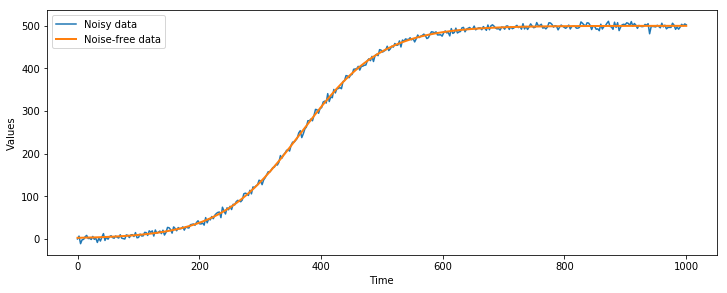

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

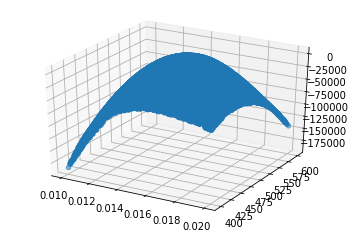

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(10000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

#print(max(likelihoods))
#idx = list(likelihoods).index(max(likelihoods))
#print(input_parameters[idx])
#print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [15]:
emu([0.015, 500])

array([[-1179.4745]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1210.917984539033

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


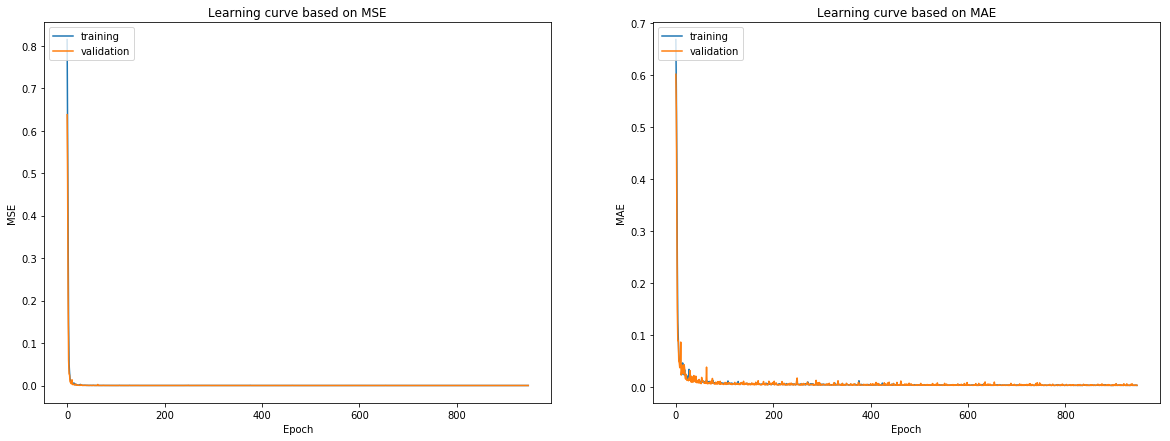

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))                 
ax1.title.set_text('Learning curve based on MSE')
ax2.title.set_text('Learning curve based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

plt.show()

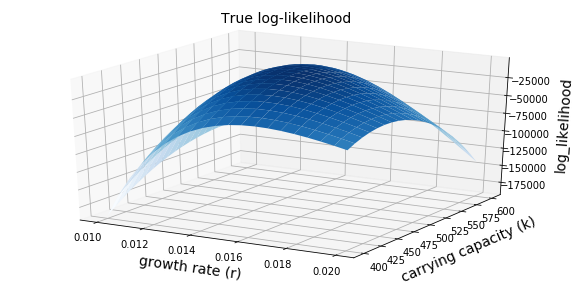

In [18]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

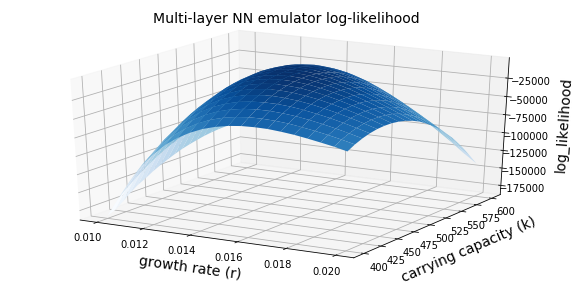

In [19]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

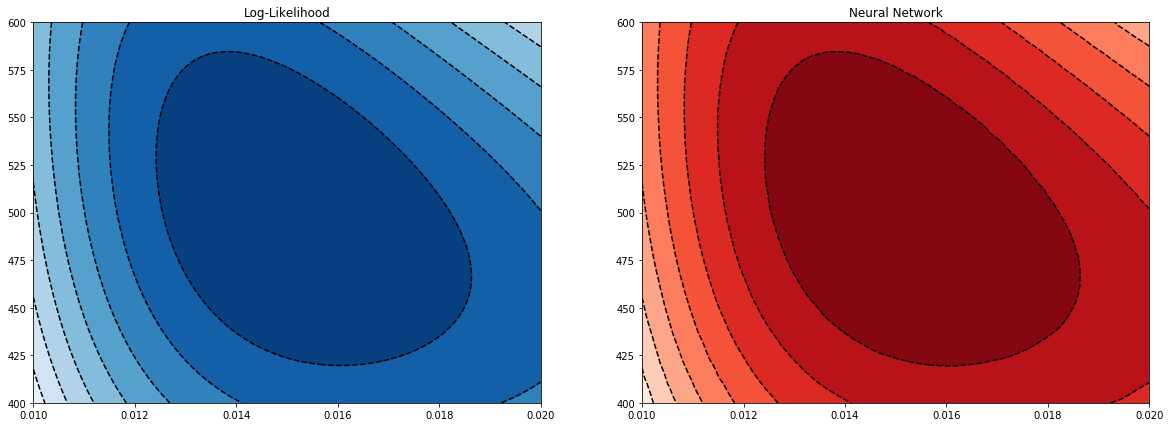

In [20]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

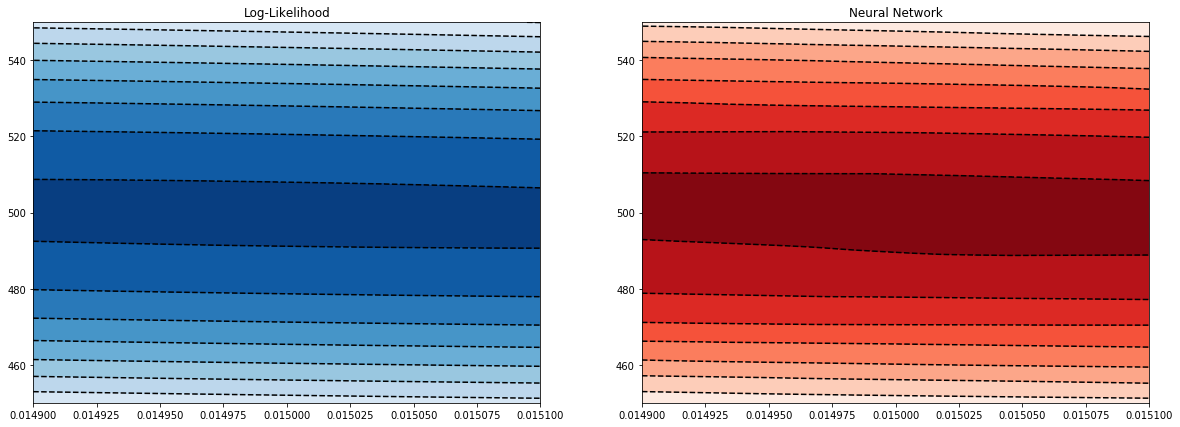

In [39]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0149, 450], [0.0151, 550], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

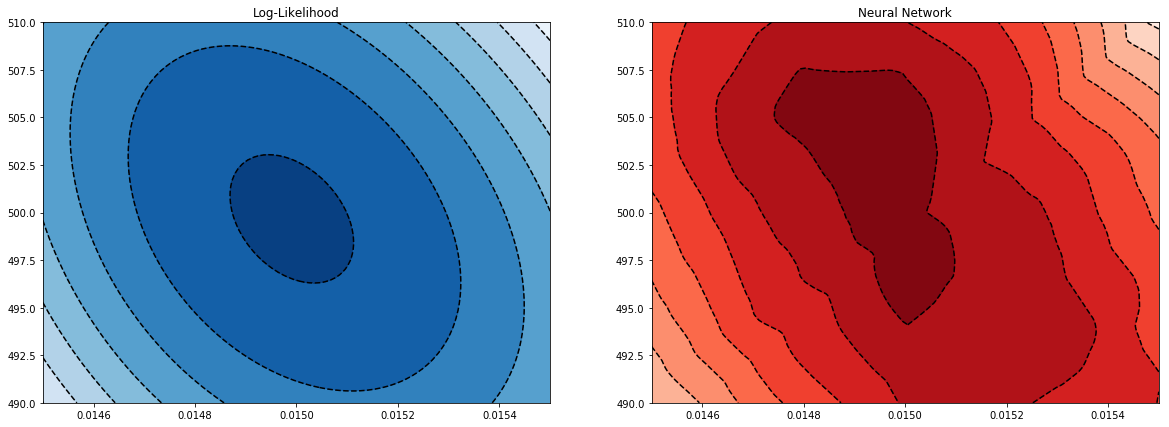

In [40]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

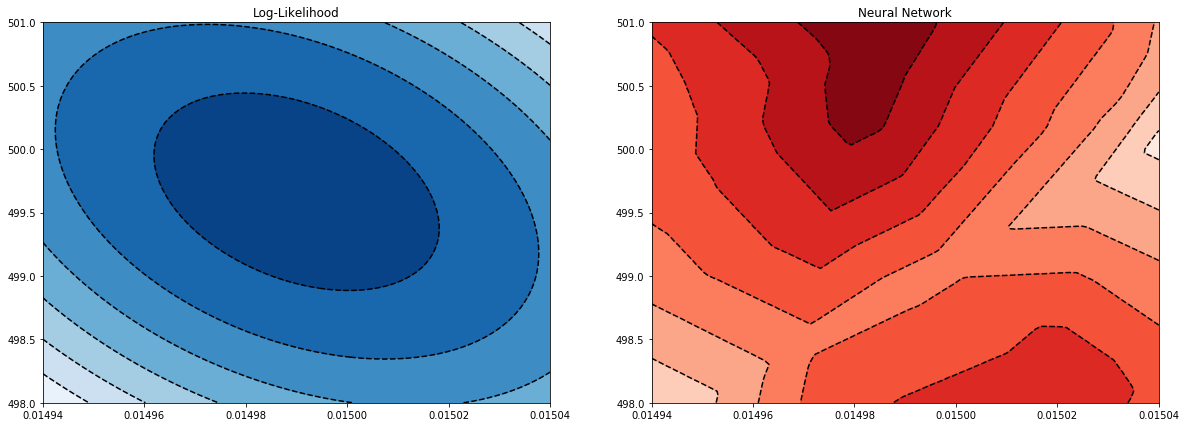

In [41]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.01494, 498], [0.01504, 501], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [23]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

Running...
[9.45151453e-03 4.53021526e+02]
-inf


[1.5487559e-03 5.2682423e+02]
-inf


[3.32529346e-02 5.76395333e+02]
-inf


[2.72107279e-02 4.53355454e+02]
-inf


[1.97537990e-02 5.26766903e+02]
-60534.03950774703


[1.92999554e-02 5.75877903e+02]
-95705.15901671968


[1.30762257e-02 4.52310037e+02]
-30301.745436644094


[1.72699690e-02 5.21881961e+02]
-20737.13792435743


[3.18364949e-02 5.76055327e+02]
-inf


[2.50793538e-02 4.48619217e+02]
-inf


[2.74055327e-03 5.27790837e+02]
-inf


[6.04936412e-03 5.75161791e+02]
-inf


[1.25170285e-02 4.50930562e+02]
-43175.72889517927


[7.60553466e-03 5.27673573e+02]
-inf


[2.43294516e-02 5.71838817e+02]
-inf


[7.95892806e-03 4.47046450e+02]
-inf


[1.59437679e-02 5.26599840e+02]
-9057.079689116415


[3.71272734e-02 5.78578878e+02]
-inf


[1.75949829e-02 4.51803736e+02]
-17378.450841662227
accepted


[1.44985927e-02 5.23210342e+02]
-3243.6475486886893
accepted


[3.10085238e-03 5.78341680e+02]
-inf


[2.20462086e-02 4.51564219e+02]
-inf




-inf


[8.83056459e-03 5.80311285e+02]
-inf


[1.19656290e-02 4.51620641e+02]
-58442.14367327824


[7.85335906e-03 5.22103693e+02]
-inf


[-1.60848784e-03  5.81006534e+02]
-inf


[2.13099198e-02 4.52000574e+02]
-inf


[2.13654398e-02 5.27036108e+02]
-inf


[2.50620490e-02 5.77848834e+02]
-inf


[2.38246450e-02 4.56092504e+02]
-inf


[2.01750062e-02 5.23155855e+02]
-inf


[2.14168498e-02 5.80363504e+02]
-inf


[1.29560370e-02 4.52410364e+02]
-32576.251502535983


[1.12702784e-02 5.19818857e+02]
-59724.870725459485


[1.43846103e-02 5.80636345e+02]
-23922.688615354717
accepted


[2.69953179e-02 4.53368710e+02]
-inf


[1.86587244e-02 5.22084153e+02]
-40019.66812153058


[-1.09208503e-02  5.84213491e+02]
-inf


[-1.25006845e-03  4.52233968e+02]
-inf


[2.06577445e-02 5.22870053e+02]
-inf


[2.27807289e-02 5.80199937e+02]
-inf


[2.38201206e-03 4.53098733e+02]
-inf


[2.99445887e-02 5.19140678e+02]
-inf


[2.35668790e-02 5.76700847e+02]
-inf


[1.55760113e-02 4.52591972e+02]
-9274.187522240

[1.97709581e-02 4.57548974e+02]
-37283.15739431904


[-6.61635906e-03  5.22100165e+02]
-inf


[1.49574200e-02 5.79620447e+02]
-26746.76995350924


[3.93632788e-03 4.59991860e+02]
-inf


[5.87877896e-04 5.18186792e+02]
-inf


[1.40798099e-02 5.79442333e+02]
-22422.36406913688
accepted


[-2.46993225e-03  4.60418453e+02]
-inf


[1.24934392e-02 5.20786269e+02]
-23670.919263771706


[-1.33681189e-02  5.78701274e+02]
-inf


[3.48397223e-02 4.62226248e+02]
-inf


[4.17448518e-03 5.20391965e+02]
-inf


[1.01315869e-02 5.79407434e+02]
-109498.3955953236


[2.35983343e-02 4.58866062e+02]
-inf


[3.70855474e-02 5.18475161e+02]
-inf


[4.20020424e-02 5.76085600e+02]
-inf


[1.56918690e-02 4.59540754e+02]
-7114.732645940654
accepted


[9.91923227e-03 5.19901154e+02]
-inf


[2.06197918e-02 5.81722742e+02]
-inf


[1.44671213e-02 4.55940476e+02]
-11588.731817353406


[-1.1711309e-02  5.1985844e+02]
-inf


[7.61566357e-03 5.78557214e+02]
-inf


[1.76136903e-02 4.57362867e+02]
-16458.251966934225


[2.

[1.54974038e-02 4.62370915e+02]
-6238.79161773173


[1.47055859e-02 5.19366090e+02]
-2561.6374065575064
accepted


[1.39832846e-02 5.77423180e+02]
-21287.118030601137


[1.55575149e-02 4.62177047e+02]
-6304.534653131776


[1.46763159e-02 5.19372805e+02]
-2569.8752803788557


[1.40700942e-02 5.76721985e+02]
-20994.78483915719
accepted


[1.55571211e-02 4.62406287e+02]
-6242.849969024461


[1.47169522e-02 5.19381411e+02]
-2562.437803388695
accepted


[1.40419970e-02 5.76809311e+02]
-21012.84899517374


[1.55470485e-02 4.62685864e+02]
-6164.6163846958725
accepted


[1.47423834e-02 5.19379888e+02]
-2562.6201439148954
accepted


[1.41149183e-02 5.76751477e+02]
-21065.243945236714


[1.56015040e-02 4.62706349e+02]
-6185.858873028885


[1.47153049e-02 5.19404931e+02]
-2565.7417408152533


[1.41108866e-02 5.76194167e+02]
-20773.906802383648
accepted


[1.55721694e-02 4.62498589e+02]
-6224.620874524823


[1.47208493e-02 5.19392583e+02]
-2563.725952590865
accepted


[1.42001106e-02 5.75221089e+0

[1.57015578e-02 4.73918418e+02]
-3954.4111892149685


[1.46325331e-02 5.18575977e+02]
-2492.945591366976


[1.52557648e-02 5.61044128e+02]
-18247.313233373774


[1.57186651e-02 4.80656873e+02]
-3119.743917738999
accepted


[1.46814954e-02 5.18846772e+02]
-2499.893424913119


[1.50919924e-02 5.63070793e+02]
-18128.88720178539
accepted


[1.55019089e-02 4.80625614e+02]
-2692.876205810693
accepted


[1.45394535e-02 5.17671431e+02]
-2492.744391331813


[1.50935294e-02 5.63032539e+02]
-18119.39250706353
accepted


[1.54812453e-02 4.75003727e+02]
-3465.074030919809


[1.46189867e-02 5.18302728e+02]
-2471.011417324946


[1.4979925e-02 5.6444504e+02]
-18112.13716830989
accepted


[1.52382722e-02 4.78499659e+02]
-2815.7090725903918


[1.45432203e-02 5.17563518e+02]
-2475.873587383485


[1.51260946e-02 5.62250517e+02]
-17936.088135469075
accepted


[1.52639695e-02 4.82874006e+02]
-2223.607974678194
accepted


[1.45741969e-02 5.17807850e+02]
-2460.843218725189
accepted


[1.51111041e-02 5.6207740


[1.52477627e-02 5.00449797e+02]
-1432.2120542756477


[1.47898603e-02 5.01230075e+02]
-1322.1627541538232


[1.49767024e-02 4.98594583e+02]
-1216.9402052927387
accepted


[1.5181992e-02 4.6838217e+02]
-4869.962982432681


[1.51333546e-02 4.97866352e+02]
-1265.677030493829


[1.50486911e-02 4.95099944e+02]
-1284.2340577490443


[1.52500729e-02 4.90969228e+02]
-1540.6855506166407


[1.49433051e-02 5.02660698e+02]
-1242.309882742671


[1.50774290e-02 4.96859993e+02]
-1246.0710910568248


[1.51337652e-02 4.91583346e+02]
-1446.0793755632149


[1.49783686e-02 4.98162589e+02]
-1221.6025235644327


[1.51026832e-02 4.91306644e+02]
-1458.2380635197464


[1.51061472e-02 5.07300470e+02]
-1564.9098964143077


[1.49650433e-02 5.01615299e+02]
-1223.9711524886277


[1.51277540e-02 4.91352869e+02]
-1457.76729782806


[1.52314654e-02 5.10973247e+02]
-2143.2654186504788


[1.51602804e-02 4.91681433e+02]
-1448.8772524528576


[1.48421772e-02 5.04655585e+02]
-1319.4982662704526


[1.51898308e-02 4.8784513

[1.49666361e-02 5.00605944e+02]
-1214.0543823383375


[1.50270229e-02 4.98062562e+02]
-1220.377997382614


[1.49209059e-02 5.09550669e+02]
-1565.4165289846974


[1.49556931e-02 5.00659573e+02]
-1215.446978306046


[1.49388732e-02 5.00503257e+02]
-1218.0670670111315


[1.49389272e-02 5.08022634e+02]
-1467.0737946025386


[1.50082588e-02 4.98882121e+02]
-1212.9063291507287


[1.49319538e-02 5.00417427e+02]
-1219.8197127653698


[1.49467420e-02 4.98611026e+02]
-1224.6949204310097


[1.5019904e-02 4.9963639e+02]
-1213.2802372278964


[1.49322665e-02 5.01794261e+02]
-1229.2769227691122


[1.49653130e-02 5.02997575e+02]
-1250.8701440735506


[1.50335827e-02 4.98163603e+02]
-1220.236496346459


[1.48957251e-02 5.01733677e+02]
-1239.791699492736


[1.50113907e-02 5.07086647e+02]
-1449.7926911337079


[1.50200852e-02 4.99460456e+02]
-1213.0398904309889


[1.49830555e-02 4.99136680e+02]
-1212.1410092945555
accepted


[1.51490771e-02 5.01509589e+02]
-1326.7760287314338


[1.50363581e-02 4.9752082



[1.49984190e-02 4.99076728e+02]
-1211.7736355565748


[1.50028283e-02 4.99790882e+02]
-1211.273568037317


[1.49488333e-02 5.00819817e+02]
-1217.361177750071


[1.49713843e-02 4.99986511e+02]
-1211.5660285720705


[1.49779026e-02 5.00450269e+02]
-1212.746043803654


[1.49849607e-02 4.97891712e+02]
-1224.1695998556836


[1.49745299e-02 5.00342237e+02]
-1212.3101189177066


[1.50020887e-02 4.99300923e+02]
-1211.1870245875605
accepted


[1.49709502e-02 5.01115923e+02]
-1217.985987305163


[1.49799678e-02 5.00331850e+02]
-1212.1348039980007


[1.49824232e-02 4.99425242e+02]
-1211.1166028522282
accepted


[1.49717789e-02 5.00566361e+02]
-1213.5498378920104
accepted


[1.49902501e-02 4.99859062e+02]
-1210.71747720439
accepted


[1.49914459e-02 4.98470570e+02]
-1216.2220919529782


[1.49386736e-02 5.01620636e+02]
-1226.067488218267


[1.49950109e-02 4.99796588e+02]
-1210.7637125376086
accepted


[1.49850971e-02 4.98567674e+02]
-1215.970392512697


[1.49878368e-02 5.01671019e+02]
-1226.63215

[1.49599925e-02 5.00140349e+02]
-1213.1141885641243
accepted


[1.49741975e-02 5.01106407e+02]
-1217.9244832847407


[1.49620241e-02 4.99814520e+02]
-1212.7477488835796


[1.49721683e-02 5.00317405e+02]
-1212.3249928822563
accepted


[1.49733567e-02 4.99820240e+02]
-1211.3057437706727


[1.50073673e-02 4.99181650e+02]
-1211.7525767315665
accepted


[1.49613267e-02 4.99764168e+02]
-1212.930827901126
accepted


[1.49756821e-02 5.00204406e+02]
-1211.74666269401
accepted


[1.49946265e-02 4.98949144e+02]
-1212.4309717703518


[1.49656622e-02 4.98997442e+02]
-1215.5571172374841


[1.49780210e-02 5.00027886e+02]
-1211.1837616503883
accepted


[1.49928571e-02 4.98438371e+02]
-1216.4119384206379


[1.49846123e-02 4.99422611e+02]
-1210.9912565416778
accepted


[1.49672361e-02 5.00512013e+02]
-1213.507099691425


[1.49998983e-02 4.99560619e+02]
-1210.822674618115
accepted


[1.50156221e-02 4.98554396e+02]
-1215.2691041228848


[1.49813190e-02 5.00044729e+02]
-1211.1097443058707
accepted


[1.498

[1.49982454e-02 5.00160743e+02]
-1212.1184781005966


[1.49892441e-02 4.99425457e+02]
-1210.8047291316066
accepted


[1.49789179e-02 4.99695524e+02]
-1210.9147196959107
accepted


[1.50277493e-02 4.99597174e+02]
-1214.804450217367


[1.49844831e-02 4.99203907e+02]
-1211.7223929081376


[1.49751354e-02 4.99289072e+02]
-1212.2785667144371


[1.49485487e-02 4.99596366e+02]
-1216.1888170767752


[1.49829138e-02 4.99327952e+02]
-1211.3690416982724
accepted


[1.49816581e-02 5.00149966e+02]
-1211.4017179507646


[1.49995767e-02 5.00273763e+02]
-1212.847735559234


[1.49762781e-02 4.99577803e+02]
-1211.271794941844
accepted


[1.49734669e-02 4.99854317e+02]
-1211.2973034587649


[1.49794024e-02 4.99248124e+02]
-1211.9746061387552
accepted


[1.50158609e-02 4.99011133e+02]
-1212.9808333701742


[1.49754406e-02 4.99761965e+02]
-1211.1392400392033


[1.4969593e-02 4.9815622e+02]
-1223.6568703561477


[1.49690810e-02 4.99497148e+02]
-1212.3251135112657
accepted


[1.49798338e-02 4.99676593e+02]
-

[1.49600360e-02 4.99657911e+02]
-1213.3798574631683


[1.50165565e-02 5.00169074e+02]
-1214.9133876721155


[1.49808570e-02 5.00226848e+02]
-1211.6836344857345
accepted


[1.49838583e-02 4.99148947e+02]
-1212.01497333895


[1.49910148e-02 4.99964070e+02]
-1210.9541956736973
accepted


[1.49917366e-02 4.99942151e+02]
-1210.9235620311363
accepted


[1.49953902e-02 5.00011879e+02]
-1211.299104970886
accepted


[1.49937236e-02 4.99875476e+02]
-1210.84961896914
accepted


[1.49819706e-02 4.99445166e+02]
-1211.097251111031
accepted


[1.49745363e-02 5.00699590e+02]
-1214.3472017875172


[1.49792954e-02 5.00815645e+02]
-1215.2990290321438


[1.49785227e-02 5.00648072e+02]
-1213.9797502203785


[1.50281963e-02 5.00044185e+02]
-1216.897883352416


[1.49463303e-02 5.00730114e+02]
-1217.301755842778


[1.49949768e-02 5.00354762e+02]
-1212.8684828774597


[1.50467645e-02 4.98276881e+02]
-1221.8977575127146


[1.50235598e-02 4.99806865e+02]
-1214.548951748685


[1.50262344e-02 4.98250135e+02]
-1218



[1.49952732e-02 5.00982522e+02]
-1218.313656994763


[1.49526536e-02 4.98469847e+02]
-1224.4120306558798


[1.49949456e-02 5.00053219e+02]
-1211.4132214973492
accepted


[1.49495812e-02 4.99390517e+02]
-1216.8912754062465


[1.49804301e-02 4.98450466e+02]
-1217.7990613100285


[1.49949983e-02 4.99775516e+02]
-1210.7333820486722
accepted


[1.49491190e-02 5.00621393e+02]
-1216.281029729411


[1.49800047e-02 4.98892076e+02]
-1213.931464800741


[1.50166180e-02 5.00611283e+02]
-1218.5254038271432


[1.49463564e-02 4.99612515e+02]
-1216.720883897196


[1.50098505e-02 4.99381977e+02]
-1211.647294460088


[1.49889469e-02 5.00687321e+02]
-1214.7430813896428


[1.49275250e-02 5.00982378e+02]
-1223.0586802751238


[1.50129528e-02 4.99055056e+02]
-1212.5536183903787
accepted


[1.49994854e-02 5.00288990e+02]
-1212.9263741098487


[1.49894603e-02 5.00879886e+02]
-1216.5335178644502


[1.50362142e-02 4.98520072e+02]
-1218.1588936448259


[1.50172188e-02 4.99088546e+02]
-1212.91867253825


[1.498

[1.49950839e-02 4.98232602e+02]
-1218.3839118686037


[1.49455912e-02 4.99508219e+02]
-1217.4067570610978


[1.49781488e-02 4.98022103e+02]
-1223.5823966934204


[1.49923044e-02 4.99931855e+02]
-1210.9189838060524
accepted


[1.50007349e-02 4.99527353e+02]
-1210.8722598212876
accepted


[1.49477705e-02 4.98928909e+02]
-1220.907592257532


[1.50305803e-02 4.99216756e+02]
-1214.9940593708768


[1.50057832e-02 4.99424305e+02]
-1211.2559080351728


[1.49743995e-02 4.99140817e+02]
-1213.104693585796
accepted


[1.49945536e-02 4.99760774e+02]
-1210.6978011583135
accepted


[1.49711082e-02 4.99510824e+02]
-1212.0055174857323
accepted


[1.49838475e-02 4.97911852e+02]
-1224.0715701378647


[1.49647491e-02 4.99143132e+02]
-1214.7408996519723


[1.49794778e-02 4.99713602e+02]
-1210.8687222796743
accepted


[1.50021235e-02 4.98115846e+02]
-1219.2318187868127


[1.50228273e-02 5.00175342e+02]
-1216.378220479794


[1.49691357e-02 4.99690614e+02]
-1211.8732106008667


[1.49513971e-02 4.99911541e+02]

[1.49585336e-02 4.99104991e+02]
-1216.3798658736293


[1.50005943e-02 4.98885921e+02]
-1212.6913178346301


[1.49933448e-02 4.98953007e+02]
-1212.4533290069742
accepted


[1.49759954e-02 4.99759104e+02]
-1211.0952970185915
accepted


[1.49841282e-02 4.99411894e+02]
-1211.0446152974464
accepted


[1.49633371e-02 4.99867214e+02]
-1212.4990802696207
accepted


[1.50066092e-02 5.00098051e+02]
-1212.787949410933


[1.49684835e-02 4.99311917e+02]
-1213.133387398216


[1.49441507e-02 4.97813185e+02]
-1238.0921227512756


[1.49978680e-02 5.00178987e+02]
-1212.1711323426591


[1.49790270e-02 5.00107382e+02]
-1211.3315004636156
accepted


[1.49734315e-02 5.00774654e+02]
-1214.9159563421952


[1.49844344e-02 4.99560634e+02]
-1210.743939345278
accepted


[1.49707194e-02 5.00136221e+02]
-1211.8729523846982
accepted


[1.49392652e-02 4.98750851e+02]
-1225.8487505187916


[1.49341726e-02 5.00315773e+02]
-1219.0518681567228


[1.49483512e-02 5.01076364e+02]
-1219.2351521338087


[1.49529054e-02 4.9888

[1.50215783e-02 4.99544188e+02]
-1213.4102002666416
accepted


[1.50214583e-02 4.97839852e+02]
-1222.463739990597


[1.49893962e-02 4.98903896e+02]
-1212.9479430436884


[1.50457107e-02 4.97513418e+02]
-1229.1645675394368


[1.50467305e-02 5.00852402e+02]
-1231.9317520224708


[1.50002416e-02 4.97765081e+02]
-1223.9740980058825


[1.49944173e-02 4.98962445e+02]
-1212.3655221560061
accepted


[1.49171128e-02 5.01331332e+02]
-1228.4894527851234


[1.50299883e-02 5.00012423e+02]
-1217.1896763045531


[1.50095171e-02 4.98977406e+02]
-1212.5567134286564
accepted


[1.50421111e-02 4.98756487e+02]
-1218.438884891019


[1.49965924e-02 4.99910201e+02]
-1211.0766416848178
accepted


[1.50510218e-02 5.00515456e+02]
-1229.4032583230348


[1.50142763e-02 4.99043524e+02]
-1212.7161407842598


[1.50337194e-02 4.98463925e+02]
-1218.0328648607401


[1.50388242e-02 4.97478465e+02]
-1228.6344052745433


[1.49568789e-02 5.00057431e+02]
-1213.5411709231455


[1.50248541e-02 4.99025833e+02]
-1214.1579459676

[1.49736593e-02 5.00147543e+02]
-1211.6894337765389


[1.49769868e-02 4.98846657e+02]
-1214.6835933118277


[1.50105929e-02 4.98508867e+02]
-1215.349621616515


[1.49848667e-02 4.99550190e+02]
-1210.7394878215507
accepted


[1.50504637e-02 4.98146629e+02]
-1223.709028551777


[1.49879415e-02 4.99702286e+02]
-1210.5697874657792
accepted


[1.49650382e-02 5.00055454e+02]
-1212.319880706241


[1.49680390e-02 4.98877705e+02]
-1216.0072928497075


[1.49703627e-02 4.99122234e+02]
-1213.8348166150834


[1.50320732e-02 4.98916316e+02]
-1215.7386234210614


[1.49890875e-02 4.98887864e+02]
-1213.0703001794195


[1.49714277e-02 4.99568050e+02]
-1211.8181831038735


[1.49737124e-02 5.00439403e+02]
-1212.7896300005639
accepted


[1.50164761e-02 4.98425526e+02]
-1216.2810963482755


[1.49625986e-02 5.01431494e+02]
-1221.61069374725


[1.49599377e-02 5.01005295e+02]
-1217.3683500457264


[1.49970181e-02 4.98947505e+02]
-1212.3853575819214
accepted


[1.50033301e-02 4.98630101e+02]
-1214.3267396776525

[1.49613706e-02 5.00461823e+02]
-1213.8210908222131


[1.50037362e-02 4.99300317e+02]
-1211.2714116105483
accepted


[1.49871977e-02 4.98918715e+02]
-1213.0149105625433


[1.49608774e-02 4.99570960e+02]
-1213.4680672250736
accepted


[1.50522208e-02 4.98956154e+02]
-1220.9708583871786


[1.50264385e-02 4.98970511e+02]
-1214.5586689986583


[1.49559046e-02 4.99192310e+02]
-1216.4294307099024


[1.49327949e-02 5.00525928e+02]
-1219.765692366741


[1.49734165e-02 4.99434809e+02]
-1211.9426880281912
accepted


[1.49739347e-02 4.98946466e+02]
-1214.4107034720093
accepted


[1.49321172e-02 5.00322062e+02]
-1219.6799971945845


[1.50156356e-02 4.99005646e+02]
-1212.9745752578783


[1.49914942e-02 4.99988115e+02]
-1211.0342150892484
accepted


[1.50081237e-02 4.98266954e+02]
-1217.4424209681963


[1.49876104e-02 4.98963888e+02]
-1212.707969642783
accepted


[1.49820032e-02 4.99458576e+02]
-1211.0630202791683
accepted


[1.49379826e-02 5.01770447e+02]
-1228.0079658226496


[1.49523378e-02 4.984

[1.49713966e-02 4.99615781e+02]
-1211.7206645872104
accepted


[1.50120354e-02 5.00501351e+02]
-1216.4681423096015


[1.49873324e-02 5.01003026e+02]
-1217.5944808789077


[1.49703054e-02 4.99311476e+02]
-1212.8474184218458


[1.50038841e-02 5.00135183e+02]
-1212.6104531233195
accepted


[1.50030663e-02 5.00899815e+02]
-1218.6640923389323


[1.50174913e-02 4.97878013e+02]
-1221.8583866610697


[1.50286941e-02 4.99321009e+02]
-1214.5981991212764


[1.49824866e-02 4.98806535e+02]
-1214.2584035090943


[1.49740231e-02 4.99989331e+02]
-1211.354920265395
accepted


[1.50052562e-02 4.99779720e+02]
-1211.4867455286048
accepted


[1.49708568e-02 5.00240441e+02]
-1212.1419254740954


[1.49933769e-02 5.00766864e+02]
-1215.8646028689825


[1.50699148e-02 4.99859041e+02]
-1231.8025993082288


[1.49801935e-02 4.99815329e+02]
-1210.8273217843744
accepted


[1.50111762e-02 5.00328386e+02]
-1214.9283753888906


[1.49845865e-02 5.00044939e+02]
-1211.0700266333245
accepted


[1.49816583e-02 4.99209379e+0

[1.49431477e-02 4.98423848e+02]
-1228.4952786783938


[1.49793798e-02 4.99785114e+02]
-1210.8618980585993
accepted


[1.50440745e-02 4.98261416e+02]
-1221.3898887313185


[1.50462763e-02 4.98118121e+02]
-1222.9450376398484


[1.50048956e-02 5.00992027e+02]
-1220.09030709488


[1.49759766e-02 5.00988186e+02]
-1216.7772554175287


[1.49839744e-02 5.00301123e+02]
-1212.0082312219583
accepted


[1.49686416e-02 4.99850652e+02]
-1211.7938677249465


[1.49792435e-02 4.99825650e+02]
-1210.880361798684
accepted


[1.50100867e-02 4.99914002e+02]
-1212.4901583903654
accepted


[1.50161762e-02 4.99928294e+02]
-1213.5551618661882


[1.49395352e-02 5.00123305e+02]
-1217.4823377345645


[1.50425955e-02 4.98714872e+02]
-1218.693719087711


[1.49931249e-02 4.98104819e+02]
-1220.0895897617738


[1.50037481e-02 4.99488232e+02]
-1211.0736018898847
accepted


[1.50113372e-02 5.00813574e+02]
-1219.4099445710654


[1.49677827e-02 4.99532988e+02]
-1212.409019253729
accepted


[1.50552074e-02 4.99627986e+02]
-

[1.49906022e-02 4.99336155e+02]
-1210.9787668770184
accepted


[1.49704732e-02 4.99143421e+02]
-1213.6904983315303


[1.50271696e-02 4.98646914e+02]
-1215.9457980504435


[1.49565892e-02 4.99568837e+02]
-1214.3491973366226


[1.49875315e-02 4.99896136e+02]
-1210.7490461185948
accepted


[1.49830586e-02 4.99534214e+02]
-1210.8494656570729
accepted


[1.50178203e-02 4.99263869e+02]
-1212.7000552076213
accepted


[1.49235315e-02 4.99962252e+02]
-1223.156486698


[1.50637343e-02 4.98472261e+02]
-1225.9324545273512


[1.50103396e-02 4.98421313e+02]
-1216.0502731779


[1.50137939e-02 4.99086294e+02]
-1212.5441365507268
accepted


[1.50262923e-02 4.98360772e+02]
-1217.668827578831


[1.50643069e-02 4.99688544e+02]
-1227.8355814054444


[1.49933775e-02 4.99295037e+02]
-1211.0434232424539
accepted


[1.49840049e-02 5.00591160e+02]
-1213.7141785775034


[1.49931068e-02 4.99660896e+02]
-1210.5870816703223
accepted


[1.50084149e-02 4.99648036e+02]
-1211.5935532994765


[1.49690131e-02 5.00802734e

[1.49664483e-02 4.99692133e+02]
-1212.2382122250872


[1.49718512e-02 5.00831322e+02]
-1215.3822013656861


[1.49725713e-02 4.98622711e+02]
-1217.4194036191889


[1.50333260e-02 4.99990575e+02]
-1218.0108279188785


[1.49990393e-02 4.99956717e+02]
-1211.3835750963306
accepted


[1.49833569e-02 4.98309409e+02]
-1218.9111858612434


[1.49464269e-02 4.99306501e+02]
-1218.3129382178631


[1.49782061e-02 5.00002229e+02]
-1211.1272021172729
accepted


[1.50397095e-02 4.98878314e+02]
-1217.521252694694


[1.50181624e-02 4.98904271e+02]
-1213.609602527825


[1.49493290e-02 4.99639188e+02]
-1215.823113261673


[1.50265042e-02 5.01117471e+02]
-1227.7423298877259


[1.48833206e-02 5.01222850e+02]
-1242.5580595509168


[1.49919375e-02 4.99830846e+02]
-1210.7102757650987
accepted


[1.49338290e-02 4.99823638e+02]
-1219.818265452668


[1.49682776e-02 4.99291029e+02]
-1213.2663999559009


[1.49381934e-02 4.99761475e+02]
-1218.59448345433


[1.49918121e-02 4.99418335e+02]
-1210.7758026356066
accepted


[1.49830984e-02 4.99357782e+02]
-1211.2608739642958
accepted


[1.49806071e-02 4.99748512e+02]
-1210.7952644919937


[1.49763219e-02 4.99297065e+02]
-1212.1027818250814
accepted


[1.49849057e-02 4.99747086e+02]
-1210.6309756125381
accepted


[1.50957248e-02 4.99197476e+02]
-1241.9007558231317


[1.49874448e-02 4.99505115e+02]
-1210.7130804512187
accepted


[1.49728418e-02 5.00029485e+02]
-1211.5014465110644
accepted


[1.50474321e-02 4.98250863e+02]
-1222.2310594197372


[1.50001188e-02 4.99608499e+02]
-1210.8439385168024
accepted


[1.49784970e-02 4.98594871e+02]
-1216.6399309503045


[1.49444333e-02 4.99907148e+02]
-1216.38732813519


[1.49946031e-02 5.01127069e+02]
-1219.913912650833


[1.50150892e-02 4.99486852e+02]
-1212.2803592674534
accepted


[1.49502454e-02 5.01159531e+02]
-1219.6830148869092


[1.49911270e-02 4.99546678e+02]
-1210.6060166792877
accepted


[1.49934156e-02 4.98730271e+02]
-1213.8802679879648


[1.49639013e-02 4.98981437e+02]
-1216.0546330858929


[1.50217296e-

[1.49777762e-02 5.00696033e+02]
-1214.319357429311


[1.49277336e-02 4.98717923e+02]
-1231.2373227754863


[1.49595879e-02 5.00723833e+02]
-1215.3541830796883


[1.49358513e-02 5.01193559e+02]
-1222.4094319063988


[1.50090953e-02 4.98660191e+02]
-1214.214443457601


[1.49954022e-02 4.98970997e+02]
-1212.293914156351
accepted


[1.50022980e-02 5.00990048e+02]
-1219.5592298429249


[1.49650578e-02 4.98810951e+02]
-1217.2217798486433


[1.50245015e-02 4.98921379e+02]
-1214.3902392816508


[1.50200244e-02 4.98640066e+02]
-1215.0946997231067


[1.49923476e-02 4.99173837e+02]
-1211.4566964360538
accepted


[1.49483511e-02 4.99579952e+02]
-1216.308155810094


[1.50154186e-02 4.99806534e+02]
-1212.957452072417
accepted


[1.49886120e-02 4.99397879e+02]
-1210.881127911259
accepted


[1.49583169e-02 4.97636776e+02]
-1235.7327247167116


[1.50114792e-02 5.00823512e+02]
-1219.5538424075173


[1.49913907e-02 4.98985845e+02]
-1212.357067083514


[1.49906136e-02 4.98852577e+02]
-1213.1975579944892




[1.50326803e-02 4.97246688e+02]
-1231.5373479240486


[1.50113239e-02 4.99467978e+02]
-1211.7865983316058
accepted


[1.50553006e-02 4.98580760e+02]
-1222.7194749123637


[1.49293221e-02 5.00131618e+02]
-1220.656190956739


[1.49594593e-02 5.00336010e+02]
-1213.6143764445317


[1.49237345e-02 4.99839869e+02]
-1223.511558559149


[1.50023660e-02 5.00751286e+02]
-1216.9765456181108


[1.50302154e-02 4.99105470e+02]
-1215.001542782638


[1.50372581e-02 4.98610941e+02]
-1217.9034589044504


[1.50219911e-02 4.99723312e+02]
-1213.9195468660184


[1.49917467e-02 5.00410866e+02]
-1212.9520055073785
accepted


[1.49411086e-02 4.99689478e+02]
-1217.949975429504


[1.50133678e-02 5.00083013e+02]
-1213.7921883710871


[1.49578807e-02 4.99046879e+02]
-1216.972620106674


[1.49685082e-02 5.00415540e+02]
-1212.9636898378935
accepted


[1.50229317e-02 4.98083210e+02]
-1219.8180667681343


[1.49394618e-02 5.01774641e+02]
-1227.8443210657767


[1.50044857e-02 5.00469915e+02]
-1214.8342775815531


[1.50


[1.4984738e-02 4.9889864e+02]
-1213.3603683165013


[1.49522715e-02 4.99247979e+02]
-1217.0150050509405


[1.50157811e-02 4.99252958e+02]
-1212.4402110572134


[1.4965197e-02 5.0020601e+02]
-1212.5635855010794
accepted


[1.49732445e-02 4.98694113e+02]
-1216.6058975318056


[1.50360306e-02 4.99770095e+02]
-1217.6014582538976


[1.50054476e-02 5.00099139e+02]
-1212.635170528175
accepted


[1.49427018e-02 4.99268454e+02]
-1219.7519278856532


[1.50132648e-02 5.00235936e+02]
-1214.6877186446666


[1.49774396e-02 4.99352958e+02]
-1211.76499039405
accepted


[1.50337383e-02 5.00609529e+02]
-1223.5986919309485


[1.49128106e-02 5.01074005e+02]
-1228.362089412534


[1.49787754e-02 4.99082913e+02]
-1212.8627825013978
accepted


[1.49670335e-02 5.00519463e+02]
-1213.5593502121505


[1.49516097e-02 4.98262059e+02]
-1227.6171434469727


[1.50272531e-02 4.98331792e+02]
-1218.0071343746124


[1.49720046e-02 5.00183308e+02]
-1211.8935506248524


[1.50028610e-02 4.98994058e+02]
-1212.188461478606




[1.49894023e-02 5.00165662e+02]
-1211.5612892256177


[1.50005829e-02 4.99362504e+02]
-1211.0130617498535
accepted


[1.50133712e-02 4.99393968e+02]
-1212.035405454652


[1.49859601e-02 4.98031473e+02]
-1222.0094285388648


[1.49701272e-02 4.99297180e+02]
-1212.9400024241008


[1.50279257e-02 4.98939818e+02]
-1214.897871854078


[1.49795801e-02 4.99551009e+02]
-1211.0441166212595
accepted


[1.50488806e-02 4.99319053e+02]
-1220.1274089472158


[1.49580096e-02 4.99707993e+02]
-1213.6496604478407


[1.50173540e-02 4.99890099e+02]
-1213.6139907578693


[1.49979684e-02 4.99526299e+02]
-1210.742314318696
accepted


[1.49498085e-02 5.00977736e+02]
-1218.2663072228086


[1.49549148e-02 4.99829837e+02]
-1214.0398761646


[1.50065087e-02 4.99463926e+02]
-1211.2979018747803


[1.49382797e-02 4.99941559e+02]
-1218.0712564553905


[1.50048358e-02 4.99229295e+02]
-1211.4799745177315
accepted


[1.49880519e-02 5.00001512e+02]
-1210.980035934046
accepted


[1.50255323e-02 4.99170458e+02]
-1214.028881

[1.49506540e-02 5.01410855e+02]
-1222.1275628441642


[1.49707233e-02 4.99105200e+02]
-1213.8782454251225


[1.50157585e-02 4.99590756e+02]
-1212.4927116322049


[1.49738015e-02 5.00294457e+02]
-1212.1505325104793
accepted


[1.49907761e-02 5.00187582e+02]
-1211.712561825257
accepted


[1.50020211e-02 4.99647274e+02]
-1210.9941527060457
accepted


[1.49798282e-02 4.99612419e+02]
-1210.933196026419
accepted


[1.49727902e-02 4.99667376e+02]
-1211.476293902524
accepted


[1.49996672e-02 4.99438142e+02]
-1210.876268166316
accepted


[1.49168073e-02 5.01664555e+02]
-1231.5307542664136


[1.49733644e-02 4.98891854e+02]
-1214.9091712475135
accepted


[1.50468061e-02 4.99422650e+02]
-1219.6841075466011


[1.49719893e-02 5.00582766e+02]
-1213.638984265072


[1.50400271e-02 4.97654596e+02]
-1226.4969753765972


[1.49884867e-02 4.99282562e+02]
-1211.2033092116044
accepted


[1.50073533e-02 4.99324387e+02]
-1211.4789445778763
accepted


[1.49866561e-02 4.98180364e+02]
-1219.9678673348287


[1.496

[1.50548097e-02 4.99930286e+02]
-1225.321276311199


[1.49621545e-02 4.99731572e+02]
-1212.8439018325182


[1.49970905e-02 4.99432746e+02]
-1210.7963094455865
accepted


[1.50219646e-02 4.99749407e+02]
-1213.998868645226
accepted


[1.50043601e-02 4.99222390e+02]
-1211.4701980953741
accepted


[1.49885908e-02 5.00657418e+02]
-1214.4731055982377


[1.50879100e-02 5.00771426e+02]
-1254.2492826083383


[1.50609339e-02 4.98720030e+02]
-1224.251739538147


[1.49892053e-02 4.99848695e+02]
-1210.68678576389
accepted


[1.49980118e-02 5.01978304e+02]
-1234.139153924317


[1.50206894e-02 4.98613844e+02]
-1215.3191663104024


[1.49264351e-02 5.01586042e+02]
-1228.141119842902


[1.50112678e-02 4.98632158e+02]
-1214.4906722226215
accepted


[1.49761322e-02 4.99437166e+02]
-1211.6256824676486
accepted


[1.50004758e-02 5.00700638e+02]
-1216.1879349100227


[1.50134497e-02 4.98976425e+02]
-1212.8632205381814
accepted


[1.49765862e-02 5.00673769e+02]
-1214.1521411401293
accepted


[1.50255177e-02 4


[1.51173121e-02 4.99847346e+02]
-1262.6248210281858


[1.49971138e-02 5.00897082e+02]
-1217.647544380593


[1.50073226e-02 5.01021528e+02]
-1220.9681680121707


[1.49832627e-02 4.97991388e+02]
-1223.025313924513


[1.50247329e-02 4.98784226e+02]
-1214.938869522314


[1.49373437e-02 5.00152864e+02]
-1218.0949497694326


[1.50170591e-02 4.98176523e+02]
-1218.5300349146567


[1.50556300e-02 4.99078091e+02]
-1222.1385637064975


[1.50176758e-02 4.98496804e+02]
-1215.8242345218976


[1.49596377e-02 4.98624433e+02]
-1220.4475865472448


[1.49804167e-02 4.99703021e+02]
-1210.8182313566097
accepted


[1.49383843e-02 5.01138109e+02]
-1221.4483523193846


[1.50115842e-02 4.99026640e+02]
-1212.526294004938
accepted


[1.49635850e-02 5.00282485e+02]
-1212.9438492147804


[1.50138042e-02 4.99256376e+02]
-1212.1976546042924
accepted


[1.49946017e-02 4.99907770e+02]
-1210.9603633197364
accepted


[1.49563253e-02 5.00508693e+02]
-1214.6551933414933


[1.49734251e-02 4.99026223e+02]
-1213.94350238701



[1.49910939e-02 4.99064499e+02]
-1211.9691860200003
accepted


[1.49556588e-02 5.00412959e+02]
-1214.4019789001982
accepted


[1.49725291e-02 4.99200484e+02]
-1213.0531082342309


[1.49952755e-02 4.97866715e+02]
-1223.0236529602491


[1.49708611e-02 5.00602422e+02]
-1213.8015063192493
accepted


[1.49829305e-02 5.01357690e+02]
-1221.4122007594851


[1.50056980e-02 4.98047801e+02]
-1219.874970891805


[1.49393596e-02 5.01251415e+02]
-1222.1889668093265


[1.50088591e-02 4.98969077e+02]
-1212.5492950562984
accepted


[1.49913851e-02 4.99004944e+02]
-1212.2554888130028
accepted


[1.50357286e-02 4.99595848e+02]
-1216.8239328365783


[1.49813401e-02 5.00133502e+02]
-1211.3534158932334
accepted


[1.49812866e-02 4.99662415e+02]
-1210.7943552528452
accepted


[1.49704438e-02 5.00048733e+02]
-1211.7317796693042
accepted


[1.50974076e-02 4.99366387e+02]
-1243.9165958758108


[1.49905904e-02 4.99376095e+02]
-1210.8809273954519


[1.49453561e-02 5.00453179e+02]
-1216.4197972895956


[1.494023

accepted


[1.50033180e-02 4.99475971e+02]
-1211.0481313043813


[1.50248626e-02 4.99794519e+02]
-1214.7919792942075


[1.49878016e-02 4.99247910e+02]
-1211.3515769254761
accepted


[1.49572429e-02 4.99277048e+02]
-1215.5711147687193


[1.49385230e-02 5.01567848e+02]
-1225.4885159278301


[1.50429483e-02 4.97549151e+02]
-1228.2591036795366


[1.50267621e-02 4.98895091e+02]
-1214.8338545705722


[1.49749439e-02 5.01600747e+02]
-1224.1280060232805


[1.49786859e-02 5.00211721e+02]
-1211.6665007718964
accepted


[1.49946171e-02 4.99542937e+02]
-1210.6373690261753
accepted


[1.50361126e-02 5.00766147e+02]
-1226.3576994828675


[1.49538458e-02 4.99814600e+02]
-1214.2900561313452


[1.50277401e-02 5.01208270e+02]
-1229.5732001535096


[1.50325177e-02 4.98979635e+02]
-1215.6809424023484


[1.49670847e-02 5.00652640e+02]
-1214.3029333074705


[1.50334645e-02 4.98197485e+02]
-1219.9307384350532


[1.49709305e-02 5.00876906e+02]
-1215.7699083450834


[1.49707363e-02 5.01944789e+02]
-1229.258653

[1.49440300e-02 4.99964167e+02]
-1216.4043724978258


[1.49995179e-02 4.98110890e+02]
-1219.4475138837386


[1.49964773e-02 4.98806306e+02]
-1213.224536311109
accepted


[1.50156153e-02 5.00198812e+02]
-1214.9105264286823


[1.49378762e-02 4.98482242e+02]
-1229.8479971543327


[1.49553132e-02 5.00343601e+02]
-1214.2512686042692


[1.49154787e-02 4.99640568e+02]
-1228.162974173073


[1.49666425e-02 4.99079985e+02]
-1214.7771593427685


[1.50447463e-02 5.00362346e+02]
-1225.042277805242


[1.49371263e-02 4.99755593e+02]
-1218.9584584448303


[1.49812425e-02 4.99950221e+02]
-1210.9228904010445
accepted


[1.50344222e-02 4.97172087e+02]
-1232.8826851825067


[1.49541664e-02 5.00664791e+02]
-1215.6836579806004


[1.50057247e-02 5.00889371e+02]
-1219.0578718265522


[1.50526546e-02 4.98029542e+02]
-1225.1690702614274


[1.49378450e-02 5.00842478e+02]
-1219.6474482638857


[1.49126848e-02 5.01047052e+02]
-1228.2756400643777


[1.49931593e-02 4.99896671e+02]
-1210.8715366376746
accepted


[1.4

[1.50515285e-02 4.99296911e+02]
-1220.98984423362


[1.49909715e-02 5.00080770e+02]
-1211.30371398332
accepted


[1.49312183e-02 5.00325100e+02]
-1219.962714250595


[1.49598828e-02 4.99502827e+02]
-1213.9005177798524


[1.49865883e-02 5.00036431e+02]
-1211.0546391779988
accepted


[1.50180004e-02 4.99671772e+02]
-1213.0210756822335


[1.49570429e-02 5.00631767e+02]
-1215.1274852135912


[1.49784667e-02 4.99623927e+02]
-1211.0159837282674
accepted


[1.49725117e-02 4.99015624e+02]
-1214.15975996373


[1.49127044e-02 5.01279545e+02]
-1229.6108115341822


[1.49508786e-02 5.00460106e+02]
-1215.3506514065748


[1.49920109e-02 5.00178823e+02]
-1211.738590138949


[1.49740545e-02 5.00959260e+02]
-1216.4752711939566


[1.49764509e-02 5.01724694e+02]
-1226.1149103784994


[1.50364392e-02 4.98164924e+02]
-1220.6688683366335


[1.49578271e-02 5.01164017e+02]
-1218.956974636896


[1.49156101e-02 4.99737048e+02]
-1227.5269557763615


[1.50146351e-02 4.99059468e+02]
-1212.705269300741


[1.49334777

[1.49814727e-02 5.00887424e+02]
-1216.020764347725


[1.49869581e-02 4.99199558e+02]
-1211.5797984253716
accepted


[1.50087026e-02 4.99983457e+02]
-1212.5634523654396


[1.49780972e-02 4.99023295e+02]
-1213.2996047467461


[1.50093607e-02 5.00136212e+02]
-1213.3982895647289


[1.50082822e-02 4.98684022e+02]
-1214.0305186766457


[1.50314588e-02 4.98649566e+02]
-1216.6192181903468


[1.49880958e-02 4.98699405e+02]
-1214.5086108167204
accepted


[1.49825857e-02 5.00409109e+02]
-1212.5350767091982


[1.50540366e-02 4.98191494e+02]
-1224.3267054782732


[1.50043195e-02 5.00447715e+02]
-1214.6378324465175
accepted


[1.50038287e-02 4.99532452e+02]
-1211.0748256359723
accepted


[1.49187567e-02 4.99658699e+02]
-1226.5398298460416


[1.50342089e-02 5.00795284e+02]
-1226.0222044286188


[1.49678872e-02 5.00177813e+02]
-1212.2197579907886


[1.50091598e-02 4.98992775e+02]
-1212.4732753658216
accepted


[1.4986964e-02 4.9917629e+02]
-1211.6755038889548
accepted


[1.50166031e-02 4.98882714e+02]

[1.49923979e-02 4.99537434e+02]
-1210.6151502225587
accepted


[1.49919624e-02 4.98978528e+02]
-1212.3705117705813


[1.49353009e-02 5.00016064e+02]
-1218.8537147963866


[1.49944366e-02 4.99461907e+02]
-1210.7106502508057
accepted


[1.50019088e-02 4.99603791e+02]
-1210.956437323313
accepted


[1.50605909e-02 4.99941631e+02]
-1227.9614583556452


[1.49975337e-02 5.01694190e+02]
-1228.8140419521935


[1.50188679e-02 4.98910315e+02]
-1213.6675612752151


[1.49854279e-02 4.99726354e+02]
-1210.6143556249042
accepted


[1.49937533e-02 4.99849878e+02]
-1210.8012973085831
accepted


[1.49920723e-02 5.01714346e+02]
-1228.0639497799195


[1.49688746e-02 4.99522978e+02]
-1212.2776541669252


[1.49734459e-02 4.98368040e+02]
-1220.0238340181572


[1.50095598e-02 4.99773191e+02]
-1211.9787368119153


[1.49443770e-02 5.00800975e+02]
-1218.0441386939292


[1.50043132e-02 5.00528445e+02]
-1215.2756651926877


[1.49817127e-02 4.99219238e+02]
-1211.8800155614626


[1.49966174e-02 4.99617979e+02]
-1210.

[1.49276133e-02 5.00765640e+02]
-1222.02193186481


[1.49652447e-02 5.00283138e+02]
-1212.7649742867652
accepted


[1.49789393e-02 4.99912180e+02]
-1210.9625164796373
accepted


[1.49685280e-02 5.00030331e+02]
-1211.8929691193416
accepted


[1.49872162e-02 5.01297448e+02]
-1221.0822581065395


[1.49224314e-02 5.00597598e+02]
-1223.2218021574463


[1.49967933e-02 5.00369012e+02]
-1213.1288558283813


[1.49172664e-02 5.01113883e+02]
-1226.997246636165


[1.50058525e-02 5.01074482e+02]
-1221.3175346909297


[1.49697336e-02 5.00772833e+02]
-1214.9873259098842


[1.49785161e-02 4.99603557e+02]
-1211.0399085223526
accepted


[1.49888563e-02 5.00704734e+02]
-1214.8808568450575


[1.50091193e-02 4.97562829e+02]
-1226.3771736621998


[1.49896262e-02 4.99670161e+02]
-1210.5576253652864
accepted


[1.49445082e-02 5.00317574e+02]
-1216.3193852430543


[1.49765588e-02 4.99414706e+02]
-1211.6497584246824
accepted


[1.49770628e-02 5.00363363e+02]
-1212.3238773165037


[1.49198952e-02 4.98526087e+02]

[1.49976373e-02 4.97703335e+02]
-1225.1691812403658


[1.49968681e-02 4.98811888e+02]
-1213.17742219734


[1.50332971e-02 4.98738680e+02]
-1216.5626311342276


[1.50544687e-02 4.99495084e+02]
-1222.6733432331164


[1.49507063e-02 4.98830668e+02]
-1220.9239176902217


[1.49761109e-02 5.00102392e+02]
-1211.4384304350299
accepted


[1.49598067e-02 4.99733071e+02]
-1213.254837888546


[1.49704035e-02 4.99817934e+02]
-1211.6029715153122
accepted


[1.50563666e-02 4.98569992e+02]
-1223.0944401045965


[1.4952089e-02 4.9979138e+02]
-1214.7229801448484


[1.50034143e-02 4.98705374e+02]
-1213.7987453269207


[1.49635029e-02 4.99501313e+02]
-1213.215424377147


[1.49213991e-02 5.00854216e+02]
-1224.3418839426206


[1.49892849e-02 4.99864554e+02]
-1210.7116728926776
accepted


[1.49360776e-02 5.02164590e+02]
-1233.9268813032509


[1.50130517e-02 5.00005450e+02]
-1213.3461712058925


[1.50301561e-02 5.00310844e+02]
-1219.4448543250728


[1.50247608e-02 4.98830126e+02]
-1214.7541565502409


[1.5005



[1.48926797e-02 5.01902760e+02]
-1242.7080701341906


[1.49317384e-02 5.00800667e+02]
-1220.9808261832286


[1.50162215e-02 4.99852408e+02]
-1213.257963676366
accepted


[1.50023744e-02 5.00268154e+02]
-1213.1477457402723
accepted


[1.49557667e-02 5.00631110e+02]
-1215.2905913969137


[1.50284400e-02 5.00442273e+02]
-1220.1181926492502


[1.49607129e-02 5.01425810e+02]
-1221.6005521898728


[1.50292276e-02 4.99286486e+02]
-1214.7012585333075


[1.50532180e-02 5.01101097e+02]
-1238.9593526241595


[1.49777121e-02 5.00806073e+02]
-1215.1814267510076


[1.49876214e-02 5.00029734e+02]
-1211.0491743904452
accepted


[1.49930618e-02 5.00096381e+02]
-1211.4607080309183
accepted


[1.50297837e-02 4.98091452e+02]
-1220.3920528892113


[1.49384068e-02 5.00953742e+02]
-1220.1601200780772


[1.50307594e-02 4.99457743e+02]
-1215.2052296090035


[1.50422958e-02 4.99879070e+02]
-1220.1834534109946


[1.49658360e-02 5.00941432e+02]
-1216.4707902245175


[1.50122344e-02 4.99890021e+02]
-1212.7270617

[1.49874011e-02 4.99638192e+02]
-1210.5861136926517
accepted


[1.49273639e-02 5.00179679e+02]
-1221.2841133371876


[1.49257691e-02 5.00923538e+02]
-1223.264399694906


[1.49501008e-02 4.99679868e+02]
-1215.4905999954474


[1.50452394e-02 4.99670798e+02]
-1220.072414215941


[1.49544217e-02 5.00118461e+02]
-1214.021456862952


[1.50166203e-02 5.00721443e+02]
-1219.6709129084534


[1.50132333e-02 4.99447532e+02]
-1212.0155521328184
accepted


[1.50307155e-02 4.99862804e+02]
-1216.5525268529461


[1.50018414e-02 4.98792454e+02]
-1213.235196360762


[1.49636916e-02 4.99565890e+02]
-1212.9726890765414
accepted


[1.49362251e-02 5.00451617e+02]
-1218.6450525671173


[1.49935548e-02 5.00644743e+02]
-1214.811184689316


[1.49602671e-02 4.99013750e+02]
-1216.640574829221


[1.49817968e-02 4.99884487e+02]
-1210.8154413285038
accepted


[1.50207606e-02 4.99368171e+02]
-1213.1086302524716


[1.49244442e-02 4.99521122e+02]
-1224.91226438539


[1.50077018e-02 4.98989715e+02]
-1212.3990330740899
ac

[1.49913239e-02 4.99810372e+02]
-1210.6669687949595
accepted


[1.49592220e-02 5.00584831e+02]
-1214.6259085955803


[1.50231905e-02 4.99891856e+02]
-1214.830938656143


[1.50306288e-02 4.97799752e+02]
-1223.6053025333508


[1.50137237e-02 5.00283968e+02]
-1215.1050224155365


[1.49508824e-02 4.98753791e+02]
-1221.6623561530564


[1.49581680e-02 5.01855165e+02]
-1227.4877215558213


[1.49949397e-02 5.00134674e+02]
-1211.7320954229606
accepted


[1.49951920e-02 4.99689375e+02]
-1210.6558316604217
accepted


[1.50059991e-02 5.00239914e+02]
-1213.477154939698


[1.50072957e-02 5.00797794e+02]
-1218.3669634956557


[1.49889596e-02 4.99956194e+02]
-1210.8845259487482
accepted


[1.49500269e-02 4.98816029e+02]
-1221.2881928734523


[1.49464332e-02 5.02060832e+02]
-1231.217952379444


[1.50254953e-02 4.99225734e+02]
-1213.97486990059
accepted


[1.49773670e-02 5.00149318e+02]
-1211.5076765523697
accepted


[1.49161718e-02 5.01610735e+02]
-1231.1865894118116


[1.50101866e-02 4.99583370e+02]
-



[1.5025347e-02 4.9801298e+02]
-1220.7361052909907


[1.49338036e-02 5.00074535e+02]
-1219.242069813645


[1.50237506e-02 4.99869818e+02]
-1214.8572909327486
accepted


[1.49847394e-02 5.00729105e+02]
-1214.8050759710022


[1.49789831e-02 5.00707831e+02]
-1214.4242965463727


[1.50650205e-02 4.98428251e+02]
-1226.5593962740659


[1.50302437e-02 4.99245676e+02]
-1214.9164862702726


[1.50058689e-02 5.00003767e+02]
-1212.264188440772


[1.50108448e-02 4.98341006e+02]
-1216.7650062930702


[1.50022753e-02 4.99867114e+02]
-1211.4049199755793
accepted


[1.49488261e-02 4.98918912e+02]
-1220.6612659478214


[1.50277755e-02 5.00998947e+02]
-1226.4683414841038


[1.50192683e-02 4.99431015e+02]
-1212.8837056088646


[1.49562797e-02 5.00114249e+02]
-1213.6838170469384


[1.49798638e-02 5.00500364e+02]
-1213.0271923443065
accepted


[1.49914646e-02 5.00178476e+02]
-1211.7077336897812


[1.49492731e-02 5.00127396e+02]
-1215.0638596903136


[1.49899165e-02 5.01475155e+02]
-1223.9192967558072


[1.

[1.49984878e-02 4.98249045e+02]
-1217.946872541427


[1.50092281e-02 5.00343799e+02]
-1214.6846571926992


[1.49890185e-02 5.00419862e+02]
-1212.8302340113796


[1.50182655e-02 4.98152350e+02]
-1218.8286972210662


[1.49806507e-02 4.99538085e+02]
-1210.9906072712658
accepted


[1.49521374e-02 5.01118883e+02]
-1219.0968030249733


[1.49940131e-02 5.00079854e+02]
-1211.4532769660734
accepted


[1.49411650e-02 5.01918184e+02]
-1229.57704873569


[1.49564520e-02 5.00447836e+02]
-1214.4030601307597


[1.49777686e-02 5.01409332e+02]
-1221.6663132929668


[1.49534977e-02 4.99687151e+02]
-1214.6596929839748


[1.49452502e-02 4.99996114e+02]
-1216.0507584413328


[1.50229694e-02 4.99049317e+02]
-1213.8043972142189


[1.50510761e-02 5.00342047e+02]
-1227.4633164811432


[1.49868130e-02 5.01112494e+02]
-1218.760775051165


[1.49591165e-02 4.99814764e+02]
-1213.2474902460212


[1.49790151e-02 4.99084834e+02]
-1212.823828626667


[1.49534054e-02 4.99767175e+02]
-1214.4796450511985


[1.50703684e-02

[1.49881291e-02 4.98553027e+02]
-1215.7660387067244


[1.50270981e-02 4.99388283e+02]
-1214.3051250478795


[1.49809149e-02 4.99325439e+02]
-1211.5341918023234
accepted


[1.49786958e-02 4.97853006e+02]
-1226.0054971437598


[1.50582962e-02 4.98941515e+02]
-1223.0693823526826


[1.49395949e-02 4.99161668e+02]
-1221.642691510537


[1.50258842e-02 4.99323866e+02]
-1214.0275608812094


[1.50593175e-02 4.99401747e+02]
-1224.238496059355


[1.49911458e-02 5.01037244e+02]
-1218.3832772153269


[1.50145630e-02 4.98002286e+02]
-1220.3201523915948


[1.50451161e-02 4.99688042e+02]
-1220.1112937262667


[1.50033413e-02 5.00833904e+02]
-1217.995254787186


[1.49675988e-02 4.98740380e+02]
-1217.3072858770079


[1.49772004e-02 4.99515624e+02]
-1211.313893269144
accepted


[1.50120089e-02 4.99356073e+02]
-1211.893357327099
accepted


[1.50228231e-02 4.98713549e+02]
-1215.012433523153


[1.49791163e-02 4.98710026e+02]
-1215.4894667656963


[1.50264096e-02 4.97835457e+02]
-1222.8146826019602


[1.5013

-1222.3394578496448


[1.49670930e-02 4.99635012e+02]
-1212.254310237865
accepted


[1.49927016e-02 4.99779059e+02]
-1210.6606903435272
accepted


[1.50470878e-02 4.98291164e+02]
-1221.8811487283356


[1.49276755e-02 4.98781733e+02]
-1230.4618231494596


[1.50040074e-02 5.00616841e+02]
-1215.9848387379259


[1.49407845e-02 5.00779893e+02]
-1218.6689590162587


[1.49850322e-02 4.99811778e+02]
-1210.6623953767303
accepted


[1.50102711e-02 4.99524441e+02]
-1211.6850834380848


[1.49848997e-02 5.01906740e+02]
-1230.188689404464


[1.50321335e-02 4.99268363e+02]
-1215.3382570793538


[1.49622816e-02 5.00272672e+02]
-1213.071498319589


[1.50197235e-02 4.99557844e+02]
-1213.0960769516348


[1.49832258e-02 5.00273357e+02]
-1211.872949202021
accepted


[1.49245153e-02 5.00950559e+02]
-1223.7790143743885


[1.49964868e-02 4.99212640e+02]
-1211.2755190978587
accepted


[1.49927171e-02 4.99733451e+02]
-1210.6163252706733
accepted


[1.49545607e-02 5.00113639e+02]
-1213.9921161438563


[1.4992795

[1.49841326e-02 5.00546336e+02]
-1213.4104761533272


[1.49859651e-02 4.97571112e+02]
-1229.15168813589


[1.50035028e-02 4.99755487e+02]
-1211.264808221082
accepted


[1.50202270e-02 4.98577453e+02]
-1215.497858515076


[1.49798087e-02 4.99575183e+02]
-1210.987096722262
accepted


[1.50316888e-02 4.99333166e+02]
-1215.2692060105098


[1.50434847e-02 4.98700079e+02]
-1218.9661148484436


[1.49981451e-02 4.99910000e+02]
-1211.1794297244057
accepted


[1.49953376e-02 4.99848036e+02]
-1210.8673044274444
accepted


[1.49951901e-02 4.99228472e+02]
-1211.2261807159541
accepted


[1.50154607e-02 4.98484125e+02]
-1215.766358837412


[1.49458641e-02 5.00530202e+02]
-1216.5485163547723


[1.50808399e-02 4.98437892e+02]
-1233.007582484681


[1.49335120e-02 5.01512006e+02]
-1225.8078117185544


[1.50155757e-02 4.99360044e+02]
-1212.3294478187986


[1.49621029e-02 4.99447032e+02]
-1213.6818760226513


[1.49935319e-02 5.00794591e+02]
-1216.1428219784711


[1.49404736e-02 4.99757051e+02]
-1217.900921

[1.49524338e-02 4.99604025e+02]
-1215.1756159207093


[1.50014885e-02 4.98015512e+02]
-1220.4786375023805


[1.49677776e-02 4.99901436e+02]
-1211.892734695315


[1.49846882e-02 4.99315471e+02]
-1211.2914462615438
accepted


[1.49803699e-02 4.99864832e+02]
-1210.8505698757995
accepted


[1.49406472e-02 5.01124065e+02]
-1220.8966831412947


[1.50021957e-02 4.99351031e+02]
-1211.104635043473
accepted


[1.49823114e-02 5.00461566e+02]
-1212.8274641003031


[1.49980114e-02 4.97399518e+02]
-1230.1603435038617


[1.49715009e-02 5.00132941e+02]
-1211.8036635275678
accepted


[1.50149736e-02 4.99429539e+02]
-1212.2413656317156


[1.49721195e-02 5.00600525e+02]
-1213.7422055397672


[1.49411614e-02 5.00256794e+02]
-1217.0680291269443


[1.50071829e-02 4.98536994e+02]
-1215.0520215322576


[1.50198752e-02 4.98710523e+02]
-1214.6855392655716


[1.49065642e-02 5.00718761e+02]
-1229.7011038652488


[1.49566075e-02 4.99795346e+02]
-1213.753117610971


[1.49864012e-02 4.99640403e+02]
-1210.60636480765

[1.49549681e-02 5.00066144e+02]
-1213.8902835899075


[1.49717265e-02 5.00489007e+02]
-1213.1247052114388


[1.49643101e-02 4.98989393e+02]
-1215.9044372324033


[1.49768327e-02 4.98765495e+02]
-1215.362086399394


[1.49471961e-02 4.99398524e+02]
-1217.5226345443327


[1.50095502e-02 5.00866117e+02]
-1219.6007507758852


[1.49350301e-02 5.00959942e+02]
-1220.9677735314006


[1.50663724e-02 4.96963592e+02]
-1241.3651610530603


[1.49948476e-02 4.97768900e+02]
-1224.506772321918


[1.50484694e-02 4.98949189e+02]
-1219.7962681789713


[1.501057e-02 4.979783e+02]
-1220.5934808650618


[1.49617339e-02 5.01041764e+02]
-1217.5583956383387


[1.49783149e-02 4.98938876e+02]
-1213.823108974169
accepted


[1.4986991e-02 4.9823754e+02]
-1219.2280131361679


[1.50064232e-02 4.98739492e+02]
-1213.6247602466312


[1.50249482e-02 4.99339994e+02]
-1213.8509996378025
accepted


[1.49904431e-02 4.98164256e+02]
-1219.6656097663795


[1.49714617e-02 4.99024264e+02]
-1214.2757687092535


[1.50692242e-02 5.0

-1218.728749726678


[1.50639753e-02 4.98783980e+02]
-1225.2909144270209


[1.50171835e-02 4.99823468e+02]
-1213.326480929942
accepted


[1.50420647e-02 4.98234895e+02]
-1221.1544483405373


[1.49930463e-02 5.00812120e+02]
-1216.2544113331276


[1.50648827e-02 4.99844095e+02]
-1229.2000821183392


[1.50138850e-02 5.00106861e+02]
-1214.0175153829803


[1.50038509e-02 4.99162251e+02]
-1211.6060854172456


[1.50031803e-02 4.98927594e+02]
-1212.5050949494735
accepted


[1.49915565e-02 4.99069787e+02]
-1211.9251072565767


[1.49899796e-02 4.99967999e+02]
-1210.9347410181967
accepted


[1.50405431e-02 4.98666423e+02]
-1218.3810967059478


[1.50150113e-02 4.99853038e+02]
-1213.0482824270753


[1.50044200e-02 4.99797716e+02]
-1211.4411796619345


[1.49815723e-02 4.99305530e+02]
-1211.550219244795
accepted


[1.49418703e-02 4.99600222e+02]
-1218.0884576068459


[1.49975172e-02 5.00204108e+02]
-1212.2630684753155


[1.50039789e-02 4.99051652e+02]
-1211.9858651022473
accepted


[1.50294691e-02 4.

[1.49523483e-02 4.99919192e+02]
-1214.4651417412567


[1.49556553e-02 5.01292053e+02]
-1220.4044079949263


[1.50161192e-02 5.00154461e+02]
-1214.7322362675852


[1.50240993e-02 4.99525142e+02]
-1213.8661324128886


[1.49431249e-02 5.00111891e+02]
-1216.5224898906217


[1.50137173e-02 4.99571952e+02]
-1212.1662567145004


[1.49788440e-02 4.98496421e+02]
-1217.5724671154398


[1.50054319e-02 5.00765941e+02]
-1217.6695080015836


[1.49659560e-02 4.99876539e+02]
-1212.124583429288


[1.49377400e-02 4.99812695e+02]
-1218.5691022125434


[1.49241304e-02 5.01969889e+02]
-1233.2099881114739


[1.50130189e-02 5.01094639e+02]
-1223.2998087982799


[1.50353768e-02 4.98229282e+02]
-1219.9688162023674


[1.49787356e-02 4.99270130e+02]
-1211.950010802688
accepted


[1.50144181e-02 4.99171549e+02]
-1212.4086058157634


[1.49710129e-02 4.99475768e+02]
-1212.1217343972758


[1.49507939e-02 4.99577291e+02]
-1215.6815386879841


[1.50105271e-02 5.00590421e+02]
-1216.95601185707


[1.49824055e-02 4.98682

-1212.7114139840373
accepted


[1.50072140e-02 4.97741964e+02]
-1223.8066180804813


[1.49534221e-02 5.01530810e+02]
-1223.2697138208453


[1.49512334e-02 5.00232375e+02]
-1214.7538251973917


[1.50524197e-02 4.96285015e+02]
-1251.8521987701217


[1.50068478e-02 5.00801697e+02]
-1218.3186413503608


[1.49916173e-02 4.97854622e+02]
-1223.6629453225878


[1.49859080e-02 4.96305588e+02]
-1257.7133771317083


[1.5003618e-02 5.0019556e+02]
-1212.8925521611168


[1.49440167e-02 4.99589170e+02]
-1217.4904734051029


[1.50062284e-02 5.00163540e+02]
-1213.0730324370238


[1.50163872e-02 5.00063057e+02]
-1214.2546848401098


[1.49599700e-02 5.01386414e+02]
-1221.1692575324907


[1.49244613e-02 4.99754444e+02]
-1223.5907551919036


[1.50117348e-02 4.99185704e+02]
-1212.1018210127422
accepted


[1.50065462e-02 4.99605701e+02]
-1211.3468381646549
accepted


[1.50519344e-02 4.99769355e+02]
-1223.0574858184586


[1.50211375e-02 4.98345603e+02]
-1217.26702894801


[1.50001161e-02 4.99757450e+02]
-1210


[1.49315453e-02 4.99536542e+02]
-1221.962585263503


[1.50004641e-02 4.98094281e+02]
-1219.5823625299931


[1.49712380e-02 5.00011739e+02]
-1211.6089580590963
accepted


[1.49794142e-02 5.00142101e+02]
-1211.4196991255192
accepted


[1.49801376e-02 5.01004046e+02]
-1217.0842737365385


[1.49598559e-02 4.99646630e+02]
-1213.443075676707


[1.49937946e-02 4.99882829e+02]
-1210.867785495911
accepted


[1.49190118e-02 5.02266690e+02]
-1238.6070703201979


[1.49644060e-02 5.00898626e+02]
-1216.1948384283316


[1.49598655e-02 5.00847896e+02]
-1216.1492250894614


[1.49699516e-02 4.98030869e+02]
-1225.3779808606


[1.49913307e-02 5.00132653e+02]
-1211.511958157236
accepted


[1.50477809e-02 5.01111846e+02]
-1236.4493881690023


[1.49694142e-02 4.99948469e+02]
-1211.7256357600488
accepted


[1.50235642e-02 5.01427033e+02]
-1231.6736065946627


[1.49847715e-02 4.99566628e+02]
-1210.7222572087478
accepted


[1.49917849e-02 4.99522395e+02]
-1210.627630111285
accepted


[1.48980279e-02 5.00315366

[1.50098079e-02 5.00997938e+02]
-1221.2389577615195


[1.49218101e-02 4.98966212e+02]
-1231.077455077923


[1.50622765e-02 4.99547434e+02]
-1226.1178306277372


[1.50226491e-02 4.99194952e+02]
-1213.505886263413


[1.49374904e-02 4.99416227e+02]
-1220.5296729643926


[1.49546939e-02 5.00102055e+02]
-1213.9595235034956


[1.50364643e-02 5.00630307e+02]
-1224.8188124218132


[1.49775906e-02 4.98852237e+02]
-1214.5521308747045
accepted


[1.50049864e-02 4.99340567e+02]
-1211.2831792685672


[1.50427297e-02 4.99607793e+02]
-1218.9680871875112


[1.49914598e-02 4.97873891e+02]
-1223.404536651415


[1.49985967e-02 4.99208716e+02]
-1211.3079302506405
accepted


[1.49933679e-02 5.01758687e+02]
-1229.0691017295671


[1.49797582e-02 4.99126571e+02]
-1212.513915974364
accepted


[1.49657301e-02 4.98848821e+02]
-1216.7376675046667


[1.49756024e-02 5.01001369e+02]
-1216.8964770506414


[1.49406176e-02 5.00138998e+02]
-1217.1791659573134


[1.50010425e-02 4.99887278e+02]
-1211.347962885765
accepted

-1212.8967250604237


[1.49911351e-02 5.00453266e+02]
-1213.1780876129762


[1.49825493e-02 4.98715929e+02]
-1214.9731846929635


[1.49959175e-02 4.98842570e+02]
-1213.012162136116


[1.49549332e-02 5.00436638e+02]
-1214.5927591270004


[1.49513760e-02 5.00011628e+02]
-1214.6086960159912


[1.49699469e-02 5.00268432e+02]
-1212.2981520002797


[1.49778400e-02 5.00395544e+02]
-1212.4633330111571


[1.50107380e-02 5.00289668e+02]
-1214.5764010778912


[1.49068121e-02 5.00686713e+02]
-1229.542546110719


[1.50459489e-02 5.00765218e+02]
-1230.3603892157391


[1.49563850e-02 5.01190864e+02]
-1219.330573494375


[1.50137058e-02 5.00730814e+02]
-1219.057426681732


[1.50013329e-02 4.99347116e+02]
-1211.0699637103996
accepted


[1.49679829e-02 4.99135268e+02]
-1214.1710419046933


[1.49986956e-02 4.98135084e+02]
-1219.2195191615956


[1.49806782e-02 4.98786968e+02]
-1214.634787265111


[1.49538998e-02 4.99777062e+02]
-1214.350279775864


[1.49315721e-02 4.99438032e+02]
-1222.569904926263


[1.5

[1.49534333e-02 5.00234541e+02]
-1214.3408526942287


[1.49478989e-02 4.98185074e+02]
-1230.1538177344148


[1.49858737e-02 4.98970402e+02]
-1212.8044313929063
accepted


[1.50109926e-02 5.00161637e+02]
-1213.8125160223003


[1.50132872e-02 5.01064898e+02]
-1222.9693333640062


[1.49829799e-02 4.98764507e+02]
-1214.5262523707775


[1.49506539e-02 5.00122805e+02]
-1214.767465346665


[1.49711609e-02 5.00666890e+02]
-1214.1983885177503
accepted


[1.49649311e-02 4.98253253e+02]
-1223.5460136738034


[1.49667008e-02 4.99691184e+02]
-1212.20338370756


[1.49189799e-02 5.02087670e+02]
-1236.0145902658778


[1.49899833e-02 4.97982099e+02]
-1222.084199916096


[1.49862930e-02 4.99178448e+02]
-1211.7074050853948


[1.49802559e-02 5.01901079e+02]
-1229.4365548166509


[1.50265943e-02 4.98517915e+02]
-1216.6100924214381


[1.50041993e-02 4.99647609e+02]
-1211.169800927375
accepted


[1.49378333e-02 5.01094979e+02]
-1221.2378026910371


[1.50184113e-02 4.99506263e+02]
-1212.8040819891676
accepted

[1.50517249e-02 4.98345887e+02]
-1222.7380306317987


[1.50047487e-02 4.99397467e+02]
-1211.200391011534
accepted


[1.50016481e-02 5.00015035e+02]
-1211.8252791572622


[1.50425649e-02 4.98582124e+02]
-1219.208827405138


[1.49780120e-02 4.97550321e+02]
-1231.2970990714666


[1.49856377e-02 5.00410304e+02]
-1212.6188621385006


[1.5024697e-02 4.9990644e+02]
-1215.2474439394405


[1.50076924e-02 4.98859413e+02]
-1212.993075919048


[1.49860318e-02 4.98386524e+02]
-1217.6714155532964


[1.50180178e-02 5.00138596e+02]
-1215.030099173823


[1.50459057e-02 5.00140797e+02]
-1223.4139604233608


[1.49479823e-02 5.00990032e+02]
-1218.6277455232146


[1.50021712e-02 5.00622924e+02]
-1215.742880388686


[1.49597162e-02 5.00362561e+02]
-1213.6612796656466


[1.49921371e-02 4.99766758e+02]
-1210.6335376070351
accepted


[1.50293335e-02 4.99185592e+02]
-1214.7468841832833


[1.50151628e-02 4.99118398e+02]
-1212.607243300895


[1.50518841e-02 5.00545026e+02]
-1230.1539012363626


[1.50075706e-02 4.


[1.50444289e-02 4.99195658e+02]
-1218.5449035657966


[1.49421152e-02 5.00794540e+02]
-1218.4616553625765


[1.49948115e-02 5.00674234e+02]
-1215.1978481667031


[1.50094451e-02 4.99267568e+02]
-1211.7388592408558
accepted


[1.49904891e-02 4.98769934e+02]
-1213.776328421519


[1.49602605e-02 4.99473982e+02]
-1213.9367857138814


[1.50705414e-02 4.97169121e+02]
-1239.4567875518715


[1.50414602e-02 4.98589731e+02]
-1218.9170772953016


[1.49590115e-02 5.00591828e+02]
-1214.6852669368568


[1.49903497e-02 4.98496585e+02]
-1216.0743490253221


[1.50212412e-02 4.97989520e+02]
-1220.7039711510783


[1.49825116e-02 4.99040425e+02]
-1212.6998759289374
accepted


[1.50182585e-02 4.98399050e+02]
-1216.6106310436908


[1.50387719e-02 4.98870837e+02]
-1217.3139253500642


[1.50408373e-02 4.98393012e+02]
-1219.8303638635741


[1.50278017e-02 4.97518785e+02]
-1227.072551452511


[1.49627486e-02 5.00553114e+02]
-1214.092010818098


[1.49847994e-02 4.98001691e+02]
-1222.6117715857267


[1.49587666e



[1.49611694e-02 5.00150085e+02]
-1212.958567212237


[1.50071889e-02 4.99568282e+02]
-1211.3813740806984
accepted


[1.49731718e-02 5.00771140e+02]
-1214.8922635816657


[1.49844597e-02 4.97840999e+02]
-1225.0255324317282


[1.50236152e-02 4.98777729e+02]
-1214.8115213988074
accepted


[1.49751286e-02 4.98381343e+02]
-1219.5225321169337


[1.49992904e-02 5.00486893e+02]
-1214.226414641638


[1.50597152e-02 4.98404038e+02]
-1224.837245187673


[1.49239845e-02 5.01636575e+02]
-1229.2736742384934


[1.49729135e-02 4.98857011e+02]
-1215.2587275031651


[1.49150588e-02 5.00623336e+02]
-1226.0047903258817


[1.49691915e-02 4.98525521e+02]
-1219.1439742104963


[1.50075865e-02 4.99123838e+02]
-1211.9243473236322
accepted


[1.50310053e-02 4.99819363e+02]
-1216.4200230663644


[1.50054240e-02 5.00173585e+02]
-1213.01445442216
accepted


[1.49855345e-02 5.00123524e+02]
-1211.3112372916248
accepted


[1.50285263e-02 5.00000636e+02]
-1216.7201081413416
accepted


[1.50654484e-02 5.01424786e+02]

[1.50223739e-02 4.99645862e+02]
-1213.7767296968389


[1.50864111e-02 4.98017929e+02]
-1237.2325260490477


[1.49992370e-02 4.99168278e+02]
-1211.4451830192888


[1.49784437e-02 5.01132707e+02]
-1218.3576670653333


[1.50054736e-02 4.99283593e+02]
-1211.4066716514567
accepted


[1.49655997e-02 5.01142462e+02]
-1218.3305856894322


[1.4963330e-02 5.0081881e+02]
-1215.6605955467614


[1.49845324e-02 5.01054671e+02]
-1217.9044788207982


[1.49788031e-02 4.99401358e+02]
-1211.4709662788612


[1.50352099e-02 5.01655536e+02]
-1240.598001400145


[1.49859942e-02 4.98503565e+02]
-1216.4749895821612


[1.49870666e-02 4.99866710e+02]
-1210.7027523799022
accepted


[1.49593287e-02 5.00383472e+02]
-1213.780471958913


[1.49879667e-02 5.00367998e+02]
-1212.4739456195348
accepted


[1.49645890e-02 5.00174195e+02]
-1212.5624537405922
accepted


[1.49442704e-02 5.00839194e+02]
-1218.2793130804132


[1.49541603e-02 4.99867961e+02]
-1214.1417507861
accepted


[1.49169895e-02 4.99866727e+02]
-1226.255814

[1.49874507e-02 4.98883709e+02]
-1213.2200308133472


[1.50013427e-02 5.01037860e+02]
-1219.9547633722593


[1.49608794e-02 4.98996685e+02]
-1216.6273522155802


[1.49372153e-02 5.00157635e+02]
-1218.1305641293236


[1.49839076e-02 4.99548138e+02]
-1210.7849766931226
accepted


[1.49878400e-02 4.98785886e+02]
-1213.8675697848666
accepted


[1.49364672e-02 5.00713290e+02]
-1219.3735248861522


[1.50275016e-02 4.97867162e+02]
-1222.529667760418


[1.50328405e-02 4.97897576e+02]
-1222.7344237716786


[1.50157949e-02 4.98313456e+02]
-1217.1843544301564


[1.50100276e-02 4.99363488e+02]
-1211.678325630234
accepted


[1.49692094e-02 4.98775748e+02]
-1216.645043441108


[1.4991798e-02 5.0115915e+02]
-1219.9075448416986


[1.49828723e-02 4.99905305e+02]
-1210.8106824709275
accepted


[1.49570815e-02 4.99165376e+02]
-1216.315853122045


[1.50067813e-02 5.01862279e+02]
-1234.21478322389


[1.49059873e-02 5.00163584e+02]
-1230.3120997039387


[1.50055236e-02 4.98695788e+02]
-1213.8849604931613
ac

-1215.0290977673965


[1.50385550e-02 4.99599974e+02]
-1217.648999593641


[1.49834273e-02 4.98103530e+02]
-1221.4575430551424


[1.50185400e-02 4.99390048e+02]
-1212.7544042926304


[1.49996234e-02 4.99475493e+02]
-1210.841294039462
accepted


[1.49792118e-02 4.99797097e+02]
-1210.8731869795163
accepted


[1.49879482e-02 5.00483560e+02]
-1213.171377913045
accepted


[1.50090212e-02 4.99631242e+02]
-1211.6402996912855
accepted


[1.49741202e-02 5.00183316e+02]
-1211.7606710692703


[1.50061550e-02 5.00339218e+02]
-1214.1404811908117
accepted


[1.50290498e-02 4.99743054e+02]
-1215.58800348581


[1.49550391e-02 4.99057297e+02]
-1217.6333055445311


[1.50497991e-02 5.00357522e+02]
-1227.0770781426475


[1.49700856e-02 4.99458631e+02]
-1212.3046577322878
accepted


[1.49696961e-02 5.00035087e+02]
-1211.78206879535
accepted


[1.49812133e-02 4.99969620e+02]
-1210.9565251948313
accepted


[1.49694824e-02 4.99111959e+02]
-1214.0480137965744
accepted


[1.49566253e-02 5.00043078e+02]
-1213.58

[1.49726788e-02 4.99315395e+02]
-1212.4866648136474
accepted


[1.49715071e-02 4.99287526e+02]
-1212.776524641954


[1.49803150e-02 5.00689023e+02]
-1214.3103110568172
accepted


[1.49367160e-02 4.98985767e+02]
-1224.3202037076026


[1.49770205e-02 4.98664072e+02]
-1216.225780172395


[1.49833519e-02 5.01631124e+02]
-1225.3810373715148


[1.49717642e-02 4.99812532e+02]
-1211.4608206727378
accepted


[1.49742405e-02 5.00692746e+02]
-1214.3020066330903


[1.49434376e-02 4.99127112e+02]
-1220.5909444204804


[1.49765786e-02 4.99399898e+02]
-1211.6950597332866
accepted


[1.50123710e-02 4.98856812e+02]
-1213.2779726767437


[1.49880526e-02 4.99341248e+02]
-1211.0440034328492
accepted


[1.49961542e-02 4.99096815e+02]
-1211.696224452807
accepted


[1.49757681e-02 4.98948363e+02]
-1214.1150811063546


[1.49039519e-02 5.01002439e+02]
-1231.6078127177714


[1.49955740e-02 4.99382873e+02]
-1210.8461463684998
accepted


[1.50117113e-02 4.99427726e+02]
-1211.8306104873404


[1.50476127e-02 4.9863

[1.49735389e-02 5.01278688e+02]
-1219.8217304758443


[1.50497798e-02 4.98691956e+02]
-1220.6956533449904


[1.49962578e-02 5.00028144e+02]
-1211.4115331966184


[1.49355958e-02 5.01370334e+02]
-1223.9925439895442


[1.50244385e-02 5.01080915e+02]
-1226.5036797685168


[1.50641976e-02 4.99959148e+02]
-1229.8073381447448


[1.49798589e-02 5.02139731e+02]
-1233.767098475478


[1.50446311e-02 4.99161193e+02]
-1218.5858226419002


[1.49417496e-02 4.99085967e+02]
-1221.5194903263293


[1.49678524e-02 5.00319555e+02]
-1212.6383077222472
accepted


[1.50401763e-02 4.99994924e+02]
-1220.2136538904535


[1.50085689e-02 4.97556877e+02]
-1226.5009417308788


[1.49799372e-02 4.99316205e+02]
-1211.6534535211197
accepted


[1.50176928e-02 4.98774946e+02]
-1214.1304632915828


[1.49713822e-02 4.99935498e+02]
-1211.521307831468


[1.49765199e-02 5.00058976e+02]
-1211.3192947127602
accepted


[1.50343870e-02 4.98982313e+02]
-1216.074061282126


[1.49062319e-02 5.00358411e+02]
-1229.786749011692


[1.49

[1.50160371e-02 4.98720701e+02]
-1214.2638087161552


[1.49777137e-02 5.00018709e+02]
-1211.1802140946243
accepted


[1.49771939e-02 4.99723170e+02]
-1211.0197801410113
accepted


[1.50252487e-02 5.00499165e+02]
-1219.7222314456826


[1.49104062e-02 5.00907252e+02]
-1228.574196204965


[1.50140485e-02 4.99445674e+02]
-1212.1205624622387


[1.50219121e-02 4.99895868e+02]
-1214.5661082213908


[1.49266230e-02 5.00139196e+02]
-1221.5959348471233


[1.49555804e-02 5.01005661e+02]
-1217.76672086028


[1.50008938e-02 4.99760188e+02]
-1211.0540986097076
accepted


[1.49873241e-02 4.98646226e+02]
-1215.022312834081


[1.49383607e-02 4.99879148e+02]
-1218.188349824829


[1.50191735e-02 4.98446050e+02]
-1216.315850692239


[1.50134617e-02 5.00291342e+02]
-1215.1049246308087


[1.49616722e-02 4.99178049e+02]
-1215.164893640198


[1.50465393e-02 4.98809694e+02]
-1219.4631371420412


[1.49770335e-02 4.99853704e+02]
-1211.0245429051777
accepted


[1.49889865e-02 4.99460824e+02]
-1210.744718662256
ac

[1.50072337e-02 4.99248872e+02]
-1211.5937073413875
accepted


[1.49057272e-02 5.00966583e+02]
-1230.7144557092392


[1.50077506e-02 4.98364187e+02]
-1216.5172008439083


[1.49169675e-02 4.99528185e+02]
-1228.2180451607105


[1.48808255e-02 4.99708650e+02]
-1247.772369462501


[1.50349068e-02 5.00517970e+02]
-1222.997533282568


[1.50200034e-02 4.98589978e+02]
-1215.3967875371666


[1.49677365e-02 4.98217265e+02]
-1223.2888485946028


[1.50059489e-02 4.99312537e+02]
-1211.39027664626
accepted


[1.50075614e-02 4.98795876e+02]
-1213.3282572640474


[1.50704566e-02 4.98614444e+02]
-1228.114139053205


[1.49824377e-02 4.97922046e+02]
-1224.1839965418578


[1.50521357e-02 4.98343646e+02]
-1222.8632728925593


[1.50074497e-02 4.98349971e+02]
-1216.6475031522896


[1.50132291e-02 5.00922285e+02]
-1221.1315181860136


[1.50309199e-02 4.99367479e+02]
-1215.121771921007


[1.50095912e-02 4.99150159e+02]
-1211.9966960107504
accepted


[1.50269738e-02 4.97395335e+02]
-1228.8739804335753


[1.5022

[1.50066328e-02 4.98708776e+02]
-1213.8234295491827


[1.50007047e-02 4.99762320e+02]
-1211.0434231725378
accepted


[1.49830535e-02 4.99624092e+02]
-1210.736263187833
accepted


[1.50065766e-02 4.99337293e+02]
-1211.4013215021514


[1.49669548e-02 4.99115080e+02]
-1214.4879951993464
accepted


[1.49794230e-02 4.99766081e+02]
-1210.8587715663605
accepted


[1.49419524e-02 5.00640400e+02]
-1217.7881186527836


[1.50327313e-02 4.98847485e+02]
-1216.066716597652


[1.49226395e-02 4.99738300e+02]
-1224.419574455421


[1.50591168e-02 4.97899324e+02]
-1227.9924696104642


[1.49231013e-02 4.98001489e+02]
-1245.038668709127


[1.50038648e-02 4.99033380e+02]
-1212.0532957969347
accepted


[1.49893798e-02 4.99854010e+02]
-1210.6965819208053
accepted


[1.49510008e-02 5.00104338e+02]
-1214.6873814511262
accepted


[1.49828522e-02 4.99109393e+02]
-1212.295134083594
accepted


[1.49674431e-02 5.00590900e+02]
-1213.9151128145097


[1.49072792e-02 4.99137986e+02]
-1236.8089408685653


[1.49723626e-02

[1.50707008e-02 4.98777760e+02]
-1228.0148433055078


[1.49958122e-02 4.99730472e+02]
-1210.7138972271855
accepted


[1.50083699e-02 5.01015650e+02]
-1221.1291750016717


[1.49696360e-02 4.99937052e+02]
-1211.695754155573


[1.50205075e-02 4.99421550e+02]
-1213.084593285133


[1.50346724e-02 4.99432485e+02]
-1216.1274418157882


[1.50076964e-02 4.99795902e+02]
-1211.8011649332086


[1.49948580e-02 5.00777502e+02]
-1216.1391381445176


[1.49644872e-02 4.97122207e+02]
-1244.2557090300327


[1.50262152e-02 4.98945646e+02]
-1214.589665528025


[1.50277303e-02 4.98220810e+02]
-1218.9762377247225


[1.49649817e-02 4.99269283e+02]
-1213.9632251513706


[1.49567893e-02 4.99939278e+02]
-1213.5599494020232


[1.50113876e-02 4.99817849e+02]
-1212.3558882792013


[1.50029283e-02 4.99938666e+02]
-1211.6837544909395


[1.49309486e-02 5.00954762e+02]
-1221.9648011679378


[1.50192689e-02 4.99604597e+02]
-1213.098752499613


[1.49569821e-02 4.99133854e+02]
-1216.5585162876666


[1.49984942e-02 4.99485

[1.49775293e-02 5.00034118e+02]
-1211.2186769566583
accepted


[1.50203367e-02 4.99852648e+02]
-1214.0476103794203


[1.50060541e-02 4.99677036e+02]
-1211.3812783946878
accepted


[1.50350259e-02 4.99826671e+02]
-1217.5824608151802


[1.49880704e-02 4.98445284e+02]
-1216.8120414423468


[1.50202132e-02 4.99627231e+02]
-1213.3167724042664
accepted


[1.49799902e-02 4.98353792e+02]
-1218.9438855651813


[1.49845383e-02 5.00134722e+02]
-1211.341428565208


[1.49958519e-02 5.00632019e+02]
-1214.9589104404033


[1.49138585e-02 5.02618216e+02]
-1245.5945563346993


[1.49845581e-02 4.99719160e+02]
-1210.636713599116
accepted


[1.49784424e-02 5.00349224e+02]
-1212.2322018591856
accepted


[1.49915078e-02 4.99669414e+02]
-1210.565402125043
accepted


[1.50055961e-02 5.01579957e+02]
-1228.774957291588


[1.50533756e-02 5.00879067e+02]
-1235.4632430962715


[1.50479823e-02 4.99685331e+02]
-1221.1075089705707


[1.49646269e-02 5.01194826e+02]
-1218.893970771579


[1.50338282e-02 5.00414844e+02]
-

[1.50619874e-02 4.98951192e+02]
-1224.4495980809388


[1.49971061e-02 4.99825536e+02]
-1210.9181627365228
accepted


[1.49763129e-02 5.00864248e+02]
-1215.6512510045368


[1.49669940e-02 4.99985966e+02]
-1212.019981799011


[1.50112389e-02 5.00684154e+02]
-1218.0133755203865


[1.50253085e-02 4.99540377e+02]
-1214.1414573484833


[1.50323879e-02 5.00331474e+02]
-1220.3203467422263


[1.50039273e-02 4.98704384e+02]
-1213.808455019041


[1.49946938e-02 5.00887751e+02]
-1217.2126980484975


[1.49866396e-02 4.99142953e+02]
-1211.84121939789


[1.49686696e-02 4.98196988e+02]
-1223.3265566843372


[1.49813060e-02 4.99972275e+02]
-1210.958557996859
accepted


[1.49670495e-02 4.98149329e+02]
-1224.4160898941307


[1.50254388e-02 5.00301940e+02]
-1218.0102651914192


[1.49927459e-02 4.98994207e+02]
-1212.2547138135585


[1.49615173e-02 5.01080981e+02]
-1217.9256437713848


[1.49289812e-02 5.01229767e+02]
-1224.3004475112643


[1.50060557e-02 4.98969529e+02]
-1212.4033731917714
accepted


[1.496

[1.49894369e-02 5.00212426e+02]
-1211.760753502129


[1.50025474e-02 5.00773703e+02]
-1217.231312477711


[1.50375341e-02 4.98714716e+02]
-1217.5209867818687


[1.50759540e-02 4.98523602e+02]
-1230.6234103269671


[1.49812141e-02 5.00305383e+02]
-1212.008748881851


[1.49702431e-02 4.98281533e+02]
-1221.8147967679215


[1.49845610e-02 4.99728989e+02]
-1210.6370536203672
accepted


[1.49576706e-02 5.00118379e+02]
-1213.4517881588358


[1.49698638e-02 5.03354695e+02]
-1261.1108611463064


[1.49874057e-02 4.98750854e+02]
-1214.1686277402478


[1.49877081e-02 5.00067527e+02]
-1211.1620113149215
accepted


[1.49980895e-02 4.97168018e+02]
-1234.4892571235146


[1.49702594e-02 5.00140131e+02]
-1211.9198022174573


[1.49703715e-02 5.00177703e+02]
-1212.0008938888734


[1.50136761e-02 4.99218379e+02]
-1212.2405973734787
accepted


[1.49617866e-02 4.99812280e+02]
-1212.7890884403796


[1.49854352e-02 5.00156142e+02]
-1211.4245177266962
accepted


[1.49317945e-02 4.99717700e+02]
-1220.94210043554

[1.50297284e-02 4.98636519e+02]
-1216.3940797259377


[1.49784100e-02 5.00195376e+02]
-1211.617481054141


[1.49754820e-02 4.98635417e+02]
-1216.7561209632984


[1.49641519e-02 4.98651940e+02]
-1218.9767248366531


[1.50576240e-02 4.97269907e+02]
-1234.75629302198


[1.49503336e-02 5.00539316e+02]
-1215.7279557268316


[1.50148247e-02 4.97941907e+02]
-1221.0340582798535


[1.50191515e-02 4.99402724e+02]
-1212.8532940808636


[1.49708383e-02 4.98765225e+02]
-1216.415176522471


[1.49224911e-02 5.00385846e+02]
-1222.9599411552963


[1.49690964e-02 4.99392248e+02]
-1212.691411431734


[1.50539755e-02 4.99220924e+02]
-1221.7135910194504


[1.50100308e-02 4.98576768e+02]
-1214.8238323057776


[1.50582270e-02 4.98714476e+02]
-1223.3107744451327


[1.50006216e-02 4.99882884e+02]
-1211.2998668062564


[1.50244615e-02 4.98988794e+02]
-1214.186752038138


[1.50256615e-02 4.99300272e+02]
-1213.982253703494


[1.49855724e-02 4.99542372e+02]
-1210.7221918156126
accepted


[1.50551237e-02 4.98143313

[1.50559359e-02 4.99904559e+02]
-1225.6074433907306


[1.50032352e-02 4.99266469e+02]
-1211.3121330389674
accepted


[1.49577716e-02 5.00759847e+02]
-1215.7708674652345


[1.50285710e-02 4.99895391e+02]
-1216.1506901489552


[1.49683675e-02 4.98852139e+02]
-1216.1532024561313


[1.48992094e-02 5.00377759e+02]
-1233.2257889261323


[1.49996089e-02 4.99112868e+02]
-1211.6440145639635


[1.50087648e-02 4.98257155e+02]
-1217.5389843045195


[1.49720972e-02 4.99675040e+02]
-1211.5412904951197
accepted


[1.49884656e-02 4.99930506e+02]
-1210.8211174229375
accepted


[1.49889359e-02 4.99038623e+02]
-1212.207067577823
accepted


[1.49582414e-02 5.00575284e+02]
-1214.6971369261094


[1.49641763e-02 5.00767480e+02]
-1215.240524752168


[1.49503831e-02 5.00346197e+02]
-1215.128889863739


[1.49472798e-02 4.99570261e+02]
-1216.640690826797


[1.49441874e-02 4.99644575e+02]
-1217.2090199559975


[1.49869877e-02 4.99336366e+02]
-1211.102934918767
accepted


[1.49616774e-02 4.99922077e+02]
-1212.7315

[1.49932148e-02 4.98557454e+02]
-1215.2824101279755


[1.50198615e-02 4.99156954e+02]
-1213.1294439345781
accepted


[1.49724138e-02 5.00899425e+02]
-1215.9411128810557


[1.49401343e-02 5.00407403e+02]
-1217.5330773522217


[1.49903047e-02 4.98614779e+02]
-1215.0140182078533


[1.49585722e-02 4.99301285e+02]
-1215.1241681061447


[1.50236299e-02 5.00719909e+02]
-1221.5841388703063


[1.49966154e-02 4.98704704e+02]
-1213.9170734898553
accepted


[1.50059632e-02 5.00716736e+02]
-1217.2725201625615


[1.49866426e-02 4.98446578e+02]
-1216.9659430538507


[1.49817372e-02 4.99418327e+02]
-1211.1823825092436
accepted


[1.49430590e-02 4.99540683e+02]
-1218.0033922771572


[1.49668636e-02 4.99628973e+02]
-1212.3010406445721
accepted


[1.50162016e-02 4.99349092e+02]
-1212.4183877378834


[1.49634396e-02 4.98926101e+02]
-1216.5982674635518


[1.49322061e-02 5.00409764e+02]
-1219.7334190347362


[1.49842142e-02 5.00321116e+02]
-1212.1080178720235
accepted


[1.48983598e-02 4.99410077e+02]
-1239

[1.50398901e-02 5.00435538e+02]
-1223.9279793887908


[1.50157857e-02 5.00298082e+02]
-1215.6316409863325


[1.49658540e-02 4.98773502e+02]
-1217.3838796444084


[1.50081850e-02 4.99940473e+02]
-1212.320676424288
accepted


[1.49480905e-02 5.01725266e+02]
-1226.1863911711337


[1.49800729e-02 5.00280164e+02]
-1211.9060665109118
accepted


[1.50480489e-02 4.99526994e+02]
-1220.442965708016


[1.49711293e-02 4.99422168e+02]
-1212.2835484177524


[1.49095209e-02 5.01788330e+02]
-1235.103021930662


[1.50262477e-02 4.99435431e+02]
-1214.175623644092


[1.50339198e-02 4.98964543e+02]
-1216.007884877437


[1.50197523e-02 5.00101333e+02]
-1215.1794697926202


[1.50028821e-02 5.00479169e+02]
-1214.6609711682931


[1.49690085e-02 5.00563743e+02]
-1213.6674369313305


[1.50141629e-02 4.99832125e+02]
-1212.832560858481
accepted


[1.49815651e-02 5.00656876e+02]
-1214.1042454414635


[1.50181891e-02 4.99519309e+02]
-1212.7822999084735


[1.49616240e-02 5.00606743e+02]
-1214.478909127681


[1.49620

-1214.150558476684
accepted


[1.50109449e-02 5.00746747e+02]
-1218.5957787081477


[1.50086857e-02 4.99794866e+02]
-1211.9215041092548
accepted


[1.49962168e-02 4.99756386e+02]
-1210.7616245816225
accepted


[1.49718254e-02 5.01301143e+02]
-1220.0406169572263


[1.50477443e-02 4.99800680e+02]
-1221.649600198102


[1.49332437e-02 5.00201533e+02]
-1219.3151659420457


[1.49936546e-02 4.99450957e+02]
-1210.7190460965203
accepted


[1.50556094e-02 5.00154430e+02]
-1227.5770341134473


[1.50602434e-02 4.99221283e+02]
-1224.085217314912


[1.49925055e-02 5.00056614e+02]
-1211.2888333536328


[1.49945990e-02 4.99920201e+02]
-1210.9903635570513
accepted


[1.50051204e-02 4.99433901e+02]
-1211.198849932583


[1.49946900e-02 5.00521091e+02]
-1213.9581709767635


[1.49605172e-02 4.99910949e+02]
-1212.9211583750798


[1.49277176e-02 5.00050998e+02]
-1221.3510148510352


[1.50193091e-02 4.97956569e+02]
-1220.9821698387157


[1.50074834e-02 5.00279144e+02]
-1213.9508376214549


[1.50708116e-02 5.0

-1212.589856699085
accepted


[1.49843244e-02 5.00757861e+02]
-1215.0219658793792


[1.49979911e-02 5.00400634e+02]
-1213.4613772712123
accepted


[1.49705090e-02 5.01968208e+02]
-1229.6422620961655


[1.49201471e-02 5.00462462e+02]
-1223.8655676290655


[1.49659525e-02 5.01329957e+02]
-1220.3467469715738


[1.50743047e-02 4.99495373e+02]
-1231.5111272133267


[1.49990242e-02 4.99105493e+02]
-1211.6644590437452


[1.50392612e-02 5.00856028e+02]
-1228.7885299896636


[1.49960151e-02 4.99334262e+02]
-1210.9485124128357
accepted


[1.49603845e-02 4.98086288e+02]
-1227.2935607016507


[1.49668777e-02 5.01722209e+02]
-1225.532867570154


[1.49959346e-02 5.00635447e+02]
-1214.9974278175043


[1.49346514e-02 4.99776542e+02]
-1219.7039618998185


[1.50302016e-02 4.99719825e+02]
-1215.7886993806621


[1.49835307e-02 5.00306623e+02]
-1212.0277786705678


[1.50296497e-02 4.97756707e+02]
-1224.033602149258


[1.50571087e-02 5.00185737e+02]
-1228.5577541839473


[1.50490303e-02 4.99484859e+02]
-122

-1217.3645900436047


[1.49891095e-02 4.99298384e+02]
-1211.1297861515493
accepted


[1.50309020e-02 4.97526933e+02]
-1227.1665153079564


[1.49393996e-02 4.98717157e+02]
-1226.1915952566126


[1.50115926e-02 4.98942907e+02]
-1212.8409026950408
accepted


[1.49461559e-02 4.98885979e+02]
-1221.8619115447539


[1.49786377e-02 4.98585503e+02]
-1216.7082183094187


[1.49824319e-02 5.00075067e+02]
-1211.1674855205679
accepted


[1.49808729e-02 4.99320034e+02]
-1211.5568480408413
accepted


[1.49768718e-02 4.99282986e+02]
-1212.0981991040255


[1.49978866e-02 4.99969939e+02]
-1211.3355368591008
accepted


[1.49940139e-02 4.99747801e+02]
-1210.6650357865126
accepted


[1.49968191e-02 5.02289196e+02]
-1240.288959773921


[1.50234008e-02 5.00602001e+02]
-1220.2292790893462


[1.49479271e-02 4.99212994e+02]
-1218.4978519895642


[1.49891083e-02 4.99330302e+02]
-1211.036635620186
accepted


[1.50294316e-02 4.97862559e+02]
-1222.7569863635151


[1.50166561e-02 4.97466725e+02]
-1227.6194395847515



[1.49375613e-02 4.99939935e+02]
-1218.2935079069932


[1.50020783e-02 4.97667186e+02]
-1225.2719976126218


[1.49687245e-02 5.00846534e+02]
-1215.583304640883


[1.50035651e-02 4.98908507e+02]
-1212.6083835824872


[1.49982653e-02 4.99324125e+02]
-1211.0083089811092
accepted


[1.49845279e-02 5.01234278e+02]
-1219.989704449571


[1.50111163e-02 4.98974068e+02]
-1212.6812132901737


[1.49971586e-02 4.99145475e+02]
-1211.504588211975
accepted


[1.50615075e-02 5.00112260e+02]
-1229.905563223397


[1.50679600e-02 4.99592046e+02]
-1228.954369560771


[1.49682359e-02 4.98677579e+02]
-1217.7719749571863


[1.49852349e-02 5.00237748e+02]
-1211.7446756784102
accepted


[1.50021647e-02 4.98730683e+02]
-1213.6283375014134


[1.49434976e-02 5.00288301e+02]
-1216.5173280925353


[1.49882363e-02 4.99100450e+02]
-1211.9409685311882
accepted


[1.49624597e-02 4.99899973e+02]
-1212.6172421835352


[1.50267006e-02 4.99119529e+02]
-1214.3039831097049


[1.50053134e-02 5.00121228e+02]
-1212.7259828047754

[1.50155248e-02 4.99216207e+02]
-1212.4588829930608


[1.50002811e-02 5.00177762e+02]
-1212.4050623065698
accepted


[1.49962632e-02 4.99424314e+02]
-1210.7893479725253
accepted


[1.49925124e-02 4.99416649e+02]
-1210.7741412058856
accepted


[1.50411614e-02 5.00479844e+02]
-1224.8836504870774


[1.50136261e-02 4.98832854e+02]
-1213.487098019956


[1.49668784e-02 4.99498000e+02]
-1212.6563114611245


[1.49634127e-02 5.02754897e+02]
-1244.8382952598545


[1.49751967e-02 5.00170035e+02]
-1211.6646115215024


[1.49776434e-02 5.00887214e+02]
-1215.878994567573


[1.50133054e-02 5.01605961e+02]
-1231.4011307190278


[1.50122791e-02 4.99591913e+02]
-1211.9947630870604
accepted


[1.50154066e-02 4.98481042e+02]
-1215.7863009641908


[1.49797561e-02 5.01128324e+02]
-1218.3800561621406


[1.50060387e-02 4.99166180e+02]
-1211.7084420188194
accepted


[1.49793582e-02 5.00337892e+02]
-1212.1680534376162


[1.50582549e-02 5.01432041e+02]
-1247.8262316854891


[1.50496956e-02 4.99275457e+02]
-1220.3

-1212.1374968366426
accepted


[1.50324792e-02 4.98968230e+02]
-1215.6970359933887


[1.50318514e-02 5.00834570e+02]
-1225.6761785034664


[1.50434758e-02 4.97531523e+02]
-1228.5688055974983


[1.50362327e-02 4.98783025e+02]
-1216.9961394043319


[1.50070117e-02 4.99403093e+02]
-1211.3704862990423
accepted


[1.49997742e-02 5.00694889e+02]
-1216.0299020661164


[1.50198985e-02 4.99803774e+02]
-1213.771689674394


[1.50096281e-02 5.01135117e+02]
-1222.9903794463496


[1.50586635e-02 4.98682777e+02]
-1223.5307654964538


[1.49907319e-02 5.00911219e+02]
-1216.979582544903


[1.50167405e-02 4.98505474e+02]
-1215.6930595665897


[1.50311801e-02 4.99919357e+02]
-1216.9767091363021


[1.49217309e-02 4.99749171e+02]
-1224.7482512967795


[1.50178030e-02 4.99346624e+02]
-1212.6464329003988
accepted


[1.50302224e-02 4.99895660e+02]
-1216.587977865371


[1.49772273e-02 4.99592324e+02]
-1211.1618404549301
accepted


[1.50712576e-02 4.99420109e+02]
-1229.6165926530114


[1.50123167e-02 4.99262758e


[1.49808036e-02 5.00216942e+02]
-1211.6466773566533
accepted


[1.49491990e-02 5.00977248e+02]
-1218.3512475684104


[1.50380041e-02 4.98694504e+02]
-1217.7012194132728


[1.49425148e-02 4.99548167e+02]
-1218.133766879523


[1.50159287e-02 5.00195084e+02]
-1214.9505012099862


[1.50251513e-02 4.98992594e+02]
-1214.2876159650639


[1.49760063e-02 4.99684665e+02]
-1211.1453168719363
accepted


[1.50610896e-02 4.99836155e+02]
-1227.3743410463987


[1.50142296e-02 4.98840574e+02]
-1213.498929191988


[1.49352155e-02 4.99366127e+02]
-1221.6823202392961


[1.50839140e-02 4.98139612e+02]
-1235.4784911297102


[1.50033705e-02 4.97754969e+02]
-1223.8605312456125


[1.49927729e-02 4.98203788e+02]
-1218.933050641446


[1.49782712e-02 4.98903904e+02]
-1214.0743437331394


[1.49161372e-02 4.99113312e+02]
-1232.302319375938


[1.49737045e-02 4.99318979e+02]
-1212.3343578804916
accepted


[1.49848520e-02 4.99868858e+02]
-1210.7237705112227
accepted


[1.49694831e-02 4.99817897e+02]
-1211.70674830535


[1.49951198e-02 5.00159532e+02]
-1211.8533849584255
accepted


[1.49533880e-02 5.01277462e+02]
-1220.454124914998


[1.49748415e-02 5.00940134e+02]
-1216.307219245017


[1.49925020e-02 4.98489019e+02]
-1215.9568794036043


[1.50329584e-02 4.99762475e+02]
-1216.6923742585411


[1.49983859e-02 4.99609064e+02]
-1210.75180008006
accepted


[1.49975560e-02 4.98986136e+02]
-1212.1826997602868
accepted


[1.49208995e-02 5.00005786e+02]
-1224.0810806899344


[1.49824333e-02 4.99888665e+02]
-1210.8007707145484
accepted


[1.50180244e-02 4.99142353e+02]
-1212.903078568079


[1.49374631e-02 5.01118962e+02]
-1221.4927522878475


[1.50029942e-02 5.00289384e+02]
-1213.3573686560678


[1.50144726e-02 4.99213406e+02]
-1212.3386928875284
accepted


[1.49675077e-02 4.99986120e+02]
-1211.9606582411873
accepted


[1.49946518e-02 4.99888010e+02]
-1210.9174456197068
accepted


[1.50031082e-02 5.00255744e+02]
-1213.1689005203339
accepted


[1.49338408e-02 5.00271405e+02]
-1219.1299973678395


[1.49613034e-0

[1.49749044e-02 4.99216609e+02]
-1212.6403541983302
accepted


[1.49890693e-02 4.98803300e+02]
-1213.6419363663997
accepted


[1.49822531e-02 4.99185643e+02]
-1211.9808938484048


[1.49951273e-02 4.98385595e+02]
-1216.7552051133848


[1.50172768e-02 4.98086691e+02]
-1219.4606257669109


[1.50221272e-02 4.99502551e+02]
-1213.4501637914566


[1.49603390e-02 5.01024803e+02]
-1217.5045425126957


[1.50338534e-02 4.99339746e+02]
-1215.790930056844


[1.50481143e-02 5.00194294e+02]
-1224.7600704435079


[1.48793886e-02 5.00298743e+02]
-1244.9992859160855


[1.50162004e-02 4.99141738e+02]
-1212.6753479722406
accepted


[1.50224031e-02 4.98744181e+02]
-1214.8087886067276


[1.49214237e-02 5.00011638e+02]
-1223.8515068032043


[1.49889678e-02 5.00493217e+02]
-1213.2952239602437
accepted


[1.49954149e-02 5.00066794e+02]
-1211.4936052206938
accepted


[1.49736853e-02 5.00581829e+02]
-1213.5806254964343


[1.50222781e-02 4.98830155e+02]
-1214.4080279570912
accepted


[1.49267038e-02 5.02645101e+0


[1.49626800e-02 4.99188766e+02]
-1214.8825898543228


[1.50058759e-02 5.01179402e+02]
-1222.7131179503567


[1.49962317e-02 4.99256772e+02]
-1211.1433849589857
accepted


[1.49969004e-02 4.99579002e+02]
-1210.6873384388782
accepted


[1.50026645e-02 4.98794343e+02]
-1213.2274101712865


[1.50202479e-02 4.99435627e+02]
-1213.049061481163
accepted


[1.49428212e-02 5.01336904e+02]
-1222.37992447929


[1.49546743e-02 5.00451227e+02]
-1214.6832739576555
accepted


[1.50173936e-02 4.99182057e+02]
-1212.7492537524474
accepted


[1.49999916e-02 4.97966459e+02]
-1221.2105944650025


[1.49690937e-02 5.01342528e+02]
-1220.4894832951268


[1.50618268e-02 4.97875613e+02]
-1228.9806069518834


[1.50381769e-02 4.98972134e+02]
-1216.9646629470417


[1.49012256e-02 5.01796746e+02]
-1238.1617921767363


[1.50254173e-02 4.97296156e+02]
-1230.4021035421874


[1.49885401e-02 4.98463557e+02]
-1216.577533276274


[1.48849159e-02 5.01357672e+02]
-1242.2978809881372


[1.49799367e-02 4.98647432e+02]
-1215.92

[1.49568313e-02 4.98971358e+02]
-1217.8505509834558


[1.49771665e-02 5.00125305e+02]
-1211.448405244977
accepted


[1.50047064e-02 4.99943974e+02]
-1211.8961761216412
accepted


[1.50135562e-02 4.99034772e+02]
-1212.6733835365487
accepted


[1.49437563e-02 5.01035669e+02]
-1219.6601043694975


[1.49910156e-02 5.01166159e+02]
-1219.8894162604158


[1.49420919e-02 5.00707048e+02]
-1218.0402639357583


[1.50191863e-02 4.99767687e+02]
-1213.50912048314


[1.49990012e-02 5.00656526e+02]
-1215.5729943904016


[1.50488678e-02 4.97883880e+02]
-1225.5789035801815


[1.49057214e-02 5.01620394e+02]
-1234.8022526837506


[1.50555955e-02 4.98781764e+02]
-1222.2913570960575


[1.49931884e-02 4.98939133e+02]
-1212.5368119588306
accepted


[1.49949529e-02 5.00035147e+02]
-1211.3501633993242
accepted


[1.49791477e-02 4.99097481e+02]
-1212.7380936252714


[1.50035038e-02 4.98505754e+02]
-1215.298745146543


[1.50434499e-02 4.99998554e+02]
-1221.3812292393247


[1.49741760e-02 4.99088532e+02]
-1213.438

[1.50196008e-02 5.00866832e+02]
-1222.1535414717237


[1.49713673e-02 4.99734105e+02]
-1211.5525995841433
accepted


[1.49352747e-02 4.98490700e+02]
-1230.8567230766078


[1.50189396e-02 4.99503896e+02]
-1212.888828604463


[1.50049076e-02 4.99106725e+02]
-1211.8280313123798
accepted


[1.49206575e-02 4.99091127e+02]
-1230.2829557705948


[1.49911870e-02 4.99512105e+02]
-1210.640259732396
accepted


[1.50383445e-02 4.98800850e+02]
-1217.4060548627021


[1.49819652e-02 4.99080636e+02]
-1212.5301468360717
accepted


[1.50240654e-02 5.00093426e+02]
-1216.1418514950994


[1.50712552e-02 4.97458037e+02]
-1236.0537403665019


[1.49520396e-02 4.99534878e+02]
-1215.5412758954005


[1.50250903e-02 5.00635750e+02]
-1221.0824192983687


[1.49946732e-02 4.98046069e+02]
-1220.6664092547378


[1.49796428e-02 4.99220953e+02]
-1212.0688895800724
accepted


[1.50266441e-02 4.99589091e+02]
-1214.5351926789485


[1.49848860e-02 4.97963127e+02]
-1223.1419248052946


[1.50263413e-02 4.98908866e+02]
-1214.7


[1.50486243e-02 5.00533065e+02]
-1228.5548106857843


[1.50222891e-02 4.97919498e+02]
-1221.5560167700794


[1.49822653e-02 5.00588122e+02]
-1213.6336165285627


[1.49966186e-02 5.00412833e+02]
-1213.3952539147967


[1.49863337e-02 5.00471577e+02]
-1213.0142181340757


[1.49599177e-02 4.99922275e+02]
-1213.0159128029702


[1.50003950e-02 4.98807418e+02]
-1213.1464865384849


[1.49755465e-02 5.01145595e+02]
-1218.378520771885


[1.49948659e-02 4.98447704e+02]
-1216.1681034400206


[1.5033980e-02 4.9819961e+02]
-1219.9904206124315


[1.49616332e-02 4.99807457e+02]
-1212.8199923379636


[1.49177268e-02 5.00532021e+02]
-1224.8456025509363


[1.49500922e-02 5.01464879e+02]
-1222.7866159749365


[1.50028144e-02 4.99490872e+02]
-1211.0088380941575
accepted


[1.49715938e-02 5.01009663e+02]
-1216.9398205271134


[1.50524472e-02 5.00744413e+02]
-1233.0453677921055


[1.49891919e-02 4.98903851e+02]
-1212.9619370964995


[1.49401957e-02 5.01033139e+02]
-1220.3119458050376


[1.49975943e-02 4.993

[1.50384996e-02 4.99988286e+02]
-1219.609947984699


[1.49614927e-02 4.99327215e+02]
-1214.3530628262372


[1.50066877e-02 4.99780378e+02]
-1211.6446807415336


[1.49762062e-02 5.00405523e+02]
-1212.5450409642674


[1.50042579e-02 4.99546599e+02]
-1211.1101990494853
accepted


[1.49295296e-02 4.99977497e+02]
-1220.8667836040152


[1.50511535e-02 4.97949938e+02]
-1225.4829822363242


[1.49881257e-02 4.99223376e+02]
-1211.425704939438


[1.49924541e-02 4.99259799e+02]
-1211.158432671921


[1.50490372e-02 4.99342063e+02]
-1220.230180000118


[1.50146575e-02 4.99731574e+02]
-1212.6118874378917


[1.50062894e-02 5.00092362e+02]
-1212.7158860335096


[1.50289654e-02 5.00838931e+02]
-1224.7263661888014


[1.50301342e-02 5.00145663e+02]
-1218.1261663506912


[1.49864827e-02 5.00237492e+02]
-1211.7708760707774


[1.49927827e-02 4.99359798e+02]
-1210.8875745609291
accepted


[1.49834474e-02 4.99645733e+02]
-1210.7016134437692
accepted


[1.49636920e-02 5.01181943e+02]
-1218.7945123738107


[1.50


[1.50487906e-02 4.99465937e+02]
-1220.4883651979112


[1.50405512e-02 4.99123218e+02]
-1217.4285224550715


[1.49665014e-02 4.98661498e+02]
-1218.3204340919597


[1.50332944e-02 4.98817918e+02]
-1216.2735206395362


[1.49971813e-02 4.99812065e+02]
-1210.897450131667
accepted


[1.50060765e-02 4.99284923e+02]
-1211.4446720127673


[1.50407193e-02 4.99048047e+02]
-1217.5125007088764


[1.49977636e-02 4.99442604e+02]
-1210.802891218886
accepted


[1.49800859e-02 4.99731812e+02]
-1210.8262803907833
accepted


[1.49798187e-02 5.00687697e+02]
-1214.2888564330426


[1.50134287e-02 4.99740271e+02]
-1212.4430138665364


[1.49698720e-02 4.99545813e+02]
-1212.0752154069178


[1.49878775e-02 5.00068782e+02]
-1211.1692908384005
accepted


[1.50494702e-02 4.97633836e+02]
-1228.3730554368126


[1.50059896e-02 5.00136552e+02]
-1212.8962047384189


[1.49889686e-02 5.00144378e+02]
-1211.4619178016283
accepted


[1.49939496e-02 4.98860528e+02]
-1212.9719764206536


[1.49719111e-02 4.99956750e+02]
-1211.

[1.50106840e-02 4.98841346e+02]
-1213.2406557267188
accepted


[1.50419546e-02 4.97931937e+02]
-1223.7403059136361


[1.49312792e-02 4.98803623e+02]
-1228.564390108684


[1.50630630e-02 4.99348201e+02]
-1225.6065697403858


[1.49200454e-02 5.00958231e+02]
-1225.2471161394812


[1.49929997e-02 4.99696199e+02]
-1210.5981749348311
accepted


[1.50076004e-02 4.99002105e+02]
-1212.3441175594864
accepted


[1.50213087e-02 5.00427296e+02]
-1217.9772220182144


[1.49869856e-02 4.99332938e+02]
-1211.1130769982346
accepted


[1.50278361e-02 4.97293660e+02]
-1230.5207398742316


[1.50177685e-02 4.98185776e+02]
-1218.4731775020612


[1.49375379e-02 5.01626770e+02]
-1226.3245726283901


[1.50251102e-02 4.98302715e+02]
-1217.9964799008694


[1.50198473e-02 4.98795329e+02]
-1214.2618969741138


[1.49967705e-02 4.98736296e+02]
-1213.6860267221125


[1.49745663e-02 4.99084202e+02]
-1213.4077694131126
accepted


[1.50515913e-02 4.99104254e+02]
-1220.7564970116448


[1.50135698e-02 4.99751191e+02]
-1212.

[1.49409819e-02 5.01132159e+02]
-1220.897248665395


[1.50010411e-02 4.99180043e+02]
-1211.4492665600185
accepted


[1.49863657e-02 4.98964015e+02]
-1212.8025234510676
accepted


[1.49836112e-02 5.00754741e+02]
-1214.9577868634892


[1.50706559e-02 4.98189397e+02]
-1229.7408187720841


[1.49677107e-02 4.99409947e+02]
-1212.8393605026204
accepted


[1.49960879e-02 4.99460709e+02]
-1210.7388433980263
accepted


[1.49611438e-02 4.99740868e+02]
-1213.0010862510271


[1.49471926e-02 4.99754403e+02]
-1216.0103951893968


[1.50367328e-02 4.98382952e+02]
-1219.0861111179563


[1.49795804e-02 5.00190481e+02]
-1211.5717967764792
accepted


[1.49738443e-02 4.99010793e+02]
-1213.9802218760776


[1.49908558e-02 4.99334522e+02]
-1210.9773273243707
accepted


[1.4977548e-02 5.0136171e+02]
-1221.03258695973


[1.49894180e-02 4.98514273e+02]
-1215.9968902967214


[1.49789234e-02 5.00392238e+02]
-1212.43390462653


[1.48703001e-02 5.01838856e+02]
-1253.4526271543243


[1.49396730e-02 5.01028935e+02]
-12

[1.50191099e-02 4.99695508e+02]
-1213.280192732725


[1.50187858e-02 4.98084581e+02]
-1219.549377544001


[1.50082537e-02 5.00240998e+02]
-1213.8326230544521


[1.49844982e-02 5.00536748e+02]
-1213.360117961159


[1.50004815e-02 4.99682319e+02]
-1210.918897354424
accepted


[1.50044895e-02 5.00021739e+02]
-1212.1674194193056
accepted


[1.49509201e-02 5.00815762e+02]
-1217.0107021701688


[1.5037296e-02 5.0008874e+02]
-1219.921981070639


[1.50555420e-02 4.99247729e+02]
-1222.3352709151409


[1.49974270e-02 4.99975126e+02]
-1211.3181123551985
accepted


[1.50606746e-02 4.98167142e+02]
-1226.4353799008823


[1.50038565e-02 4.99024709e+02]
-1212.0879320429756
accepted


[1.50430587e-02 5.00052174e+02]
-1221.6359573645066


[1.50058950e-02 5.00483501e+02]
-1215.1703243372936
accepted


[1.50188901e-02 4.97689300e+02]
-1224.3427269498732


[1.49636542e-02 5.00173632e+02]
-1212.6733237835672
accepted


[1.50887444e-02 4.99327751e+02]
-1238.4223175751656


[1.51098048e-02 4.96021524e+02]
-12

[1.50548585e-02 4.98644093e+02]
-1222.377470362074


[1.50145685e-02 4.99524059e+02]
-1212.235310918444
accepted


[1.49331066e-02 5.00710394e+02]
-1220.238010816819


[1.50572325e-02 4.98226582e+02]
-1225.0128044038165


[1.49983308e-02 4.98625504e+02]
-1214.4514834981508


[1.49892165e-02 4.99328756e+02]
-1211.0374069729926
accepted


[1.4996156e-02 5.0089056e+02]
-1217.440749835541


[1.49841290e-02 4.97448689e+02]
-1231.7337621625688


[1.49814493e-02 4.98843240e+02]
-1214.1070222559974


[1.50024747e-02 4.99528601e+02]
-1210.9785990340197
accepted


[1.50425245e-02 4.99762110e+02]
-1219.601810577498


[1.50364189e-02 4.98746084e+02]
-1217.1652208425376


[1.49762901e-02 4.99759614e+02]
-1211.0719216115886
accepted


[1.49945861e-02 5.01897023e+02]
-1231.8051391375418


[1.49869781e-02 4.99132358e+02]
-1211.8679892916005


[1.49769185e-02 4.99646360e+02]
-1211.1106166713614
accepted


[1.49990680e-02 4.99466984e+02]
-1210.8244614170999
accepted


[1.49648585e-02 5.00719416e+02]
-12

[1.50232597e-02 4.99484192e+02]
-1213.6401194400935


[1.50296265e-02 4.99277371e+02]
-1214.784906984826


[1.50301852e-02 4.98615061e+02]
-1216.5789981393857


[1.50296527e-02 4.99186217e+02]
-1214.8121417318666


[1.49276209e-02 5.00349868e+02]
-1221.146369136458


[1.49103068e-02 5.00617675e+02]
-1227.9411699915693


[1.49721315e-02 4.98172367e+02]
-1222.81624316587


[1.49595643e-02 5.00789709e+02]
-1215.7765303454798


[1.5090866e-02 4.9918060e+02]
-1238.9267273839293


[1.50024224e-02 5.00177023e+02]
-1212.644419536124


[1.49733951e-02 5.00017398e+02]
-1211.44101267279
accepted


[1.49646639e-02 4.99893803e+02]
-1212.2965237694516


[1.50023538e-02 4.97659230e+02]
-1225.3693628880003


[1.49878161e-02 4.99508438e+02]
-1210.6979077123929
accepted


[1.49226408e-02 5.00622694e+02]
-1223.2019065472412


[1.49496472e-02 4.97992708e+02]
-1232.5952067033732


[1.49154099e-02 4.99206652e+02]
-1231.7185594047087


[1.49310188e-02 4.98853622e+02]
-1228.0961034959598


[1.49879180e-02 4.9


[1.49938514e-02 5.01412360e+02]
-1223.6286116677338


[1.50043668e-02 4.98249368e+02]
-1217.676056173128


[1.49776082e-02 4.99526646e+02]
-1211.2527126988334
accepted


[1.50491793e-02 4.99196341e+02]
-1220.032566481508


[1.49451674e-02 4.98991394e+02]
-1221.1881174990867


[1.49832805e-02 5.00534610e+02]
-1213.3041725683977


[1.49627160e-02 5.00747639e+02]
-1215.2178136751543


[1.49256736e-02 5.00670914e+02]
-1222.3121738823588


[1.49757795e-02 4.99019509e+02]
-1213.635734914139
accepted


[1.49920528e-02 4.99993453e+02]
-1211.070656051942
accepted


[1.49746600e-02 4.97805023e+02]
-1227.7219307168953


[1.49783926e-02 4.98360482e+02]
-1219.1468008306003


[1.49869661e-02 5.01332200e+02]
-1221.511590742245


[1.49574405e-02 4.99844302e+02]
-1213.520173751293
accepted


[1.49364700e-02 4.99318945e+02]
-1221.5560352806717


[1.49924544e-02 4.99043132e+02]
-1212.0188291003217
accepted


[1.49397916e-02 4.99741415e+02]
-1218.1636418337448


[1.50374186e-02 4.98451785e+02]
-1218.7833

[1.49594074e-02 4.99414557e+02]
-1214.368087466316


[1.50209394e-02 4.99807691e+02]
-1213.9953546913625


[1.50097140e-02 4.98437743e+02]
-1215.8978231357974
accepted


[1.49457118e-02 4.99880137e+02]
-1216.1006251275535


[1.50276794e-02 5.00536896e+02]
-1220.823260167752


[1.49953505e-02 4.98366448e+02]
-1216.9315105904168


[1.49072702e-02 5.00022963e+02]
-1230.1610127027393


[1.49815317e-02 5.00410039e+02]
-1212.527048085616


[1.50165123e-02 4.98680951e+02]
-1214.529477886423
accepted


[1.49693522e-02 4.99316854e+02]
-1212.971011204008
accepted


[1.49804068e-02 5.00805122e+02]
-1215.2450791254983


[1.49899391e-02 5.01011318e+02]
-1217.953757448569


[1.49924085e-02 4.98695333e+02]
-1214.2034173683578
accepted


[1.50154413e-02 5.00674103e+02]
-1218.876571872237


[1.50584387e-02 4.98856584e+02]
-1223.169892983464


[1.49767582e-02 4.98303260e+02]
-1220.133078127983


[1.49892963e-02 4.99924578e+02]
-1210.8213847987267
accepted


[1.50713805e-02 4.98432607e+02]
-1228.96398664

[1.50159754e-02 5.00750318e+02]
-1219.8235027017602


[1.49781730e-02 5.01179114e+02]
-1218.8629222698235


[1.49442103e-02 4.98436737e+02]
-1227.899139229014


[1.50060683e-02 5.01504445e+02]
-1227.639400508332


[1.49696045e-02 5.00308523e+02]
-1212.4605707316668
accepted


[1.50158859e-02 4.99355644e+02]
-1212.3728515984733


[1.50046881e-02 4.99208890e+02]
-1211.5208156534534
accepted


[1.49551968e-02 5.01471032e+02]
-1222.4268566557246


[1.50016145e-02 4.98053398e+02]
-1220.0035008724524


[1.50609696e-02 4.98747881e+02]
-1224.2168096451344


[1.50481943e-02 4.98281776e+02]
-1222.2108425355857


[1.50119072e-02 4.98469694e+02]
-1215.702431107469


[1.50143805e-02 4.99086085e+02]
-1212.6046279874047


[1.50063577e-02 4.98694915e+02]
-1213.9068273493913


[1.49959487e-02 5.00416050e+02]
-1213.3484997420744


[1.50052597e-02 5.00260308e+02]
-1213.493067661178


[1.50070299e-02 4.98842206e+02]
-1213.0552650479601


[1.50394245e-02 4.98445650e+02]
-1219.2202564598385


[1.49832024e-0

accepted


[1.49405752e-02 4.99525766e+02]
-1218.8579725967245


[1.49826554e-02 5.00551507e+02]
-1213.3971558050725


[1.49624183e-02 4.99558726e+02]
-1213.2202273896921
accepted


[1.49631875e-02 4.99067342e+02]
-1215.5754905260876


[1.50068725e-02 4.99659613e+02]
-1211.4411572510794
accepted


[1.49942103e-02 4.96287016e+02]
-1255.9314484420831


[1.50149410e-02 4.99144265e+02]
-1212.5238105184974


[1.49865108e-02 4.98956515e+02]
-1212.8360716303337


[1.49734106e-02 4.99203493e+02]
-1212.9100119657382
accepted


[1.50068654e-02 4.99312977e+02]
-1211.4567512855144
accepted


[1.50322928e-02 4.97209391e+02]
-1232.124070869525


[1.49723631e-02 4.99614791e+02]
-1211.6091182761616
accepted


[1.50161906e-02 4.99925640e+02]
-1213.5463571195492


[1.49621575e-02 5.01167004e+02]
-1218.7119582634907


[1.50118788e-02 4.99211040e+02]
-1212.0654752068879


[1.49858294e-02 4.98178157e+02]
-1220.1158544316004


[1.49995192e-02 4.98350226e+02]
-1216.8384928870128


[1.50163227e-02 4.98544510e

[1.49762474e-02 4.97710882e+02]
-1228.903471436026


[1.49948684e-02 5.00220633e+02]
-1212.122165532312


[1.49676632e-02 5.00039792e+02]
-1211.9963879666213


[1.49684319e-02 4.98212462e+02]
-1223.1757236145247


[1.49666738e-02 4.99017673e+02]
-1215.2033035285917


[1.49567370e-02 4.99967892e+02]
-1213.5583780071145


[1.50377625e-02 4.99111317e+02]
-1216.7093569693907


[1.4955981e-02 5.0144927e+02]
-1222.1187403486329


[1.50011120e-02 4.97937441e+02]
-1221.5059908720552


[1.50226941e-02 4.99315043e+02]
-1213.4383382436336


[1.49241627e-02 5.00671319e+02]
-1222.8070898522901


[1.50103349e-02 4.99503217e+02]
-1211.682545583789


[1.50111428e-02 5.00372282e+02]
-1215.2451233225868


[1.49453757e-02 4.99596388e+02]
-1217.0643409945508


[1.49587196e-02 4.99486615e+02]
-1214.2041443938638


[1.49689360e-02 5.00158247e+02]
-1212.0765133991713


[1.49596699e-02 4.98945207e+02]
-1217.3388295259456


[1.49362235e-02 5.00396175e+02]
-1218.549704771388


[1.49946912e-02 4.99380746e+02]
-1

[1.49965680e-02 4.98570241e+02]
-1214.970867413985


[1.49761731e-02 5.00454932e+02]
-1212.7977941832985


[1.49272247e-02 5.00738624e+02]
-1222.0411767357712


[1.50499809e-02 4.98263278e+02]
-1222.778497511661


[1.50437974e-02 4.99237645e+02]
-1218.3917319824548


[1.49538200e-02 5.00928738e+02]
-1217.3752526510914


[1.49340584e-02 4.99566595e+02]
-1220.864550755132


[1.49681746e-02 4.98458246e+02]
-1220.1386906698453


[1.49710767e-02 4.99092160e+02]
-1213.9001080412431


[1.50065959e-02 4.99377814e+02]
-1211.3574175241301
accepted


[1.49917137e-02 5.00064794e+02]
-1211.280139342812
accepted


[1.50286853e-02 4.99912300e+02]
-1216.267771999419


[1.49555862e-02 4.99856153e+02]
-1213.8661712914543


[1.49650727e-02 4.99631684e+02]
-1212.5693776884195
accepted


[1.50142612e-02 4.99632918e+02]
-1212.3356710130358


[1.50174616e-02 4.98771210e+02]
-1214.1264421791916


[1.49625642e-02 5.01916892e+02]
-1228.4491961867832


[1.50098610e-02 4.99305922e+02]
-1211.721409769957
accepted


[1.49422744e-02 4.99958977e+02]
-1216.8856783188878


[1.50289544e-02 4.99596363e+02]
-1215.0827556113657


[1.50446740e-02 4.99803932e+02]
-1220.5640425993704


[1.49621132e-02 5.00183229e+02]
-1212.888055660622
accepted


[1.50384404e-02 4.99350528e+02]
-1216.996255150257


[1.50774886e-02 4.99325819e+02]
-1232.272281781877


[1.49562712e-02 4.99874409e+02]
-1213.70965355111


[1.50459122e-02 4.99659446e+02]
-1220.2516334928034


[1.49892903e-02 5.00436618e+02]
-1212.9493660124008


[1.49597697e-02 5.00736694e+02]
-1215.415051846645


[1.50002618e-02 5.02080481e+02]
-1236.7599140984844


[1.50014022e-02 4.98578842e+02]
-1214.737083821127


[1.49540838e-02 5.00909074e+02]
-1217.200994847099


[1.50113525e-02 5.01574587e+02]
-1230.2643987489566


[1.49614132e-02 5.00220521e+02]
-1213.0568717964288


[1.49487016e-02 5.02167580e+02]
-1232.8276841938302


[1.49522723e-02 5.02096624e+02]
-1231.4840947050957


[1.50289961e-02 4.99910489e+02]
-1216.339667067994


[1.49615696e-02 5.00670345e+

[1.50642948e-02 4.99626163e+02]
-1227.4483363844324


[1.49961722e-02 4.99842345e+02]
-1210.898795691708
accepted


[1.49600796e-02 4.99999543e+02]
-1212.984465973824


[1.49810886e-02 4.98930680e+02]
-1213.5332906312506


[1.49838457e-02 5.00699313e+02]
-1214.517870359129


[1.49733454e-02 5.00265270e+02]
-1212.0672798942744
accepted


[1.49767676e-02 4.99704508e+02]
-1211.0651502953617
accepted


[1.50260524e-02 5.00717485e+02]
-1222.2936533784223


[1.50198717e-02 4.98225189e+02]
-1218.2217356734866


[1.50208522e-02 5.00004443e+02]
-1214.870793205935


[1.50019704e-02 4.99972385e+02]
-1211.7012349262168


[1.49493834e-02 5.00205821e+02]
-1215.097052496291


[1.49770740e-02 5.00461804e+02]
-1212.818807060477


[1.49426572e-02 5.01080287e+02]
-1220.1890416688454


[1.49784599e-02 5.00443976e+02]
-1212.7071496592816
accepted


[1.49714601e-02 4.98582400e+02]
-1218.0501814121262


[1.50000636e-02 4.99874619e+02]
-1211.2322561419292


[1.49832560e-02 5.00273779e+02]
-1211.875070483453
a

[1.49920600e-02 5.01552594e+02]
-1225.4372322429879


[1.49271524e-02 5.01323326e+02]
-1225.5152711566227


[1.49916220e-02 5.00142855e+02]
-1211.5668311583522


[1.50705880e-02 4.97405325e+02]
-1236.453154930406


[1.49830936e-02 5.00690408e+02]
-1214.4140336444627


[1.50423129e-02 4.99339233e+02]
-1218.0855912495504


[1.50775667e-02 4.98470637e+02]
-1231.4545182946472


[1.49935844e-02 4.99445954e+02]
-1210.7259719663662
accepted


[1.50435473e-02 4.99775113e+02]
-1220.0153416885114


[1.49913037e-02 4.99089154e+02]
-1211.8451242256385


[1.49678084e-02 4.99987282e+02]
-1211.9275578413112
accepted


[1.50061258e-02 5.00143584e+02]
-1212.9519449478037


[1.49831199e-02 4.99808445e+02]
-1210.7074068518125
accepted


[1.49529736e-02 5.00605304e+02]
-1215.5696013953998


[1.50224298e-02 4.99010811e+02]
-1213.8177709308245


[1.49612437e-02 4.99028847e+02]
-1216.2942424533442


[1.49473799e-02 4.99072222e+02]
-1219.7569324131493


[1.49702551e-02 4.99857983e+02]
-1211.6107406518006


[1

[1.49764970e-02 4.99729209e+02]
-1211.0699494721669
accepted


[1.50116779e-02 4.98766455e+02]
-1213.6950039210544


[1.50215364e-02 4.98389354e+02]
-1216.9526125212085


[1.50396904e-02 5.00610523e+02]
-1225.8042393035764


[1.49845930e-02 4.99745086e+02]
-1210.6385852210237
accepted


[1.49628964e-02 5.00818952e+02]
-1215.6930638586136


[1.49485309e-02 5.00572760e+02]
-1216.1842080895844


[1.50330325e-02 4.98502187e+02]
-1217.6836172561943


[1.49903094e-02 4.98499973e+02]
-1216.0460366969978


[1.50005409e-02 4.99410373e+02]
-1210.945007050811
accepted


[1.49888489e-02 5.00076855e+02]
-1211.2182980550745


[1.49434975e-02 4.98832243e+02]
-1223.3456676948038


[1.50314776e-02 4.99611806e+02]
-1215.7444845795421


[1.49853735e-02 4.99104357e+02]
-1212.111814325395


[1.49783364e-02 4.99122475e+02]
-1212.6962669623895


[1.50442483e-02 4.99691845e+02]
-1219.8334566605795


[1.49506481e-02 5.00381182e+02]
-1215.1634033118419


[1.49660928e-02 4.99073533e+02]
-1214.9286086661489


[1.

[1.50308697e-02 4.98555341e+02]
-1217.0155762173783


[1.50115827e-02 4.99484914e+02]
-1211.8214567897496


[1.50104135e-02 4.99145466e+02]
-1212.0760362691522


[1.49902265e-02 4.98720642e+02]
-1214.163193603146


[1.50637390e-02 4.99697509e+02]
-1227.6317685402782


[1.49714289e-02 4.99423556e+02]
-1212.2376271946507


[1.50074569e-02 4.98686197e+02]
-1213.9912396446011


[1.49832616e-02 5.00633484e+02]
-1213.989952796314


[1.49609033e-02 5.00026553e+02]
-1212.8667710416782


[1.49980802e-02 4.98605615e+02]
-1214.6168177581403


[1.50279835e-02 5.00330933e+02]
-1218.9718091530606


[1.49688994e-02 4.99906507e+02]
-1211.7637965054012
accepted


[1.49851604e-02 4.99284575e+02]
-1211.3668231942784
accepted


[1.50288776e-02 4.98884322e+02]
-1215.2295785285885


[1.49525297e-02 5.01119243e+02]
-1219.0546190862747


[1.49692378e-02 4.99945671e+02]
-1211.7426522717149
accepted


[1.49765657e-02 4.98596173e+02]
-1216.948071437915


[1.49666531e-02 4.99547460e+02]
-1212.5398548915934
accept

[1.50120202e-02 4.99314071e+02]
-1211.9305027539692


[1.49826292e-02 5.00271468e+02]
-1211.8608483987973


[1.50158323e-02 4.99851632e+02]
-1213.1859421309896


[1.50083865e-02 4.98926501e+02]
-1212.705366792101


[1.50229365e-02 4.98219287e+02]
-1218.5092150152661


[1.49405785e-02 5.01609927e+02]
-1225.647836815446


[1.50275523e-02 4.98748507e+02]
-1215.517310298552


[1.49846717e-02 4.99071883e+02]
-1212.3326553253512


[1.50154098e-02 4.99311257e+02]
-1212.3350351709337
accepted


[1.50246612e-02 4.99207815e+02]
-1213.8371468320004


[1.50076955e-02 4.99374092e+02]
-1211.4522064621624


[1.50224600e-02 4.99327347e+02]
-1213.3964152499966


[1.50056762e-02 4.99921611e+02]
-1211.9324512955934
accepted


[1.50264020e-02 4.99444266e+02]
-1214.2180699130042


[1.50008845e-02 5.00807253e+02]
-1217.2947428026675


[1.50370809e-02 4.99632151e+02]
-1217.3327746836878


[1.49201397e-02 4.99428275e+02]
-1227.4801895712872


[1.50273939e-02 5.00070873e+02]
-1216.852785196889


[1.50512472e-0

[1.49827371e-02 4.98654538e+02]
-1215.47624192269


[1.50520379e-02 4.99254117e+02]
-1221.084600458721


[1.49516585e-02 5.00438514e+02]
-1215.143080037703


[1.50146531e-02 5.01164583e+02]
-1224.7170022557054


[1.4994833e-02 4.9936744e+02]
-1210.86932821376


[1.49666327e-02 5.00062007e+02]
-1212.1387661156718


[1.49832639e-02 5.00419385e+02]
-1212.604261030495


[1.50195855e-02 4.97282374e+02]
-1230.595627763684


[1.50120030e-02 5.00675328e+02]
-1218.0918921902105


[1.49817416e-02 4.99142589e+02]
-1212.2313031726837


[1.49915884e-02 4.99555223e+02]
-1210.5987997384643


[1.50181102e-02 5.00178243e+02]
-1215.3025163743737


[1.49572502e-02 4.99968255e+02]
-1213.4649742461033


[1.50326206e-02 4.99026235e+02]
-1215.6155563901416


[1.50137456e-02 4.99180364e+02]
-1212.3174481372694


[1.50755201e-02 4.98669706e+02]
-1230.1958207344799


[1.4999542e-02 4.9853862e+02]
-1215.112892222675


[1.50262511e-02 4.99861151e+02]
-1215.4037286709167


[1.49855734e-02 5.00962050e+02]
-1217.011

accepted


[1.49586910e-02 4.99298466e+02]
-1215.112898209911


[1.49267401e-02 5.00584596e+02]
-1221.7483438343024


[1.50262140e-02 4.98838645e+02]
-1214.9422418494207


[1.50527354e-02 4.98588085e+02]
-1221.9071287071326


[1.49873111e-02 5.00246803e+02]
-1211.8362067431221
accepted


[1.49938758e-02 4.98378337e+02]
-1216.9255402851677


[1.50215474e-02 5.00388222e+02]
-1217.6993427049372


[1.50154495e-02 5.00763357e+02]
-1219.8356336015183


[1.49648853e-02 4.98716189e+02]
-1218.152414827222


[1.49690672e-02 4.98668658e+02]
-1217.6806200524732


[1.49889874e-02 5.00676097e+02]
-1214.6540681549604


[1.49750255e-02 5.00901607e+02]
-1215.9627343574934


[1.49749436e-02 5.00030816e+02]
-1211.355836417344
accepted


[1.50195019e-02 5.00153609e+02]
-1215.4501450641844


[1.49639176e-02 4.99242740e+02]
-1214.3136221236064


[1.49622003e-02 4.99261662e+02]
-1214.556382122863


[1.49559845e-02 4.99632725e+02]
-1214.2692510316463


[1.49515945e-02 5.00001085e+02]
-1214.566290792102


[1.4

[1.49625545e-02 4.99566024e+02]
-1213.1729594402602


[1.50141611e-02 4.99287654e+02]
-1212.2016370745896


[1.50013679e-02 4.97984592e+02]
-1220.8769590036209


[1.49971554e-02 4.99035783e+02]
-1211.9519783310504
accepted


[1.49412634e-02 4.99800901e+02]
-1217.5272192132493


[1.50209547e-02 4.99408200e+02]
-1213.1539136989015
accepted


[1.50039290e-02 4.98318362e+02]
-1216.991529148357


[1.49618629e-02 4.99674568e+02]
-1213.0078922810462


[1.50448050e-02 4.97893166e+02]
-1224.653996477554


[1.49927637e-02 5.00525689e+02]
-1213.809172561


[1.50093725e-02 4.99747578e+02]
-1211.8929083783773


[1.50506057e-02 4.98423609e+02]
-1222.014319488812


[1.49969865e-02 4.98545629e+02]
-1215.158463758704


[1.49782575e-02 4.99941946e+02]
-1211.031966415595
accepted


[1.50097127e-02 4.99320877e+02]
-1211.689239689951
accepted


[1.49442244e-02 5.00218507e+02]
-1216.2739346195838


[1.50354244e-02 5.00300993e+02]
-1221.0390828378322


[1.50077461e-02 5.00070330e+02]
-1212.8148060940591


[1

[1.50140375e-02 4.99884438e+02]
-1212.999457808164


[1.50024223e-02 4.99155306e+02]
-1211.5697067652818


[1.49793241e-02 5.00215109e+02]
-1211.6638866926064
accepted


[1.49649036e-02 4.99903124e+02]
-1212.2616856969541
accepted


[1.49448253e-02 5.00311856e+02]
-1216.2373303832908


[1.50136744e-02 4.99511008e+02]
-1212.1012689181966
accepted


[1.50336127e-02 4.99131427e+02]
-1215.7067131932822


[1.50022589e-02 4.98863139e+02]
-1212.8264493734337


[1.49836384e-02 4.98759976e+02]
-1214.4855284556472


[1.50422228e-02 4.98993482e+02]
-1217.9657581139568


[1.50006698e-02 4.97912925e+02]
-1221.864926631545


[1.50458416e-02 4.99181352e+02]
-1218.9618860865473


[1.49714452e-02 4.99448713e+02]
-1212.150157301387
accepted


[1.50146740e-02 4.99424582e+02]
-1212.2002947033043
accepted


[1.50448888e-02 4.98560998e+02]
-1219.8667896237016


[1.49631873e-02 5.00288478e+02]
-1213.0067824979312
accepted


[1.50432078e-02 4.99876578e+02]
-1220.4825749355352


[1.49791190e-02 5.00884025e+02]

[1.49806890e-02 4.99251665e+02]
-1211.835757806667
accepted


[1.49821377e-02 4.99757194e+02]
-1210.7243093997877
accepted


[1.49357457e-02 4.99843861e+02]
-1219.1146551191089


[1.50036880e-02 4.97296041e+02]
-1231.3239943366277


[1.50133504e-02 4.98072973e+02]
-1219.5041955594388


[1.49769734e-02 4.99338431e+02]
-1211.8675213401898


[1.49348757e-02 5.00069075e+02]
-1218.9096709226496


[1.49515367e-02 5.00759600e+02]
-1216.5849988589955


[1.50176412e-02 4.99706203e+02]
-1213.0447634088011


[1.50029762e-02 4.98666606e+02]
-1214.0648603104003


[1.50162953e-02 5.00726560e+02]
-1219.644227439415


[1.50017366e-02 5.01848821e+02]
-1232.5868917839484


[1.49992769e-02 4.98556661e+02]
-1214.9716212271305


[1.49510471e-02 4.99901209e+02]
-1214.7724014290566


[1.49877426e-02 5.00786243e+02]
-1215.4996208072778


[1.49380093e-02 5.00006694e+02]
-1218.037346264734


[1.49985631e-02 4.99490227e+02]
-1210.786328005007
accepted


[1.49581180e-02 4.99753959e+02]
-1213.53223069073


[1.4980

[1.49968964e-02 4.99971700e+02]
-1211.270005354979


[1.49474132e-02 4.98469758e+02]
-1226.244320856882


[1.49764623e-02 4.98079591e+02]
-1223.1246164748702


[1.50705180e-02 4.97441783e+02]
-1236.0062590770342


[1.49749581e-02 4.98706294e+02]
-1216.1875616554373


[1.49779616e-02 4.99342878e+02]
-1211.7474198110856


[1.49687569e-02 5.00251867e+02]
-1212.3409182962728
accepted


[1.50091195e-02 4.98968728e+02]
-1212.5665678157693


[1.49990692e-02 5.00562764e+02]
-1214.7885429761943


[1.49898098e-02 5.01139714e+02]
-1219.4148046969497


[1.49621525e-02 4.98718830e+02]
-1218.7931771389863


[1.49563602e-02 4.99120600e+02]
-1216.8105098428193


[1.49942176e-02 4.99653735e+02]
-1210.6102114018663
accepted


[1.49474271e-02 4.99801208e+02]
-1215.827780509393


[1.49906881e-02 4.99204270e+02]
-1211.3920876302668
accepted


[1.49800445e-02 4.99789883e+02]
-1210.826786091001
accepted


[1.50130347e-02 4.98434708e+02]
-1216.0280690643879


[1.50140214e-02 4.98995948e+02]
-1212.846144964160

-1211.4562873129726
accepted


[1.49922076e-02 4.99798691e+02]
-1210.6719989186156
accepted


[1.49260108e-02 5.00312731e+02]
-1221.6912978661292


[1.49676310e-02 4.98736657e+02]
-1217.3352571726152


[1.49653643e-02 4.99646546e+02]
-1212.4900691208938


[1.49529855e-02 4.99382936e+02]
-1216.0272175844364


[1.50100297e-02 4.98547454e+02]
-1215.0386241394217


[1.49780120e-02 4.99702748e+02]
-1210.9725101713955


[1.49750032e-02 5.00229766e+02]
-1211.8612367050346


[1.50229095e-02 4.99052328e+02]
-1213.7883344585812


[1.49845447e-02 5.00193487e+02]
-1211.554620465902
accepted


[1.49617594e-02 5.00179882e+02]
-1212.928761692252


[1.49596437e-02 5.00126403e+02]
-1213.1481390524777
accepted


[1.49770651e-02 5.00612584e+02]
-1213.7302836503038


[1.49771983e-02 4.99356950e+02]
-1211.7760371545307
accepted


[1.50073583e-02 4.99827902e+02]
-1211.8453260028211
accepted


[1.50194114e-02 4.99681135e+02]
-1213.2978887979043
accepted


[1.49787587e-02 4.99483621e+02]
-1211.2503283089657
a

[1.49781877e-02 4.98908354e+02]
-1214.053921278936


[1.49719796e-02 4.97600162e+02]
-1231.9904285132488


[1.4928572e-02 4.9985918e+02]
-1221.5662453827306


[1.49800292e-02 4.97995757e+02]
-1223.5767389183936


[1.49604790e-02 5.01412711e+02]
-1221.4542929572547


[1.49742096e-02 4.98809360e+02]
-1215.4237198924507


[1.50506024e-02 5.00219010e+02]
-1226.018473840422


[1.49833920e-02 4.99953731e+02]
-1210.8773120300846
accepted


[1.49717861e-02 4.98944779e+02]
-1214.7807794190885


[1.49994575e-02 4.97975549e+02]
-1221.1345777267998


[1.49870539e-02 5.00842811e+02]
-1215.9632298847428


[1.49392869e-02 5.00207732e+02]
-1217.541927294352


[1.50258710e-02 4.99355698e+02]
-1214.0355607384888


[1.50075124e-02 5.00050188e+02]
-1212.686770488462


[1.49711689e-02 4.99020816e+02]
-1214.3488478233176


[1.49751309e-02 5.00004840e+02]
-1211.301049213477


[1.49493399e-02 4.99857223e+02]
-1215.2364561930356


[1.49862454e-02 4.99191034e+02]
-1211.6573977835185
accepted


[1.50018093e-02 4

[1.50548008e-02 4.99714706e+02]
-1223.8775289013317


[1.49490582e-02 5.00511632e+02]
-1215.857949830077


[1.49236927e-02 5.00617134e+02]
-1222.8294870227335


[1.50547631e-02 4.98607361e+02]
-1222.4617133257698


[1.50106440e-02 4.99031515e+02]
-1212.4353069650947
accepted


[1.49572454e-02 5.01481795e+02]
-1222.430215886602


[1.49916904e-02 4.98401610e+02]
-1216.880927075791


[1.50771846e-02 4.97379725e+02]
-1238.925650181612


[1.49729743e-02 4.99786343e+02]
-1211.3502533816088
accepted


[1.50081437e-02 5.00235600e+02]
-1213.7814312319595


[1.50205428e-02 4.98833107e+02]
-1214.1762263861879


[1.49014747e-02 5.01111826e+02]
-1233.1360531483758


[1.50024529e-02 4.99680672e+02]
-1211.06118599069
accepted


[1.50093339e-02 4.99492739e+02]
-1211.5694701368573
accepted


[1.50119596e-02 4.99312183e+02]
-1211.9259225425785


[1.49817344e-02 4.99600263e+02]
-1210.8294294390178
accepted


[1.50055970e-02 4.99775448e+02]
-1211.5133163550236
accepted


[1.50311468e-02 4.97815708e+02]
-1

[1.49681974e-02 5.00345895e+02]
-1212.7055533756225
accepted


[1.49976484e-02 4.98676688e+02]
-1214.0857657610723


[1.49613455e-02 4.99678921e+02]
-1213.089645174776
accepted


[1.49616217e-02 5.01344439e+02]
-1220.6209776016672


[1.50188605e-02 4.99011129e+02]
-1213.329502650856


[1.49935176e-02 4.98436647e+02]
-1216.3750264077419


[1.49733739e-02 5.01553227e+02]
-1223.3554576403408


[1.49703088e-02 4.99849734e+02]
-1211.605646974879
accepted


[1.49968053e-02 5.00093425e+02]
-1211.6988054904634
accepted


[1.49527927e-02 4.99850519e+02]
-1214.458046699605


[1.49233470e-02 4.99698121e+02]
-1224.3287500074293


[1.50094522e-02 5.00345251e+02]
-1214.7347476324194


[1.49111609e-02 5.02123034e+02]
-1238.6075549789357


[1.48945785e-02 4.99739459e+02]
-1238.6748402608023


[1.49818398e-02 5.01800020e+02]
-1227.9116835896918


[1.49020211e-02 5.00921121e+02]
-1232.1919481922223


[1.49393144e-02 4.97885871e+02]
-1238.9192424467192


[1.50584160e-02 4.99231142e+02]
-1223.389839103636

[1.49918355e-02 5.00890919e+02]
-1216.8952158685354


[1.49834413e-02 4.99690907e+02]
-1210.6791111246887
accepted


[1.49925194e-02 4.99004014e+02]
-1212.2124360413359
accepted


[1.49434483e-02 4.98715263e+02]
-1224.6606487319416


[1.49859242e-02 4.99951468e+02]
-1210.8494275973246
accepted


[1.50154847e-02 4.98963363e+02]
-1213.1037987007164


[1.49429016e-02 5.01638814e+02]
-1225.666539276912


[1.49914066e-02 4.99118956e+02]
-1211.7086681006497
accepted


[1.49965501e-02 4.99225942e+02]
-1211.2347761463786
accepted


[1.49599665e-02 5.00431779e+02]
-1213.8695131172135


[1.50410594e-02 4.96711436e+02]
-1241.7864258079076


[1.50695422e-02 4.99648011e+02]
-1230.0638239983616


[1.49751952e-02 5.01478050e+02]
-1222.421552693651


[1.50274894e-02 4.99060050e+02]
-1214.5439999600192


[1.4986927e-02 4.9978927e+02]
-1210.6188828259658
accepted


[1.49787479e-02 5.00325238e+02]
-1212.118550813361
accepted


[1.49800514e-02 4.99741986e+02]
-1210.8259252385385
accepted


[1.50067755e-02

[1.50488708e-02 4.99035528e+02]
-1219.866237974479


[1.50146967e-02 5.00736353e+02]
-1219.354482252758


[1.50415738e-02 4.98910441e+02]
-1217.9206980638155


[1.49810328e-02 4.97996294e+02]
-1223.3716774217044


[1.50355838e-02 4.99381683e+02]
-1216.279505484812


[1.49876112e-02 4.99064598e+02]
-1212.1550042794609
accepted


[1.49913019e-02 4.99260636e+02]
-1211.1806501156448
accepted


[1.49391551e-02 5.00013167e+02]
-1217.6902505960288


[1.50014951e-02 4.98966839e+02]
-1212.2860372446842
accepted


[1.50371978e-02 4.98401479e+02]
-1219.052307714044


[1.49485979e-02 5.00329053e+02]
-1215.44684885844


[1.50001147e-02 4.97722844e+02]
-1224.611981817455


[1.49622654e-02 4.99170269e+02]
-1215.0857456700494


[1.49848363e-02 5.00249109e+02]
-1211.7868287534156
accepted


[1.49574547e-02 4.99229267e+02]
-1215.8093139966727


[1.49195592e-02 4.99844535e+02]
-1225.2305077416386


[1.49982650e-02 4.99310018e+02]
-1211.0384895306142
accepted


[1.50076614e-02 4.98177429e+02]
-1218.366218

[1.50505857e-02 4.98851329e+02]
-1220.569727370039


[1.49757938e-02 5.00643480e+02]
-1213.9442237836429


[1.50175967e-02 4.99726310e+02]
-1213.091643039184


[1.50163621e-02 4.99903485e+02]
-1213.4842709928214


[1.50928897e-02 4.97524727e+02]
-1243.7588741250988


[1.50118006e-02 4.99920953e+02]
-1212.7764246224513


[1.50228920e-02 4.99402145e+02]
-1213.4937301956816


[1.50272047e-02 4.98974605e+02]
-1214.6794880110526


[1.50196974e-02 4.98988414e+02]
-1213.503876048508


[1.50095070e-02 5.00102266e+02]
-1213.2405975680215


[1.50498504e-02 4.99998131e+02]
-1223.80218080944


[1.49795479e-02 4.99441609e+02]
-1211.290241631609
accepted


[1.49801519e-02 5.00359330e+02]
-1212.2638647380747
accepted


[1.50105056e-02 5.00167001e+02]
-1213.760456699985
accepted


[1.49958855e-02 4.97788582e+02]
-1224.086473220288


[1.50617739e-02 4.99395164e+02]
-1225.2311710469157


[1.49451404e-02 5.00822983e+02]
-1218.0228587140152


[1.49442365e-02 4.99873957e+02]
-1216.5043207059791


[1.499032

[1.50089445e-02 4.98241556e+02]
-1217.6947662804262


[1.49876365e-02 4.99383509e+02]
-1210.9486753280758


[1.49816205e-02 5.01452181e+02]
-1222.5652704001943


[1.49583775e-02 4.99218287e+02]
-1215.6585347566524


[1.49822960e-02 4.99688081e+02]
-1210.7286473798933
accepted


[1.51065950e-02 4.97989759e+02]
-1247.8026365254434


[1.49361310e-02 4.99632952e+02]
-1219.8013713740943


[1.49723919e-02 5.00305984e+02]
-1212.2687129554786
accepted


[1.50307032e-02 4.99451419e+02]
-1215.181427246097


[1.49765165e-02 5.00187687e+02]
-1211.6577649949681
accepted


[1.49554600e-02 5.01814094e+02]
-1226.9496066036731


[1.49790840e-02 4.98541926e+02]
-1217.0673381961917


[1.50003295e-02 5.00294070e+02]
-1213.0528378647869


[1.49627927e-02 5.00047688e+02]
-1212.6068839241475


[1.49869936e-02 4.99050485e+02]
-1212.2691683479366
accepted


[1.49581756e-02 5.01024149e+02]
-1217.6713794170785


[1.50544132e-02 4.99769179e+02]
-1224.0471666728038


[1.49856788e-02 4.99038679e+02]
-1212.429587428

-1213.3853740525128


[1.49947378e-02 5.00045347e+02]
-1211.3723455928027
accepted


[1.49223334e-02 5.00213725e+02]
-1223.0923042575894


[1.50090363e-02 5.00417058e+02]
-1215.1951259347572


[1.50049641e-02 4.98820553e+02]
-1213.109716428881


[1.50573081e-02 4.99089547e+02]
-1222.7565426717372


[1.50578798e-02 4.99064633e+02]
-1222.9474111410184


[1.50158175e-02 4.99956697e+02]
-1213.6147355227365


[1.50104077e-02 4.99796937e+02]
-1212.155793268155


[1.50288626e-02 4.97843019e+02]
-1222.9294440636477


[1.49506980e-02 4.99994331e+02]
-1214.763557245654


[1.50607044e-02 4.97995904e+02]
-1227.6570714679528


[1.49648717e-02 5.00055625e+02]
-1212.3407885941112
accepted


[1.49736058e-02 5.00248851e+02]
-1211.9963022531354
accepted


[1.50099408e-02 4.99068820e+02]
-1212.2581459831736


[1.50263999e-02 4.99248322e+02]
-1214.133633633774


[1.50403663e-02 4.98828025e+02]
-1217.8052276853134


[1.50817472e-02 4.98648667e+02]
-1233.096969992913


[1.49462179e-02 5.00373819e+02]
-1216.

[1.49805131e-02 5.02109470e+02]
-1233.279423913906


[1.50890639e-02 4.98057900e+02]
-1238.2628569258766


[1.50394220e-02 5.00383228e+02]
-1223.2203800627274


[1.50063860e-02 4.98110018e+02]
-1219.131938406873


[1.49966524e-02 4.98903372e+02]
-1212.632690297975
accepted


[1.49661690e-02 5.00486717e+02]
-1213.4654628208236
accepted


[1.49913488e-02 5.01205062e+02]
-1220.4205261982577


[1.49869535e-02 4.98795586e+02]
-1213.8747483538825


[1.50034066e-02 5.00293485e+02]
-1213.4383613608272
accepted


[1.50009315e-02 5.00883087e+02]
-1218.1019093069988


[1.49325078e-02 4.99055938e+02]
-1225.3224808406442


[1.50015520e-02 4.99207353e+02]
-1211.3863492448277
accepted


[1.49655179e-02 4.99417048e+02]
-1213.1776459701907


[1.49798114e-02 4.99328774e+02]
-1211.6194961905746
accepted


[1.50069380e-02 4.98811226e+02]
-1213.2198063850462


[1.50560525e-02 4.99999470e+02]
-1226.4017654734603


[1.50367723e-02 4.98866743e+02]
-1216.8635012685731


[1.50553057e-02 4.98488227e+02]
-1223.07



[1.49732363e-02 4.99334585e+02]
-1212.3316282230746
accepted


[1.49109191e-02 4.98321758e+02]
-1246.3163149022084


[1.49809008e-02 5.00283035e+02]
-1211.9115646547905
accepted


[1.49419268e-02 4.99567408e+02]
-1218.2229267657576


[1.49262145e-02 4.99475573e+02]
-1224.47126505953


[1.50211027e-02 5.00763889e+02]
-1221.3539590406901


[1.49624205e-02 5.00563538e+02]
-1214.176248965783


[1.49425145e-02 4.99783763e+02]
-1217.2124006766555
accepted


[1.49329319e-02 5.01018781e+02]
-1221.8378764772788


[1.50221700e-02 4.99643119e+02]
-1213.729206976083


[1.49090365e-02 4.99435926e+02]
-1232.9176536228408


[1.48754745e-02 5.01065713e+02]
-1246.6575953048555


[1.50314696e-02 5.00316573e+02]
-1219.898581240782


[1.49258460e-02 4.98596509e+02]
-1233.7736912903


[1.50020122e-02 4.99635624e+02]
-1210.9839873370638
accepted


[1.49910347e-02 4.99238313e+02]
-1211.2610082131312
accepted


[1.49802446e-02 5.00044933e+02]
-1211.1380604406959
accepted


[1.50160201e-02 5.00649757e+02]
-1

[1.50692495e-02 5.01354982e+02]
-1252.861773944297


[1.49387950e-02 4.98623863e+02]
-1227.581019806236


[1.49839909e-02 4.97741801e+02]
-1226.6760850568082


[1.50088459e-02 5.00165290e+02]
-1213.4778295779706
accepted


[1.49666545e-02 4.99807713e+02]
-1212.0662611614955
accepted


[1.50151928e-02 5.00762406e+02]
-1219.7611509050705


[1.49987127e-02 4.99713388e+02]
-1210.8412414462127
accepted


[1.50215582e-02 4.99909285e+02]
-1214.5507576259208


[1.50914043e-02 4.99144517e+02]
-1239.0842308153706


[1.50200998e-02 4.99556935e+02]
-1213.1613283353824


[1.49380512e-02 5.00756548e+02]
-1219.1763647518635


[1.50429156e-02 5.00228316e+02]
-1223.0442907734168


[1.50314120e-02 4.99807547e+02]
-1216.4742773874557


[1.49698048e-02 5.00413591e+02]
-1212.8667804816828


[1.49998069e-02 4.99421221e+02]
-1210.9006639038023
accepted


[1.50053745e-02 4.99571703e+02]
-1211.2132228456292
accepted


[1.50360454e-02 4.98574328e+02]
-1217.8387900417772


[1.50167514e-02 4.98645988e+02]
-1214.7



[1.49848289e-02 4.99806019e+02]
-1210.6619582562716
accepted


[1.49912738e-02 5.02101624e+02]
-1235.04311665834


[1.50211152e-02 4.99199165e+02]
-1213.2561717826413


[1.49794075e-02 4.99281520e+02]
-1211.8363141495317
accepted


[1.50011930e-02 4.98410036e+02]
-1216.1944080049407


[1.49989759e-02 5.00720058e+02]
-1216.1476633946477


[1.49675601e-02 4.99885375e+02]
-1211.9186414261983


[1.49417851e-02 5.00432604e+02]
-1217.1801006985368


[1.50282232e-02 4.97905417e+02]
-1222.1580529859823


[1.4895969e-02 5.0107880e+02]
-1235.5298290925314


[1.50273219e-02 4.99941036e+02]
-1216.0684575465627


[1.50447592e-02 5.00222544e+02]
-1223.6932540050723


[1.49819920e-02 4.99205557e+02]
-1211.914919778791
accepted


[1.49699230e-02 4.99136362e+02]
-1213.8241859036307


[1.49987075e-02 4.99334310e+02]
-1210.9989172777514
accepted


[1.49575346e-02 4.98877167e+02]
-1218.485467670969


[1.49669479e-02 5.01604580e+02]
-1223.8449319582799


[1.49964067e-02 4.99779668e+02]
-1210.802803926393

[1.50667716e-02 4.98763765e+02]
-1226.4069976430071


[1.50131319e-02 4.98622185e+02]
-1214.6546346893435


[1.49867145e-02 5.01388282e+02]
-1222.2416261428418


[1.49908628e-02 5.01563020e+02]
-1225.3994431634078


[1.49378156e-02 5.00111772e+02]
-1217.9793768010443


[1.49859219e-02 4.99809484e+02]
-1210.6463071159933
accepted


[1.50149352e-02 5.00655762e+02]
-1218.5668262294564


[1.49644901e-02 5.00409842e+02]
-1213.2816194241982
accepted


[1.50332457e-02 5.00493035e+02]
-1222.1639949593243


[1.50157508e-02 5.00950691e+02]
-1222.1361165739554


[1.49796165e-02 5.00628227e+02]
-1213.85406138047


[1.49850323e-02 4.99424202e+02]
-1210.9655693739198
accepted


[1.49876740e-02 5.00397183e+02]
-1212.6261958662012
accepted


[1.49975457e-02 4.99459856e+02]
-1210.7773814299205
accepted


[1.50054111e-02 4.98425676e+02]
-1215.96858598262


[1.50250741e-02 4.99127870e+02]
-1214.0020795669648


[1.50524999e-02 4.97467718e+02]
-1231.0186147501422


[1.50071763e-02 4.96769793e+02]
-1241.530



[1.49570090e-02 4.99467227e+02]
-1214.6563525454533


[1.49633994e-02 5.00650975e+02]
-1214.5621057454732


[1.50254976e-02 4.97788609e+02]
-1223.3193505364618


[1.49698073e-02 4.98810048e+02]
-1216.2239511374548


[1.49804998e-02 4.99193724e+02]
-1212.1070177678148
accepted


[1.50053718e-02 4.97416485e+02]
-1229.0334724307556


[1.49662633e-02 4.98421033e+02]
-1221.0454666809742


[1.50087395e-02 4.97425771e+02]
-1228.6122041745587


[1.50241122e-02 4.99361330e+02]
-1213.6998425683269
accepted


[1.49522396e-02 4.99299993e+02]
-1216.696200730284


[1.50858515e-02 4.98699838e+02]
-1235.1147468747247


[1.50339898e-02 4.99861537e+02]
-1217.4609420771944


[1.49927267e-02 4.97696212e+02]
-1225.9160739917622


[1.49087895e-02 5.00033567e+02]
-1229.3790783805189


[1.49870866e-02 4.99211818e+02]
-1211.5237843166212
accepted


[1.49816428e-02 5.00780502e+02]
-1215.083671341506


[1.49617345e-02 5.00156765e+02]
-1212.8912487798664


[1.49622308e-02 4.99096298e+02]
-1215.582551495602


[1

[1.49274829e-02 5.00539489e+02]
-1221.414804871032


[1.49985145e-02 4.99357443e+02]
-1210.950205328915


[1.49843203e-02 4.99052638e+02]
-1212.4652551744216
accepted


[1.50175563e-02 4.98476722e+02]
-1215.962295268221


[1.49564378e-02 5.00694190e+02]
-1215.5391538273395


[1.49386185e-02 4.99092764e+02]
-1222.589232107259


[1.50040231e-02 4.99555193e+02]
-1211.0938587475662
accepted


[1.50153545e-02 4.98719200e+02]
-1214.2162913839927


[1.5045239e-02 4.9830141e+02]
-1221.3803818670567


[1.49507077e-02 4.99597067e+02]
-1215.6267592525492


[1.49893772e-02 5.00243122e+02]
-1211.897848876373


[1.49582212e-02 4.99029899e+02]
-1217.0181209792747


[1.50652794e-02 4.99810013e+02]
-1229.1313690606503


[1.49889290e-02 5.00277069e+02]
-1212.0406641972618
accepted


[1.49320203e-02 5.00500680e+02]
-1219.9381070587845


[1.50016716e-02 4.98483032e+02]
-1215.5248803914635


[1.49739831e-02 5.00561307e+02]
-1213.448712743956
accepted


[1.50091046e-02 4.98787982e+02]
-1213.4374645054186




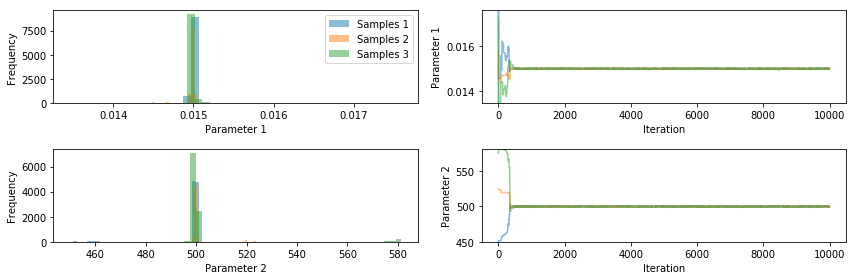

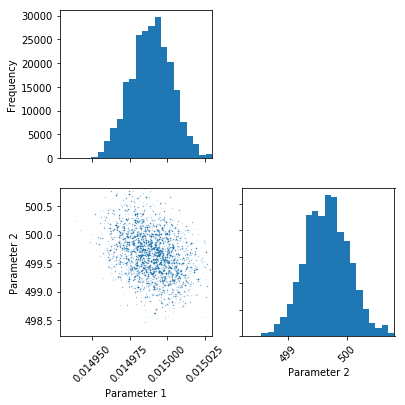

In [24]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

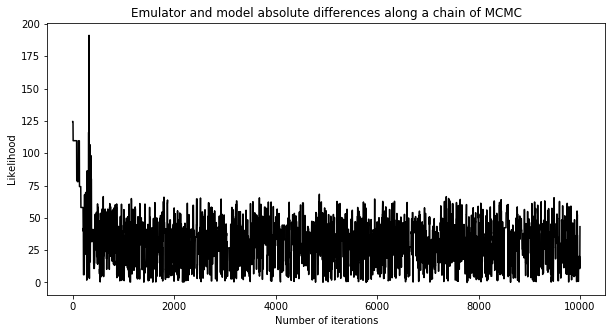

43.14704348502005

In [25]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

Running...
[1.84192531e-02 4.48062636e+02]
-24671.439453125


[2.24170286e-02 5.23120789e+02]
-inf


[2.09263831e-02 5.73608352e+02]
-inf


[4.14630722e-03 4.49580911e+02]
-inf


[2.81521549e-02 5.21926576e+02]
-inf


[-1.27467214e-02  5.77741351e+02]
-inf


[1.18323043e-02 4.52658736e+02]
-62027.203125


[1.43217143e-02 5.27525146e+02]
-4222.62109375
accepted


[2.40444992e-02 5.71310985e+02]
-inf


[1.35593330e-02 4.50101941e+02]
-23561.103515625
accepted


[2.62732832e-02 5.27457015e+02]
-inf


[1.15179954e-02 5.73061199e+02]
-51767.0390625
accepted


[1.14726136e-02 4.52619511e+02]
-75167.03125


[5.85573986e-04 5.25654401e+02]
-inf


[2.77609123e-02 5.73351644e+02]
-inf


[2.29160346e-02 4.53448637e+02]
-inf


[1.33773434e-02 5.28135888e+02]
-10086.166015625


[8.61485743e-03 5.71361379e+02]
-inf


[1.82249318e-02 4.48020183e+02]
-22952.287109375
accepted


[5.33960162e-03 5.31517623e+02]
-inf


[2.61638392e-02 5.71616111e+02]
-inf


[2.60630913e-02 4.46453404e+02]
-inf


[1.27877

[6.84032752e-03 4.52138621e+02]
-inf


[1.29329351e-02 5.23896567e+02]
-15740.076171875


[8.53816340e-03 5.72913588e+02]
-inf


[1.44709002e-02 4.51801848e+02]
-13433.546875


[9.73049553e-03 5.23111799e+02]
-inf


[3.94673882e-04 5.66547357e+02]
-inf


[2.04822505e-02 4.48784290e+02]
-inf


[-2.89789659e-03  5.22379306e+02]
-inf


[3.06511884e-02 5.69473050e+02]
-inf


[-3.36015562e-03  4.48038678e+02]
-inf


[3.08059118e-02 5.28414211e+02]
-inf


[9.42250543e-03 5.70542160e+02]
-inf


[1.26803331e-02 4.50567994e+02]
-39418.203125


[2.02665194e-03 5.24553913e+02]
-inf


[1.81479165e-02 5.68761571e+02]
-64983.69140625


[2.42622881e-02 4.50838909e+02]
-inf


[9.26337059e-03 5.23978157e+02]
-inf


[1.39934326e-02 5.73607203e+02]
-19393.7734375


[7.90214982e-03 4.49289061e+02]
-inf


[4.50817736e-03 5.22161090e+02]
-inf


[-9.48740388e-03  5.71000310e+02]
-inf


[2.26295106e-02 4.46374174e+02]
-inf


[3.13533278e-02 5.21320650e+02]
-inf


[2.23237877e-02 5.68676110e+02]
-inf


[1.1099



[1.58358629e-02 4.50074855e+02]
-10282.353515625


[1.48658254e-02 5.20441572e+02]
-2895.640380859375


[1.39677886e-02 5.69421971e+02]
-17451.130859375
accepted


[1.53763215e-02 4.50172267e+02]
-10248.525390625


[1.45004947e-02 5.20350259e+02]
-2822.261474609375


[1.39023932e-02 5.69389770e+02]
-17445.318359375
accepted


[1.55164068e-02 4.50041402e+02]
-10060.451171875


[1.45876934e-02 5.20378114e+02]
-2785.913818359375
accepted


[1.37290721e-02 5.69365944e+02]
-17880.154296875


[1.56030193e-02 4.50161636e+02]
-10013.90234375
accepted


[1.4592333e-02 5.2028240e+02]
-2781.753662109375
accepted


[1.35776251e-02 5.69343499e+02]
-18353.435546875


[1.55172002e-02 4.50156831e+02]
-10015.32421875


[1.46553055e-02 5.20268546e+02]
-2827.683349609375


[1.38998229e-02 5.69377385e+02]
-17443.197265625
accepted


[1.57520070e-02 4.50086189e+02]
-10183.220703125


[1.49287491e-02 5.20288246e+02]
-2841.277099609375


[1.37434366e-02 5.69366109e+02]
-17828.17578125


[1.54360031e-02 4.5

[1.55415204e-02 4.50260164e+02]
-9967.318359375
accepted


[1.46015455e-02 5.20285298e+02]
-2794.507568359375


[1.44253911e-02 5.66656286e+02]
-16720.416015625


[1.55431527e-02 4.50285537e+02]
-9958.26171875
accepted


[1.45778850e-02 5.20292053e+02]
-2779.991943359375


[1.43140435e-02 5.67198629e+02]
-16714.833984375


[1.55403482e-02 4.50273884e+02]
-9962.9140625


[1.45935026e-02 5.20298399e+02]
-2784.581787109375


[1.44197444e-02 5.66386461e+02]
-16574.72265625
accepted


[1.55400388e-02 4.50232794e+02]
-9977.083984375


[1.45876362e-02 5.20280443e+02]
-2778.960693359375
accepted


[1.43972821e-02 5.66480129e+02]
-16558.3984375
accepted


[1.55534480e-02 4.50347934e+02]
-9934.48828125
accepted


[1.45959514e-02 5.20282899e+02]
-2786.714599609375


[1.43202622e-02 5.66839689e+02]
-16559.46875


[1.55645402e-02 4.50338367e+02]
-9935.23046875


[1.45892053e-02 5.20276646e+02]
-2779.152099609375
accepted


[1.43582005e-02 5.66852184e+02]
-16643.330078125


[1.55451091e-02 4.5035895

[1.57469193e-02 4.67865112e+02]
-5080.09375


[1.45800281e-02 5.20101597e+02]
-2764.144287109375


[1.46717099e-02 5.62717100e+02]
-15887.185546875


[1.60562976e-02 4.96308560e+02]
-3952.488037109375


[1.45765270e-02 5.20156144e+02]
-2767.835693359375


[1.44603007e-02 5.65135080e+02]
-16073.55078125


[1.57538215e-02 4.68374742e+02]
-4968.33984375


[1.45649707e-02 5.19834648e+02]
-2742.656005859375
accepted


[1.46438216e-02 5.63103305e+02]
-15879.298828125


[1.60976834e-02 4.99328925e+02]
-4450.484375


[1.45705180e-02 5.19857266e+02]
-2745.320068359375


[1.45590400e-02 5.63288079e+02]
-15532.162109375
accepted


[1.60397336e-02 4.94771375e+02]
-3785.921630859375


[1.45564859e-02 5.19861033e+02]
-2746.874755859375


[1.45859111e-02 5.62855327e+02]
-15469.705078125
accepted


[1.61311810e-02 5.01604806e+02]
-4921.05078125


[1.45484807e-02 5.19400120e+02]
-2709.738037109375
accepted


[1.44164977e-02 5.64557589e+02]
-15710.279296875


[1.62231123e-02 5.10903357e+02]
-7028.214843

[1.60025402e-02 4.91329677e+02]
-3555.890380859375


[1.43715747e-02 5.13392601e+02]
-2510.656005859375


[1.63693677e-02 4.78909746e+02]
-5600.72265625


[1.59282424e-02 4.83947135e+02]
-3318.679443359375


[1.43186219e-02 5.11265558e+02]
-2519.023193359375


[1.47735145e-02 5.45954904e+02]
-8970.90234375


[1.59569407e-02 4.87173395e+02]
-3324.800537109375


[1.44181248e-02 5.14319888e+02]
-2462.363037109375
accepted


[1.45577735e-02 5.48316689e+02]
-9402.953125


[1.59228010e-02 4.84380471e+02]
-3272.640380859375
accepted


[1.44112235e-02 5.14682602e+02]
-2495.620849609375


[1.55604655e-02 5.20374446e+02]
-4731.1640625


[1.59420369e-02 4.86665848e+02]
-3268.870849609375
accepted


[1.45232692e-02 5.17618199e+02]
-2587.628662109375


[1.49476707e-02 5.43916986e+02]
-8817.3515625


[1.59989644e-02 4.92443630e+02]
-3565.663818359375


[1.44250799e-02 5.14178053e+02]
-2442.534912109375
accepted


[1.63080306e-02 4.88414864e+02]
-5048.875


[1.59203921e-02 4.84679568e+02]
-3248.60131

[1.50480242e-02 5.04648171e+02]
-1240.8590087890625
accepted


[1.44268694e-02 5.12440139e+02]
-2256.265380859375


[1.49471380e-02 5.09886422e+02]
-1468.1558837890625


[1.53232738e-02 5.00830664e+02]
-1631.3746337890625


[1.46728821e-02 5.08999616e+02]
-1548.0621337890625


[1.53589944e-02 5.04644290e+02]
-1974.2418212890625


[1.48600730e-02 5.08860692e+02]
-1359.2144775390625


[1.47066588e-02 5.07230183e+02]
-1408.6246337890625


[1.46204688e-02 4.95182524e+02]
-1978.8121337890625


[1.48076312e-02 5.15819939e+02]
-2119.241943359375


[1.48667053e-02 5.04436165e+02]
-1156.9683837890625


[1.48236143e-02 5.03997456e+02]
-1195.9527587890625


[1.51984257e-02 4.98588508e+02]
-1391.6363525390625


[1.51951285e-02 4.99782752e+02]
-1405.1832275390625


[1.45825763e-02 5.00105251e+02]
-1833.9644775390625


[1.43735336e-02 5.18096611e+02]
-2767.847412109375


[1.46340982e-02 5.07248122e+02]
-1543.4566650390625


[1.50825411e-02 5.14176156e+02]
-2089.179443359375


[1.51808950e-02 5.00118

[1.48240555e-02 5.03843292e+02]
-1203.0465087890625


[1.50950946e-02 5.02247205e+02]
-1340.1285400390625


[1.48509399e-02 5.05306817e+02]
-1146.0855712890625


[1.50051695e-02 5.00924462e+02]
-1167.1324462890625


[1.48602403e-02 5.06186711e+02]
-1164.0308837890625


[1.48570528e-02 5.06863963e+02]
-1209.3511962890625


[1.51766768e-02 4.99956291e+02]
-1384.3472900390625


[1.49342749e-02 5.05421288e+02]
-1148.2847900390625


[1.49103278e-02 5.01350729e+02]
-1200.5699462890625


[1.50837648e-02 5.02120524e+02]
-1313.8043212890625


[1.49074637e-02 5.06716186e+02]
-1202.0230712890625


[1.51198952e-02 4.99717076e+02]
-1310.1207275390625


[1.48336174e-02 5.05334364e+02]
-1148.9527587890625


[1.51019784e-02 5.02076948e+02]
-1363.1285400390625


[1.48366507e-02 5.06238823e+02]
-1171.2301025390625


[1.51317400e-02 5.00167947e+02]
-1339.0035400390625


[1.48776781e-02 5.05287034e+02]
-1143.6090087890625


[1.49122430e-02 5.07643999e+02]
-1269.1910400390625


[1.49631361e-02 5.00323183e+

[1.49832088e-02 5.02012930e+02]
-1136.1988525390625
accepted


[1.49403816e-02 5.04532868e+02]
-1148.3160400390625


[1.49737661e-02 5.02863727e+02]
-1140.4957275390625


[1.49933312e-02 5.01738601e+02]
-1144.4371337890625


[1.49244668e-02 5.05177672e+02]
-1144.3629150390625


[1.49492568e-02 5.02958808e+02]
-1142.7144775390625


[1.49332952e-02 5.02429404e+02]
-1152.5269775390625


[1.49033229e-02 5.05774667e+02]
-1155.8004150390625


[1.49975869e-02 5.02036307e+02]
-1150.0347900390625


[1.50207425e-02 5.02439117e+02]
-1185.7027587890625


[1.48707597e-02 5.05449831e+02]
-1143.7691650390625


[1.50047551e-02 5.02700859e+02]
-1163.4918212890625


[1.50178256e-02 5.01761680e+02]
-1178.7730712890625


[1.48756772e-02 5.05605552e+02]
-1143.8941650390625


[1.49420113e-02 5.02291388e+02]
-1147.4449462890625


[1.49991710e-02 5.02055106e+02]
-1152.4605712890625


[1.48541090e-02 5.06725888e+02]
-1199.1949462890625


[1.49653029e-02 5.03291787e+02]
-1143.3941650390625


[1.49687306e-02 5.0

[1.49980565e-02 5.02052447e+02]
-1150.8394775390625


[1.48966283e-02 5.05007749e+02]
-1138.8316650390625


[1.49848600e-02 5.01446604e+02]
-1140.7808837890625


[1.49894198e-02 5.02076187e+02]
-1137.7730712890625


[1.49269436e-02 5.03895557e+02]
-1146.4019775390625


[1.49903005e-02 5.01672895e+02]
-1141.2691650390625


[1.49985690e-02 5.02363854e+02]
-1152.7496337890625


[1.49037027e-02 5.04552018e+02]
-1138.0074462890625


[1.49932387e-02 5.01224190e+02]
-1150.8472900390625


[1.50211713e-02 5.01861198e+02]
-1184.1285400390625


[1.48978831e-02 5.04741226e+02]
-1137.9722900390625


[1.49895388e-02 5.01438159e+02]
-1143.6441650390625


[1.49897894e-02 5.01916397e+02]
-1139.0504150390625


[1.49057453e-02 5.04719131e+02]
-1137.8863525390625
accepted


[1.49750716e-02 5.02498004e+02]
-1137.6207275390625


[1.49627383e-02 5.02388294e+02]
-1139.4488525390625


[1.48888771e-02 5.04747647e+02]
-1142.5386962890625


[1.49805212e-02 5.01427272e+02]
-1143.2613525390625


[1.49990741e-02 5.0

[1.49897451e-02 5.02368489e+02]
-1138.7105712890625


[1.49145815e-02 5.04551296e+02]
-1141.5035400390625


[1.49804438e-02 5.01862870e+02]
-1137.7613525390625
accepted


[1.49931225e-02 5.02362215e+02]
-1144.2144775390625


[1.49218544e-02 5.04649339e+02]
-1143.4019775390625


[1.49869829e-02 5.01329719e+02]
-1142.5230712890625


[1.49818194e-02 5.02463422e+02]
-1136.9293212890625
accepted


[1.49251640e-02 5.04240246e+02]
-1147.1011962890625


[1.49725499e-02 5.01880585e+02]
-1139.6402587890625


[1.49811707e-02 5.02319647e+02]
-1136.1754150390625
accepted


[1.48995945e-02 5.04815114e+02]
-1138.0504150390625
accepted


[1.49681328e-02 5.02379261e+02]
-1138.0035400390625
accepted


[1.49709691e-02 5.02770457e+02]
-1139.9449462890625


[1.48969077e-02 5.04842408e+02]
-1138.0269775390625
accepted


[1.49668699e-02 5.02426500e+02]
-1138.1480712890625
accepted


[1.49776180e-02 5.02201821e+02]
-1136.4722900390625


[1.4892095e-02 5.0481359e+02]
-1140.1597900390625


[1.49688961e-02 5.022

[1.49837103e-02 5.01855883e+02]
-1136.9683837890625


[1.48977037e-02 5.04666393e+02]
-1138.8238525390625
accepted


[1.49779645e-02 5.02299334e+02]
-1136.1910400390625
accepted


[1.49875318e-02 5.01851312e+02]
-1136.6402587890625
accepted


[1.49093712e-02 5.04051382e+02]
-1144.3629150390625


[1.49849542e-02 5.02211453e+02]
-1135.5582275390625
accepted


[1.49868367e-02 5.01721572e+02]
-1136.8590087890625
accepted


[1.48998116e-02 5.04920636e+02]
-1138.3394775390625
accepted


[1.49835699e-02 5.02335958e+02]
-1136.1636962890625
accepted


[1.49968330e-02 5.01647284e+02]
-1149.2105712890625


[1.49140124e-02 5.04348157e+02]
-1142.3590087890625


[1.49896417e-02 5.02124595e+02]
-1138.2183837890625


[1.49835312e-02 5.02008076e+02]
-1136.1480712890625
accepted


[1.49027353e-02 5.04837924e+02]
-1138.1285400390625
accepted


[1.49981066e-02 5.02044476e+02]
-1150.8199462890625


[1.49897685e-02 5.01755858e+02]
-1140.0543212890625
accepted


[1.48943534e-02 5.05036460e+02]
-1138.94104003

[1.49737548e-02 5.02342487e+02]
-1136.6285400390625
accepted


[1.49730388e-02 5.02454381e+02]
-1137.3785400390625


[1.4879649e-02 5.0513608e+02]
-1143.8316650390625


[1.49785299e-02 5.02406306e+02]
-1136.7144775390625
accepted


[1.49825348e-02 5.02380458e+02]
-1136.4097900390625
accepted


[1.48914568e-02 5.04941518e+02]
-1139.2574462890625
accepted


[1.49775003e-02 5.02112863e+02]
-1137.0230712890625
accepted


[1.49785315e-02 5.02537759e+02]
-1137.7340087890625


[1.48956952e-02 5.04915786e+02]
-1138.2027587890625
accepted


[1.49839900e-02 5.02022237e+02]
-1135.9449462890625
accepted


[1.49777960e-02 5.02402331e+02]
-1136.7144775390625
accepted


[1.48939322e-02 5.04729324e+02]
-1140.1441650390625


[1.49903844e-02 5.01943465e+02]
-1139.5855712890625


[1.49736686e-02 5.02368289e+02]
-1136.7027587890625
accepted


[1.48950755e-02 5.04817875e+02]
-1138.6168212890625
accepted


[1.49797564e-02 5.01992289e+02]
-1137.1519775390625


[1.49710297e-02 5.02283736e+02]
-1137.6519775390

[1.49903012e-02 5.02035668e+02]
-1139.1519775390625


[1.49048219e-02 5.04772808e+02]
-1138.0113525390625
accepted


[1.49908446e-02 5.02124737e+02]
-1140.1636962890625


[1.49828183e-02 5.02077920e+02]
-1135.9254150390625
accepted


[1.48997509e-02 5.05101182e+02]
-1139.8238525390625


[1.49874603e-02 5.02517607e+02]
-1137.0035400390625


[1.49743742e-02 5.02302239e+02]
-1136.6949462890625


[1.49059503e-02 5.04915383e+02]
-1138.6285400390625


[1.49784370e-02 5.02284384e+02]
-1136.1324462890625
accepted


[1.49774888e-02 5.02333423e+02]
-1136.3746337890625
accepted


[1.49124745e-02 5.04568671e+02]
-1140.7301025390625


[1.49764665e-02 5.02448580e+02]
-1137.1676025390625
accepted


[1.49824705e-02 5.02426981e+02]
-1136.6285400390625
accepted


[1.49068810e-02 5.04685661e+02]
-1138.3316650390625


[1.49715088e-02 5.02560138e+02]
-1138.3472900390625


[1.49844310e-02 5.02481258e+02]
-1136.9449462890625
accepted


[1.49136107e-02 5.05310163e+02]
-1142.4136962890625


[1.49769380e-02 5.0

[1.49780352e-02 5.02102019e+02]
-1136.9410400390625


[1.49153759e-02 5.04666781e+02]
-1141.1715087890625


[1.49874709e-02 5.02059592e+02]
-1134.9019775390625
accepted


[1.49873911e-02 5.02410035e+02]
-1136.3785400390625
accepted


[1.48994441e-02 5.04725436e+02]
-1137.8004150390625
accepted


[1.49862167e-02 5.01870800e+02]
-1136.3121337890625


[1.49689849e-02 5.02660079e+02]
-1139.1949462890625


[1.49011898e-02 5.04323376e+02]
-1141.6363525390625


[1.49883007e-02 5.02126862e+02]
-1136.0582275390625


[1.49762352e-02 5.02442954e+02]
-1137.1402587890625


[1.49031955e-02 5.04945700e+02]
-1138.7574462890625
accepted


[1.49961943e-02 5.01808060e+02]
-1147.4371337890625


[1.49819867e-02 5.02485456e+02]
-1137.1090087890625
accepted


[1.49170346e-02 5.04688102e+02]
-1141.6129150390625


[1.49947316e-02 5.02165036e+02]
-1146.3511962890625


[1.49917589e-02 5.02875281e+02]
-1144.0777587890625


[1.48838153e-02 5.05738778e+02]
-1152.1636962890625


[1.49823372e-02 5.02145833e+02]
-1135

[1.49853937e-02 5.02190635e+02]
-1135.4058837890625
accepted


[1.4924035e-02 5.0424099e+02]
-1146.6558837890625


[1.49772804e-02 5.02480565e+02]
-1137.3355712890625


[1.49773365e-02 5.02081540e+02]
-1137.2183837890625


[1.49079089e-02 5.05003486e+02]
-1139.5035400390625


[1.49845087e-02 5.02211988e+02]
-1135.5386962890625
accepted


[1.49970781e-02 5.01840955e+02]
-1148.5465087890625


[1.49252858e-02 5.04491370e+02]
-1145.4176025390625


[1.49913647e-02 5.02143876e+02]
-1141.0308837890625


[1.49944559e-02 5.02586172e+02]
-1146.8980712890625


[1.49064833e-02 5.04783092e+02]
-1138.0269775390625


[1.49865886e-02 5.02112352e+02]
-1135.0738525390625
accepted


[1.49870098e-02 5.02293802e+02]
-1135.8629150390625


[1.49043641e-02 5.05059812e+02]
-1139.7144775390625
accepted


[1.49814744e-02 5.02380842e+02]
-1136.4097900390625


[1.49866655e-02 5.02166236e+02]
-1135.2965087890625
accepted


[1.49021204e-02 5.05732082e+02]
-1153.5113525390625


[1.49903064e-02 5.01976620e+02]
-1139.2

[1.49664771e-02 5.03043612e+02]
-1142.3394775390625


[1.49131594e-02 5.03607944e+02]
-1150.2301025390625


[1.49882463e-02 5.02286539e+02]
-1136.1676025390625
accepted


[1.49726224e-02 5.02640741e+02]
-1138.8668212890625


[1.49030466e-02 5.04483212e+02]
-1138.5855712890625


[1.49883373e-02 5.02317822e+02]
-1136.3472900390625


[1.49790716e-02 5.02719636e+02]
-1139.1011962890625


[1.49233998e-02 5.04365580e+02]
-1145.5699462890625


[1.49864763e-02 5.02145818e+02]
-1135.2027587890625
accepted


[1.49777994e-02 5.02790263e+02]
-1139.7105712890625


[1.49062995e-02 5.04144866e+02]
-1143.3121337890625


[1.49771384e-02 5.02742941e+02]
-1139.3824462890625


[1.49761185e-02 5.02126731e+02]
-1137.2457275390625
accepted


[1.49056226e-02 5.04457602e+02]
-1139.0816650390625
accepted


[1.49911703e-02 5.02324470e+02]
-1140.9722900390625


[1.49757321e-02 5.01745341e+02]
-1140.4058837890625


[1.49093264e-02 5.04313013e+02]
-1141.0113525390625
accepted


[1.49853373e-02 5.02662414e+02]
-1138

[1.49875584e-02 5.02010256e+02]
-1135.3043212890625
accepted


[1.49140988e-02 5.04951536e+02]
-1140.2183837890625


[1.49770007e-02 5.02803335e+02]
-1139.8394775390625


[1.49955330e-02 5.02201728e+02]
-1147.6558837890625


[1.48888301e-02 5.05314251e+02]
-1141.1051025390625


[1.49792945e-02 5.02905535e+02]
-1140.4840087890625


[1.49859540e-02 5.01853041e+02]
-1136.4254150390625


[1.49050166e-02 5.05496141e+02]
-1143.5152587890625


[1.49736722e-02 5.02701334e+02]
-1139.2847900390625


[1.49933586e-02 5.01754724e+02]
-1144.3433837890625


[1.49024324e-02 5.05614008e+02]
-1147.0113525390625


[1.49751042e-02 5.03102558e+02]
-1142.2574462890625


[1.49929827e-02 5.02264357e+02]
-1143.8277587890625


[1.49184138e-02 5.04478824e+02]
-1143.1402587890625


[1.49865871e-02 5.03119332e+02]
-1141.6988525390625
accepted


[1.49931716e-02 5.01629374e+02]
-1144.9683837890625


[1.49282544e-02 5.04646379e+02]
-1145.5152587890625


[1.49867357e-02 5.02382291e+02]
-1136.2574462890625
accepted


[

-1162.1480712890625


[1.49906259e-02 5.02165719e+02]
-1139.8707275390625
accepted


[1.48986758e-02 5.04960596e+02]
-1138.5699462890625
accepted


[1.49815620e-02 5.02337947e+02]
-1136.2496337890625


[1.49905269e-02 5.01647133e+02]
-1141.6636962890625


[1.49015622e-02 5.04990392e+02]
-1139.0465087890625
accepted


[1.50018561e-02 5.02182571e+02]
-1156.9176025390625


[1.49990151e-02 5.01910328e+02]
-1151.7144775390625


[1.49004826e-02 5.04441737e+02]
-1139.9332275390625
accepted


[1.49522319e-02 5.02511421e+02]
-1141.7496337890625


[1.49964673e-02 5.02124571e+02]
-1148.7457275390625


[1.49160441e-02 5.03749954e+02]
-1147.3394775390625


[1.49790556e-02 5.01617494e+02]
-1141.0465087890625


[1.49929331e-02 5.02234851e+02]
-1143.7379150390625


[1.49223668e-02 5.04075975e+02]
-1147.1129150390625


[1.49924252e-02 5.02586940e+02]
-1143.7105712890625


[1.49898398e-02 5.02416836e+02]
-1138.9566650390625
accepted


[1.49164263e-02 5.04699440e+02]
-1141.3941650390625


[1.49720620e-02

-1138.2105712890625


[1.49969562e-02 5.02295733e+02]
-1150.1011962890625


[1.49037060e-02 5.04167194e+02]
-1143.5855712890625


[1.49827361e-02 5.02557680e+02]
-1137.6168212890625


[1.49932106e-02 5.02422494e+02]
-1144.4058837890625


[1.49052897e-02 5.04710339e+02]
-1137.8785400390625
accepted


[1.49786987e-02 5.02230349e+02]
-1136.0543212890625


[1.49828799e-02 5.01946029e+02]
-1136.6949462890625


[1.48985935e-02 5.05147311e+02]
-1140.1480712890625


[1.49951991e-02 5.01849609e+02]
-1145.9605712890625


[1.49904329e-02 5.02389006e+02]
-1139.8863525390625


[1.48905025e-02 5.05231601e+02]
-1140.4605712890625


[1.49885624e-02 5.02221301e+02]
-1136.5660400390625


[1.49856386e-02 5.02692525e+02]
-1138.4605712890625


[1.48956538e-02 5.05588069e+02]
-1146.4957275390625


[1.49865540e-02 5.02430196e+02]
-1136.4879150390625


[1.49815011e-02 5.02332127e+02]
-1136.2222900390625
accepted


[1.49132238e-02 5.04324770e+02]
-1142.1988525390625


[1.49855461e-02 5.02350841e+02]
-1136.1676

[1.49888138e-02 5.02545477e+02]
-1137.6988525390625


[1.48838616e-02 5.06039383e+02]
-1165.2066650390625


[1.49882357e-02 5.00842544e+02]
-1149.4488525390625


[1.49808837e-02 5.01918951e+02]
-1137.2926025390625
accepted


[1.49269926e-02 5.04340445e+02]
-1147.0816650390625


[1.49791114e-02 5.01551544e+02]
-1141.9722900390625


[1.49828716e-02 5.01828403e+02]
-1137.3590087890625
accepted


[1.49172453e-02 5.04741665e+02]
-1141.4136962890625


[1.49741366e-02 5.01492478e+02]
-1144.6949462890625


[1.49756335e-02 5.02083786e+02]
-1137.6793212890625
accepted


[1.48942629e-02 5.04982494e+02]
-1138.4722900390625
accepted


[1.50048705e-02 5.02002717e+02]
-1160.6402587890625


[1.49869051e-02 5.01554580e+02]
-1139.0426025390625


[1.48863247e-02 5.05297687e+02]
-1140.8277587890625


[1.49777226e-02 5.01701835e+02]
-1140.3199462890625
accepted


[1.49693797e-02 5.02287937e+02]
-1138.0465087890625
accepted


[1.49198404e-02 5.04250045e+02]
-1145.1011962890625


[1.49814040e-02 5.01875225e+

[1.49915802e-02 5.01402448e+02]
-1146.3941650390625


[1.49076562e-02 5.04437323e+02]
-1139.8082275390625


[1.49648243e-02 5.01725670e+02]
-1144.8160400390625


[1.49855027e-02 5.01972336e+02]
-1135.8511962890625
accepted


[1.48857381e-02 5.05617907e+02]
-1147.3472900390625


[1.49689641e-02 5.01667506e+02]
-1144.0894775390625


[1.49882816e-02 5.02345524e+02]
-1136.2965087890625
accepted


[1.49089674e-02 5.04584966e+02]
-1139.5426025390625


[1.49950410e-02 5.02750304e+02]
-1148.6988525390625


[1.49974490e-02 5.02193365e+02]
-1150.4722900390625


[1.48976493e-02 5.04842119e+02]
-1138.0504150390625
accepted


[1.49621041e-02 5.02174576e+02]
-1140.4449462890625
accepted


[1.49998516e-02 5.02205648e+02]
-1154.0504150390625


[1.48926923e-02 5.04836680e+02]
-1139.6754150390625


[1.49361364e-02 5.01774135e+02]
-1166.0660400390625


[1.49896286e-02 5.02606068e+02]
-1139.3199462890625


[1.49033378e-02 5.05263753e+02]
-1141.4097900390625


[1.49547245e-02 5.03135411e+02]
-1143.23010253

[1.49820636e-02 5.01986406e+02]
-1136.6715087890625


[1.49302469e-02 5.04605582e+02]
-1146.4215087890625


[1.50096389e-02 5.01817306e+02]
-1166.9605712890625


[1.50012545e-02 5.02330133e+02]
-1156.5816650390625


[1.49182881e-02 5.05058471e+02]
-1141.8980712890625


[1.49777508e-02 5.02003130e+02]
-1137.6090087890625


[1.49678195e-02 5.02594036e+02]
-1138.7926025390625


[1.49288512e-02 5.04418054e+02]
-1147.1871337890625


[1.49740302e-02 5.01575921e+02]
-1143.5660400390625


[1.49916672e-02 5.01878955e+02]
-1141.5699462890625


[1.49356109e-02 5.04534454e+02]
-1148.2457275390625


[1.49727957e-02 5.03084485e+02]
-1142.2379150390625


[1.49863033e-02 5.02108856e+02]
-1135.0152587890625
accepted


[1.49046027e-02 5.04016596e+02]
-1145.9879150390625


[1.49944085e-02 5.02327868e+02]
-1146.2066650390625


[1.49747594e-02 5.02162828e+02]
-1137.4488525390625


[1.4914682e-02 5.0465581e+02]
-1141.0347900390625


[1.49706602e-02 5.02151864e+02]
-1138.4996337890625


[1.49887901e-02 5.028

[1.49965243e-02 5.01505474e+02]
-1150.0816650390625


[1.49119408e-02 5.04166937e+02]
-1142.7965087890625
accepted


[1.49769457e-02 5.02118136e+02]
-1137.1168212890625
accepted


[1.49903921e-02 5.01216383e+02]
-1147.9019775390625


[1.49209681e-02 5.04081188e+02]
-1146.6402587890625


[1.49391623e-02 5.02507481e+02]
-1146.3746337890625


[1.49784429e-02 5.02097372e+02]
-1136.9058837890625


[1.49225154e-02 5.04648843e+02]
-1143.6324462890625


[1.49654931e-02 5.02211590e+02]
-1139.4449462890625


[1.50009532e-02 5.01909832e+02]
-1154.5269775390625


[1.49240083e-02 5.04240577e+02]
-1146.6988525390625


[1.49775442e-02 5.02374214e+02]
-1136.5582275390625
accepted


[1.50036190e-02 5.01023283e+02]
-1163.5699462890625


[1.48908888e-02 5.04909558e+02]
-1139.8238525390625
accepted


[1.50102138e-02 5.02337426e+02]
-1169.8199462890625


[1.50028847e-02 5.02280246e+02]
-1158.7886962890625


[1.49226552e-02 5.03559058e+02]
-1145.4683837890625


[1.49943456e-02 5.02378180e+02]
-1146.22619628

[1.49831704e-02 5.02804518e+02]
-1139.4761962890625
accepted


[1.49109062e-02 5.04995507e+02]
-1139.6051025390625


[1.49778259e-02 5.02657083e+02]
-1138.6676025390625


[1.49843964e-02 5.03789708e+02]
-1144.4488525390625


[1.49233197e-02 5.04771051e+02]
-1143.6949462890625


[1.49597348e-02 5.02183516e+02]
-1141.0230712890625


[1.49809233e-02 5.01683281e+02]
-1139.3785400390625
accepted


[1.49054226e-02 5.04898815e+02]
-1138.4605712890625
accepted


[1.49761842e-02 5.02339562e+02]
-1136.4254150390625
accepted


[1.49778420e-02 5.01552771e+02]
-1142.3785400390625


[1.48888566e-02 5.05340279e+02]
-1141.3199462890625


[1.49755543e-02 5.02089598e+02]
-1137.6480712890625
accepted


[1.49820008e-02 5.02454339e+02]
-1136.8551025390625
accepted


[1.49153304e-02 5.05048868e+02]
-1140.8004150390625


[1.49945582e-02 5.01600515e+02]
-1146.7886962890625


[1.49843780e-02 5.02873368e+02]
-1139.9293212890625


[1.48858041e-02 5.05794890e+02]
-1155.2496337890625


[1.49671139e-02 5.02015260e+



[1.49916773e-02 5.01444169e+02]
-1145.7926025390625


[1.49939749e-02 5.03105663e+02]
-1148.8433837890625


[1.48883659e-02 5.04900455e+02]
-1141.2183837890625


[1.49751716e-02 5.01328656e+02]
-1146.7105712890625


[1.49910331e-02 5.02873192e+02]
-1142.9215087890625


[1.49008265e-02 5.04059227e+02]
-1146.1168212890625


[1.49884041e-02 5.01910620e+02]
-1137.2808837890625
accepted


[1.49879471e-02 5.02224967e+02]
-1135.5777587890625
accepted


[1.49211508e-02 5.04948098e+02]
-1142.9957275390625


[1.49987401e-02 5.01814767e+02]
-1150.9488525390625


[1.49877192e-02 5.02204044e+02]
-1135.3941650390625
accepted


[1.48979232e-02 5.04920891e+02]
-1138.2574462890625
accepted


[1.49827570e-02 5.01570287e+02]
-1140.2926025390625


[1.49900530e-02 5.02574513e+02]
-1139.8355712890625


[1.48894683e-02 5.05105798e+02]
-1139.2457275390625


[1.49980479e-02 5.02104701e+02]
-1150.9918212890625


[1.49755196e-02 5.02078468e+02]
-1137.7496337890625


[1.49041606e-02 5.04957559e+02]
-1138.874633

[1.49847037e-02 5.02058530e+02]
-1135.5660400390625
accepted


[1.48910912e-02 5.04549861e+02]
-1143.3277587890625


[1.49955170e-02 5.02644318e+02]
-1148.8590087890625


[1.49753070e-02 5.01954411e+02]
-1138.4761962890625


[1.48845267e-02 5.04392908e+02]
-1148.2808837890625


[1.49966696e-02 5.01971456e+02]
-1148.4254150390625


[1.49779173e-02 5.01540600e+02]
-1142.5933837890625


[1.49168530e-02 5.04624791e+02]
-1141.8980712890625


[1.49682459e-02 5.02025321e+02]
-1139.8160400390625


[1.49807050e-02 5.01602606e+02]
-1140.6246337890625


[1.48916000e-02 5.04535355e+02]
-1143.2457275390625


[1.50093659e-02 5.01983305e+02]
-1167.2144775390625


[1.49853950e-02 5.02500208e+02]
-1137.0191650390625
accepted


[1.49114199e-02 5.04338792e+02]
-1141.5777587890625


[1.49933078e-02 5.01928886e+02]
-1143.3511962890625


[1.49810303e-02 5.02354443e+02]
-1136.3472900390625
accepted


[1.49072360e-02 5.04157067e+02]
-1142.9332275390625


[1.49806679e-02 5.02296092e+02]
-1136.0816650390625
acc

[1.49880585e-02 5.02051728e+02]
-1135.5816650390625
accepted


[1.48939616e-02 5.05105855e+02]
-1139.4879150390625
accepted


[1.49748264e-02 5.01954305e+02]
-1138.5699462890625


[1.49970518e-02 5.01914118e+02]
-1148.7847900390625


[1.48971328e-02 5.04667640e+02]
-1139.0894775390625
accepted


[1.49867505e-02 5.01856275e+02]
-1136.2066650390625


[1.49894023e-02 5.01859605e+02]
-1138.9566650390625


[1.49047517e-02 5.04817050e+02]
-1138.1246337890625
accepted


[1.49688569e-02 5.02013685e+02]
-1139.7418212890625


[1.4988024e-02 5.0209357e+02]
-1135.5113525390625
accepted


[1.48981666e-02 5.04827092e+02]
-1138.0230712890625
accepted


[1.49892181e-02 5.01480989e+02]
-1142.5972900390625


[1.50075918e-02 5.02221731e+02]
-1165.5074462890625


[1.48938103e-02 5.04772165e+02]
-1139.7261962890625


[1.49888571e-02 5.01357832e+02]
-1144.1129150390625


[1.49884445e-02 5.02464085e+02]
-1136.7457275390625


[1.49370835e-02 5.04257344e+02]
-1147.2496337890625


[1.49806502e-02 5.02059864e+02

[1.49840634e-02 5.02271802e+02]
-1135.8277587890625


[1.48933214e-02 5.04422820e+02]
-1143.4840087890625


[1.49746085e-02 5.02292825e+02]
-1136.7261962890625
accepted


[1.49786823e-02 5.01826914e+02]
-1138.3746337890625


[1.49047505e-02 5.04429314e+02]
-1139.0504150390625


[1.49759946e-02 5.01966211e+02]
-1138.2613525390625


[1.49845710e-02 5.02407722e+02]
-1136.4605712890625


[1.49081213e-02 5.04900836e+02]
-1138.6676025390625


[1.49722310e-02 5.02368377e+02]
-1136.9019775390625
accepted


[1.49862146e-02 5.02095919e+02]
-1134.9840087890625
accepted


[1.48998476e-02 5.05300455e+02]
-1141.5582275390625


[1.49488133e-02 5.02599958e+02]
-1142.3629150390625


[1.49829455e-02 5.02281733e+02]
-1135.8941650390625
accepted


[1.49097534e-02 5.04401909e+02]
-1140.6988525390625


[1.49638520e-02 5.02587888e+02]
-1138.9996337890625


[1.49830817e-02 5.02483132e+02]
-1137.0074462890625
accepted


[1.49074482e-02 5.04839240e+02]
-1138.2301025390625
accepted


[1.49919574e-02 5.01709796e+


[1.49948066e-02 5.02039567e+02]
-1145.9761962890625


[1.49799407e-02 5.02592890e+02]
-1138.0465087890625


[1.49104114e-02 5.04691207e+02]
-1139.4371337890625


[1.49784775e-02 5.02416245e+02]
-1136.7769775390625
accepted


[1.49819618e-02 5.02768744e+02]
-1139.2926025390625


[1.49126850e-02 5.04883433e+02]
-1139.6285400390625


[1.49773167e-02 5.02275518e+02]
-1136.1597900390625
accepted


[1.49794861e-02 5.02725710e+02]
-1139.1090087890625


[1.49269957e-02 5.04751445e+02]
-1145.0660400390625


[1.49767844e-02 5.01771519e+02]
-1139.6363525390625


[1.49913603e-02 5.01879483e+02]
-1141.1910400390625


[1.49114674e-02 5.04481036e+02]
-1140.8355712890625


[1.49881678e-02 5.02240515e+02]
-1135.9879150390625
accepted


[1.49768766e-02 5.02009221e+02]
-1137.7847900390625
accepted


[1.49164676e-02 5.04480020e+02]
-1142.5113525390625


[1.49844639e-02 5.02046524e+02]
-1135.6793212890625
accepted


[1.49764237e-02 5.01874440e+02]
-1138.6988525390625
accepted


[1.49292861e-02 5.04440402e


[1.49723221e-02 5.01957650e+02]
-1139.2105712890625


[1.49769177e-02 5.02881016e+02]
-1140.4293212890625


[1.48953819e-02 5.04895370e+02]
-1138.1207275390625
accepted


[1.49962318e-02 5.01745782e+02]
-1147.8941650390625


[1.49950457e-02 5.02159820e+02]
-1146.7847900390625


[1.48883567e-02 5.04494592e+02]
-1145.3277587890625


[1.49749012e-02 5.01870721e+02]
-1139.0699462890625


[1.50097063e-02 5.01942560e+02]
-1167.5386962890625


[1.48949537e-02 5.05403198e+02]
-1142.1676025390625


[1.49739798e-02 5.01914320e+02]
-1139.0308837890625


[1.49831926e-02 5.02285577e+02]
-1135.9371337890625
accepted


[1.48811299e-02 5.05201071e+02]
-1142.7965087890625


[1.49750134e-02 5.01757506e+02]
-1140.5426025390625


[1.49828479e-02 5.02502269e+02]
-1137.1676025390625
accepted


[1.49023247e-02 5.05014900e+02]
-1139.2574462890625


[1.49963002e-02 5.01262642e+02]
-1153.5347900390625


[1.49778527e-02 5.02984812e+02]
-1141.1597900390625


[1.49192717e-02 5.05066107e+02]
-1142.2730712890625





[1.49953481e-02 5.02070380e+02]
-1146.9097900390625


[1.49009787e-02 5.04846729e+02]
-1138.1090087890625
accepted


[1.49889353e-02 5.01424478e+02]
-1143.1558837890625


[1.49788193e-02 5.01699304e+02]
-1139.9371337890625


[1.49203943e-02 5.05328575e+02]
-1143.0035400390625


[1.49580676e-02 5.03381783e+02]
-1143.8863525390625


[1.49801459e-02 5.02642542e+02]
-1138.4097900390625


[1.49070726e-02 5.04681895e+02]
-1138.4058837890625


[1.49946458e-02 5.01363339e+02]
-1150.2222900390625


[1.49777176e-02 5.01619451e+02]
-1141.4683837890625


[1.49213588e-02 5.04418077e+02]
-1144.4566650390625


[1.49991210e-02 5.01845206e+02]
-1151.5933837890625


[1.49968076e-02 5.01939561e+02]
-1148.5426025390625


[1.48974729e-02 5.04465232e+02]
-1140.9058837890625


[1.49895052e-02 5.02479967e+02]
-1138.4996337890625


[1.49709330e-02 5.03217512e+02]
-1143.0191650390625


[1.49120239e-02 5.04858279e+02]
-1139.3707275390625


[1.49747513e-02 5.02005872e+02]
-1138.3199462890625


[1.49949036e-02 5.

[1.49884350e-02 5.01982251e+02]
-1136.7222900390625


[1.49276639e-02 5.04697163e+02]
-1145.3238525390625


[1.49864253e-02 5.01963761e+02]
-1135.7027587890625
accepted


[1.49980074e-02 5.02924741e+02]
-1154.3043212890625


[1.49042751e-02 5.04205188e+02]
-1142.8355712890625


[1.49859245e-02 5.01772098e+02]
-1136.8902587890625


[1.49900463e-02 5.02819406e+02]
-1141.0855712890625


[1.48958122e-02 5.04283153e+02]
-1143.6715087890625


[1.4986227e-02 5.0128950e+02]
-1142.3433837890625


[1.49967109e-02 5.01038979e+02]
-1155.9879150390625


[1.49017740e-02 5.04966558e+02]
-1138.8199462890625
accepted


[1.50020486e-02 5.01931113e+02]
-1156.2340087890625


[1.49970207e-02 5.02076421e+02]
-1149.3980712890625


[1.48947623e-02 5.04863296e+02]
-1138.3160400390625
accepted


[1.50003565e-02 5.02269174e+02]
-1155.0465087890625


[1.50146800e-02 5.02287506e+02]
-1176.2144775390625


[1.49051117e-02 5.05004044e+02]
-1139.3472900390625


[1.49772478e-02 5.01775395e+02]
-1139.3980712890625


[1.

[1.49962925e-02 5.02176796e+02]
-1148.7027587890625


[1.49375203e-02 5.04430803e+02]
-1147.8707275390625


[1.49890987e-02 5.02767218e+02]
-1139.3433837890625


[1.49623743e-02 5.02625551e+02]
-1139.3707275390625


[1.48904832e-02 5.05276346e+02]
-1140.8316650390625


[1.49810275e-02 5.02304732e+02]
-1136.0933837890625
accepted


[1.49725695e-02 5.01405990e+02]
-1146.5426025390625


[1.48767035e-02 5.05188187e+02]
-1144.8277587890625


[1.49781408e-02 5.03006454e+02]
-1141.3355712890625


[1.49699498e-02 5.02305233e+02]
-1137.8238525390625


[1.48955078e-02 5.05373084e+02]
-1141.9527587890625


[1.49703482e-02 5.03350162e+02]
-1143.4410400390625


[1.49675697e-02 5.02109093e+02]
-1139.5308837890625


[1.49161168e-02 5.04437969e+02]
-1142.5777587890625


[1.49861352e-02 5.02091345e+02]
-1135.0269775390625
accepted


[1.50044649e-02 5.02121232e+02]
-1160.5308837890625


[1.49008071e-02 5.05412267e+02]
-1142.5426025390625


[1.49896376e-02 5.01535276e+02]
-1142.2105712890625


[1.4976807

[1.49802321e-02 5.02159873e+02]
-1136.0738525390625
accepted


[1.49917814e-02 5.01509883e+02]
-1144.9371337890625


[1.48784745e-02 5.05584940e+02]
-1144.2965087890625


[1.50017545e-02 5.02414251e+02]
-1157.6519775390625


[1.49837899e-02 5.01699515e+02]
-1138.0465087890625


[1.48903976e-02 5.05618153e+02]
-1147.8824462890625


[1.49821246e-02 5.03090850e+02]
-1141.7574462890625


[1.49825762e-02 5.02136714e+02]
-1135.6676025390625
accepted


[1.48909896e-02 5.05279212e+02]
-1140.8902587890625
accepted


[1.49570854e-02 5.02066957e+02]
-1142.7301025390625


[1.49801807e-02 5.01906692e+02]
-1137.5465087890625


[1.49043407e-02 5.04754819e+02]
-1137.9996337890625
accepted


[1.49684937e-02 5.02477698e+02]
-1137.8590087890625


[1.49717583e-02 5.02107907e+02]
-1138.4488525390625


[1.49349879e-02 5.04257738e+02]
-1147.2926025390625


[1.49799566e-02 5.02517379e+02]
-1137.4644775390625


[1.49686248e-02 5.02450347e+02]
-1137.6715087890625


[1.49185355e-02 5.04586167e+02]
-1142.62072753

[1.49852222e-02 5.01755923e+02]
-1137.1441650390625


[1.49200811e-02 5.04656286e+02]
-1142.7691650390625


[1.49957585e-02 5.02277216e+02]
-1148.2926025390625


[1.49818575e-02 5.02090844e+02]
-1136.0855712890625
accepted


[1.49024032e-02 5.04517935e+02]
-1138.2066650390625
accepted


[1.49847197e-02 5.01891226e+02]
-1136.4996337890625
accepted


[1.49816851e-02 5.01970156e+02]
-1136.8160400390625
accepted


[1.48947363e-02 5.04458742e+02]
-1142.4058837890625


[1.49854986e-02 5.01529665e+02]
-1139.4761962890625


[1.49744559e-02 5.02363922e+02]
-1136.6246337890625
accepted


[1.49110734e-02 5.04549670e+02]
-1140.3902587890625


[1.49723537e-02 5.02258669e+02]
-1137.4879150390625


[1.49552303e-02 5.02878749e+02]
-1141.7340087890625


[1.49216247e-02 5.04171222e+02]
-1146.2769775390625


[1.49793564e-02 5.01794088e+02]
-1138.3785400390625


[1.49822835e-02 5.02053980e+02]
-1136.2066650390625
accepted


[1.49152632e-02 5.04276832e+02]
-1143.2379150390625


[1.49756829e-02 5.02010650e+



[1.49520755e-02 5.05007508e+02]
-1152.9097900390625


[1.49921005e-02 5.02523296e+02]
-1142.8433837890625


[1.49988724e-02 5.02811200e+02]
-1155.0816650390625


[1.49336339e-02 5.04780729e+02]
-1147.7183837890625


[1.49906986e-02 5.02809630e+02]
-1142.0660400390625


[1.49842825e-02 5.03287917e+02]
-1142.8668212890625


[1.49263899e-02 5.05765858e+02]
-1154.0855712890625


[1.49742802e-02 5.02158738e+02]
-1137.5543212890625


[1.49781544e-02 5.02543363e+02]
-1137.7691650390625
accepted


[1.49001164e-02 5.05307221e+02]
-1141.6051025390625


[1.49980097e-02 5.01688276e+02]
-1150.3355712890625


[1.49560579e-02 5.02903870e+02]
-1141.9254150390625


[1.49014459e-02 5.05155270e+02]
-1140.3824462890625
accepted


[1.49781448e-02 5.02022364e+02]
-1137.3668212890625


[1.49776055e-02 5.02609123e+02]
-1138.3394775390625
accepted


[1.49059773e-02 5.04289485e+02]
-1140.9918212890625
accepted


[1.49911896e-02 5.01984098e+02]
-1140.4410400390625


[1.49940195e-02 5.02247577e+02]
-1145.452758

[1.49915144e-02 5.01661825e+02]
-1142.7574462890625


[1.49101442e-02 5.05422929e+02]
-1143.1480712890625


[1.49784783e-02 5.01997962e+02]
-1137.4176025390625


[1.49689542e-02 5.01913683e+02]
-1140.4840087890625


[1.49247364e-02 5.05406135e+02]
-1144.6129150390625


[1.49828345e-02 5.01765707e+02]
-1137.7183837890625


[1.49750620e-02 5.01385529e+02]
-1145.9176025390625


[1.49018562e-02 5.05577957e+02]
-1145.8590087890625


[1.49661147e-02 5.02549859e+02]
-1138.5777587890625


[1.49919429e-02 5.02759986e+02]
-1143.7691650390625


[1.49097335e-02 5.04220251e+02]
-1141.6051025390625
accepted


[1.49681443e-02 5.01881936e+02]
-1141.2535400390625


[1.49774242e-02 5.01863255e+02]
-1138.4683837890625


[1.49085623e-02 5.04421129e+02]
-1140.2144775390625
accepted


[1.49876204e-02 5.02031257e+02]
-1135.1597900390625
accepted


[1.49809285e-02 5.02577198e+02]
-1137.8746337890625


[1.49159322e-02 5.04371786e+02]
-1142.8004150390625


[1.49791663e-02 5.02877710e+02]
-1140.2769775390625


[

[1.48902704e-02 5.05179841e+02]
-1139.9722900390625
accepted


[1.49815735e-02 5.01398779e+02]
-1143.1988525390625


[1.49656190e-02 5.02966863e+02]
-1141.7769775390625


[1.48938690e-02 5.05023061e+02]
-1138.8238525390625
accepted


[1.49796797e-02 5.01658820e+02]
-1140.1871337890625


[1.49801278e-02 5.02967975e+02]
-1140.9215087890625


[1.49128755e-02 5.04254527e+02]
-1142.5543212890625


[1.49781588e-02 5.02629476e+02]
-1138.4293212890625


[1.49705694e-02 5.03218728e+02]
-1143.0074462890625


[1.48782334e-02 5.05702073e+02]
-1148.7926025390625


[1.49946515e-02 5.02065382e+02]
-1145.8863525390625


[1.49708403e-02 5.03165756e+02]
-1142.8707275390625


[1.48806318e-02 5.04977693e+02]
-1144.4996337890625


[1.49771681e-02 5.02540300e+02]
-1137.8238525390625


[1.49781536e-02 5.02612610e+02]
-1138.2965087890625


[1.48983909e-02 5.04762592e+02]
-1137.8668212890625
accepted


[1.49768633e-02 5.01719357e+02]
-1140.3980712890625


[1.49827062e-02 5.02774481e+02]
-1139.2652587890625


[

[1.49130108e-02 5.04548826e+02]
-1141.0152587890625


[1.49707211e-02 5.02812541e+02]
-1140.2926025390625


[1.49693075e-02 5.02196035e+02]
-1138.5738525390625
accepted


[1.48976380e-02 5.04858369e+02]
-1138.1246337890625
accepted


[1.49827647e-02 5.01886228e+02]
-1137.0386962890625
accepted


[1.49714717e-02 5.02904789e+02]
-1140.9605712890625


[1.49123292e-02 5.04328886e+02]
-1141.9293212890625


[1.49761717e-02 5.02131227e+02]
-1137.2496337890625
accepted


[1.49668500e-02 5.01999356e+02]
-1140.3082275390625


[1.49061371e-02 5.04407366e+02]
-1139.4957275390625
accepted


[1.49592147e-02 5.02653012e+02]
-1139.7574462890625


[1.49892368e-02 5.01587913e+02]
-1141.0191650390625


[1.49069189e-02 5.04146531e+02]
-1143.2066650390625


[1.49628899e-02 5.02152085e+02]
-1140.4332275390625


[1.49687538e-02 5.02077651e+02]
-1139.4293212890625
accepted


[1.48888109e-02 5.05037753e+02]
-1139.8316650390625
accepted


[1.49737383e-02 5.02122515e+02]
-1137.9136962890625


[1.49832723e-02 5.0

-1138.2496337890625


[1.49856957e-02 5.02402929e+02]
-1136.4410400390625
accepted


[1.48948866e-02 5.04744396e+02]
-1139.4488525390625
accepted


[1.49795395e-02 5.01964370e+02]
-1137.3785400390625


[1.49734913e-02 5.03291212e+02]
-1143.1949462890625


[1.48853824e-02 5.04576969e+02]
-1145.9761962890625


[1.49965403e-02 5.02092058e+02]
-1148.7769775390625


[1.49929591e-02 5.01588670e+02]
-1144.9918212890625


[1.48754005e-02 5.04807183e+02]
-1148.7847900390625


[1.49833480e-02 5.01994854e+02]
-1136.2691650390625
accepted


[1.49997117e-02 5.02435818e+02]
-1154.7379150390625


[1.49027690e-02 5.04532041e+02]
-1137.8590087890625
accepted


[1.49939674e-02 5.02020088e+02]
-1144.6441650390625


[1.49796334e-02 5.02643504e+02]
-1138.4683837890625


[1.49146323e-02 5.04835927e+02]
-1140.3785400390625


[1.49729215e-02 5.02209982e+02]
-1137.6246337890625


[1.49571388e-02 5.02348948e+02]
-1141.0191650390625


[1.48976278e-02 5.03824086e+02]
-1150.9840087890625


[1.49888471e-02 5.018809

[1.49809121e-02 5.01939879e+02]
-1137.1910400390625


[1.48837765e-02 5.05075454e+02]
-1142.0816650390625


[1.49852650e-02 5.02113166e+02]
-1135.1129150390625
accepted


[1.49655956e-02 5.01635538e+02]
-1145.9019775390625


[1.48948577e-02 5.04552438e+02]
-1141.4019775390625


[1.5003732e-02 5.0258624e+02]
-1161.2261962890625


[1.49789186e-02 5.02113892e+02]
-1136.6441650390625
accepted


[1.48919371e-02 5.05647450e+02]
-1149.4019775390625


[1.49642121e-02 5.02696907e+02]
-1139.8277587890625


[1.49802607e-02 5.02608350e+02]
-1138.1597900390625
accepted


[1.49047604e-02 5.04936486e+02]
-1138.7222900390625
accepted


[1.49799124e-02 5.01495268e+02]
-1142.4644775390625


[1.49844382e-02 5.02269109e+02]
-1135.7965087890625
accepted


[1.48839061e-02 5.04411410e+02]
-1148.4136962890625


[1.49855452e-02 5.02285075e+02]
-1135.8707275390625
accepted


[1.49824331e-02 5.01349163e+02]
-1143.2965087890625


[1.49011502e-02 5.05295377e+02]
-1141.5308837890625


[1.49859785e-02 5.02077495e+02

[1.49545331e-02 5.02077495e+02]
-1143.5465087890625


[1.49042382e-02 5.04636292e+02]
-1137.7418212890625
accepted


[1.49925501e-02 5.01412920e+02]
-1147.2144775390625


[1.49710816e-02 5.02405205e+02]
-1137.1910400390625


[1.48922914e-02 5.04565920e+02]
-1142.5738525390625


[1.50024496e-02 5.01883781e+02]
-1156.6363525390625


[1.49886579e-02 5.02688461e+02]
-1138.2574462890625


[1.49225769e-02 5.04405950e+02]
-1144.9918212890625


[1.50055536e-02 5.01795305e+02]
-1160.8746337890625


[1.49922639e-02 5.02125278e+02]
-1142.4566650390625


[1.48971689e-02 5.05077088e+02]
-1139.4449462890625


[1.49643929e-02 5.02714641e+02]
-1139.9371337890625


[1.49717690e-02 5.02067121e+02]
-1138.7222900390625


[1.48993613e-02 5.05188039e+02]
-1140.5269775390625


[1.50001417e-02 5.02168022e+02]
-1154.3394775390625


[1.49658975e-02 5.02704942e+02]
-1139.7613525390625


[1.49166736e-02 5.04630255e+02]
-1141.8238525390625


[1.49943864e-02 5.01778275e+02]
-1145.4488525390625


[1.49934289e-02 5.0



[1.49082125e-02 5.05020404e+02]
-1139.6676025390625


[1.49816651e-02 5.02895775e+02]
-1140.2808837890625


[1.49733534e-02 5.02768747e+02]
-1139.8199462890625
accepted


[1.48948632e-02 5.04324918e+02]
-1143.6910400390625


[1.49871223e-02 5.02118273e+02]
-1135.0269775390625
accepted


[1.49825777e-02 5.02859241e+02]
-1139.9449462890625
accepted


[1.48906308e-02 5.04734642e+02]
-1141.7261962890625


[1.49835872e-02 5.02271929e+02]
-1135.8590087890625


[1.49822568e-02 5.01908752e+02]
-1137.0074462890625
accepted


[1.49044076e-02 5.05078758e+02]
-1139.8824462890625


[1.49793462e-02 5.02087812e+02]
-1136.7301025390625


[1.49775893e-02 5.01776018e+02]
-1139.2769775390625
accepted


[1.49073917e-02 5.04266751e+02]
-1141.0347900390625


[1.49837682e-02 5.02235431e+02]
-1135.6676025390625
accepted


[1.49804071e-02 5.01157279e+02]
-1146.6285400390625


[1.49157368e-02 5.04362659e+02]
-1142.8394775390625


[1.49804179e-02 5.02384204e+02]
-1136.4879150390625


[1.49484814e-02 5.02133057

[1.49832619e-02 5.01459385e+02]
-1141.5621337890625


[1.49027796e-02 5.04940409e+02]
-1138.6793212890625
accepted


[1.49794938e-02 5.02764076e+02]
-1139.3785400390625


[1.49798411e-02 5.01133821e+02]
-1147.2496337890625


[1.49009136e-02 5.06260825e+02]
-1180.2730712890625


[1.50017173e-02 5.01956114e+02]
-1155.8551025390625


[1.49925801e-02 5.02366252e+02]
-1143.3160400390625


[1.49086160e-02 5.05277125e+02]
-1141.8238525390625


[1.49745795e-02 5.02215403e+02]
-1137.1871337890625
accepted


[1.50067009e-02 5.01900176e+02]
-1162.9410400390625


[1.49130423e-02 5.05663100e+02]
-1149.1246337890625


[1.49475857e-02 5.02843652e+02]
-1141.9410400390625


[1.49828375e-02 5.02249098e+02]
-1135.7691650390625
accepted


[1.49136968e-02 5.04678596e+02]
-1140.5699462890625
accepted


[1.49828845e-02 5.01618450e+02]
-1139.5660400390625


[1.49738458e-02 5.01839956e+02]
-1139.7301025390625


[1.49104763e-02 5.04719901e+02]
-1139.3277587890625
accepted


[1.49716128e-02 5.02556383e+02]
-1138

-1139.9097900390625
accepted


[1.49719583e-02 5.02559931e+02]
-1138.2847900390625


[1.49976624e-02 5.02903442e+02]
-1153.6441650390625


[1.49128385e-02 5.05376778e+02]
-1142.9293212890625


[1.49797149e-02 5.02547448e+02]
-1137.7613525390625


[1.49884971e-02 5.02522330e+02]
-1137.0972900390625
accepted


[1.48901979e-02 5.04541397e+02]
-1143.8941650390625


[1.49990179e-02 5.01457431e+02]
-1153.4918212890625


[1.50190123e-02 5.02086814e+02]
-1181.7886962890625


[1.48961068e-02 5.04914349e+02]
-1138.1676025390625
accepted


[1.49853914e-02 5.02202469e+02]
-1135.5074462890625
accepted


[1.50246880e-02 5.02234703e+02]
-1190.7261962890625


[1.48949072e-02 5.04473440e+02]
-1142.1676025390625


[1.49661743e-02 5.02552902e+02]
-1138.5855712890625


[1.49913499e-02 5.02182980e+02]
-1141.0621337890625


[1.48857255e-02 5.04867306e+02]
-1142.9566650390625


[1.49693553e-02 5.02182209e+02]
-1138.6285400390625


[1.50125932e-02 5.03137985e+02]
-1177.9840087890625


[1.48783769e-02 5.050338



[1.48831947e-02 5.04458269e+02]
-1148.3160400390625


[1.49988318e-02 5.03974958e+02]
-1159.1715087890625


[1.49892818e-02 5.01913844e+02]
-1138.4722900390625
accepted


[1.49151290e-02 5.04619169e+02]
-1141.3746337890625


[1.49981868e-02 5.02451157e+02]
-1152.5660400390625


[1.50311045e-02 5.01982376e+02]
-1199.2027587890625


[1.48976872e-02 5.04088909e+02]
-1146.3590087890625


[1.49943109e-02 5.02792283e+02]
-1147.7144775390625


[1.49981029e-02 5.01812879e+02]
-1149.9840087890625


[1.48871357e-02 5.04679853e+02]
-1144.0582275390625


[1.49878288e-02 5.02468478e+02]
-1136.6246337890625
accepted


[1.49898450e-02 5.01634369e+02]
-1140.9566650390625


[1.48963329e-02 5.04540177e+02]
-1140.7886962890625


[1.49884839e-02 5.02513722e+02]
-1137.0113525390625


[1.50006660e-02 5.02058834e+02]
-1154.6402587890625


[1.49015665e-02 5.04876148e+02]
-1138.2301025390625
accepted


[1.49791237e-02 5.02009140e+02]
-1137.2066650390625


[1.49980514e-02 5.01267446e+02]
-1155.3590087890625



[1.48834471e-02 5.04793098e+02]
-1144.8238525390625


[1.49867420e-02 5.01713716e+02]
-1136.9566650390625


[1.49842815e-02 5.02197679e+02]
-1135.4879150390625


[1.48856130e-02 5.04861693e+02]
-1143.0191650390625


[1.49737043e-02 5.02387665e+02]
-1136.8433837890625


[1.49872662e-02 5.02012136e+02]
-1135.2027587890625
accepted


[1.49128553e-02 5.05103962e+02]
-1140.6558837890625


[1.49874601e-02 5.01723844e+02]
-1137.5191650390625
accepted


[1.49961108e-02 5.02345527e+02]
-1149.0230712890625


[1.48752682e-02 5.05704233e+02]
-1147.9761962890625


[1.50087574e-02 5.01821337e+02]
-1165.6715087890625


[1.50099101e-02 5.02517365e+02]
-1170.0386962890625


[1.48952934e-02 5.04742501e+02]
-1139.2847900390625
accepted


[1.49666053e-02 5.01928139e+02]
-1141.1793212890625


[1.50032964e-02 5.02332665e+02]
-1159.6207275390625


[1.48810176e-02 5.04645883e+02]
-1147.5582275390625


[1.49951417e-02 5.01520030e+02]
-1148.3355712890625


[1.49900830e-02 5.03220343e+02]
-1143.2183837890625


[

[1.50027240e-02 5.02146183e+02]
-1158.0426025390625


[1.49083213e-02 5.05473043e+02]
-1143.5308837890625
accepted


[1.49764816e-02 5.01561286e+02]
-1142.8238525390625


[1.49797752e-02 5.01771216e+02]
-1138.4840087890625
accepted


[1.48962023e-02 5.05758682e+02]
-1155.3121337890625


[1.49680745e-02 5.02226021e+02]
-1138.7027587890625


[1.49716142e-02 5.02367030e+02]
-1137.1011962890625
accepted


[1.48982880e-02 5.05874085e+02]
-1161.4957275390625


[1.49817413e-02 5.02423816e+02]
-1136.6949462890625


[1.49693400e-02 5.01750135e+02]
-1142.7613525390625


[1.49320469e-02 5.04692152e+02]
-1147.0621337890625


[1.49604011e-02 5.02604868e+02]
-1139.3082275390625


[1.49546061e-02 5.02573029e+02]
-1140.9136962890625


[1.49071119e-02 5.05569440e+02]
-1145.3355712890625


[1.50069243e-02 5.02181465e+02]
-1164.3590087890625


[1.49357365e-02 5.02622256e+02]
-1147.5699462890625


[1.48974317e-02 5.06243397e+02]
-1178.3941650390625


[1.49731388e-02 5.02409262e+02]
-1137.0269775390625
acc

[1.49985150e-02 5.01900101e+02]
-1150.9097900390625


[1.48816357e-02 5.04773108e+02]
-1145.9566650390625


[1.49924393e-02 5.02229589e+02]
-1142.8980712890625


[1.49897225e-02 5.01124985e+02]
-1148.5699462890625


[1.48885442e-02 5.03962848e+02]
-1150.7379150390625


[1.50015556e-02 5.01881623e+02]
-1155.2769775390625


[1.49808860e-02 5.02578911e+02]
-1137.8941650390625


[1.49018379e-02 5.05320699e+02]
-1141.7926025390625


[1.49793598e-02 5.02549240e+02]
-1137.7379150390625
accepted


[1.49738948e-02 5.02156984e+02]
-1137.6832275390625


[1.49015121e-02 5.04510659e+02]
-1138.5074462890625
accepted


[1.49851341e-02 5.03380904e+02]
-1143.1441650390625


[1.49928033e-02 5.02057030e+02]
-1143.1207275390625


[1.49017326e-02 5.04343700e+02]
-1141.2301025390625


[1.49885828e-02 5.02195077e+02]
-1136.6051025390625
accepted


[1.49846813e-02 5.02023711e+02]
-1135.7652587890625


[1.49113858e-02 5.03421078e+02]
-1153.6051025390625


[1.49669848e-02 5.03044431e+02]
-1142.2926025390625


[

[1.48793289e-02 5.04683311e+02]
-1148.0347900390625


[1.49879587e-02 5.02616212e+02]
-1137.7496337890625
accepted


[1.49896729e-02 5.02288592e+02]
-1138.4918212890625


[1.48829662e-02 5.04978938e+02]
-1143.2301025390625


[1.50277967e-02 5.02843441e+02]
-1197.7574462890625


[1.49710558e-02 5.02340474e+02]
-1137.3746337890625


[1.48675661e-02 5.05299185e+02]
-1145.1793212890625


[1.49700937e-02 5.02911092e+02]
-1141.1011962890625


[1.49856509e-02 5.01748848e+02]
-1137.1129150390625


[1.48909532e-02 5.05041543e+02]
-1138.7965087890625


[1.49737778e-02 5.02607650e+02]
-1138.5308837890625


[1.50090611e-02 5.02382924e+02]
-1168.2730712890625


[1.48990155e-02 5.04548975e+02]
-1139.2574462890625


[1.50105793e-02 5.02823719e+02]
-1172.8238525390625


[1.49841646e-02 5.02264976e+02]
-1135.7926025390625


[1.49144862e-02 5.04933704e+02]
-1140.3551025390625


[1.49913769e-02 5.02486657e+02]
-1141.5426025390625


[1.49824543e-02 5.02248040e+02]
-1135.7965087890625
accepted


[1.4888946

[1.49924577e-02 5.02637062e+02]
-1143.9840087890625


[1.48971063e-02 5.04737121e+02]
-1138.3980712890625
accepted


[1.49861350e-02 5.02089954e+02]
-1135.0191650390625
accepted


[1.49722132e-02 5.02372946e+02]
-1136.9254150390625
accepted


[1.48855574e-02 5.04545794e+02]
-1146.2418212890625


[1.49860882e-02 5.02063637e+02]
-1135.1871337890625
accepted


[1.49716637e-02 5.02319684e+02]
-1137.2769775390625


[1.48930781e-02 5.05167559e+02]
-1139.9879150390625


[1.50034713e-02 5.01550711e+02]
-1157.7418212890625


[1.49782980e-02 5.02455113e+02]
-1137.0777587890625
accepted


[1.48955306e-02 5.04537179e+02]
-1141.1988525390625


[1.49733353e-02 5.02128791e+02]
-1137.9879150390625


[1.49897737e-02 5.02866335e+02]
-1140.8629150390625


[1.49037450e-02 5.04563259e+02]
-1137.9215087890625
accepted


[1.49807975e-02 5.02073376e+02]
-1136.4410400390625
accepted


[1.49743505e-02 5.02456261e+02]
-1137.3121337890625
accepted


[1.49061199e-02 5.05117181e+02]
-1140.3238525390625


[1.4972155

[1.49823499e-02 5.02276813e+02]
-1135.9566650390625
accepted


[1.48866510e-02 5.04923857e+02]
-1141.8746337890625


[1.49798279e-02 5.02103503e+02]
-1136.5074462890625
accepted


[1.49848227e-02 5.01604819e+02]
-1138.9644775390625


[1.49120472e-02 5.04702744e+02]
-1139.9488525390625
accepted


[1.49891942e-02 5.01975445e+02]
-1137.7926025390625


[1.49716670e-02 5.01727466e+02]
-1142.2301025390625


[1.49264751e-02 5.04623920e+02]
-1145.0426025390625


[1.49799828e-02 5.01020355e+02]
-1148.5074462890625


[1.49742421e-02 5.02694145e+02]
-1139.1558837890625


[1.49057957e-02 5.04504662e+02]
-1138.8863525390625
accepted


[1.49692394e-02 5.02160355e+02]
-1138.7886962890625
accepted


[1.49763755e-02 5.02080847e+02]
-1137.5074462890625
accepted


[1.49008800e-02 5.04770559e+02]
-1137.9527587890625
accepted


[1.49530158e-02 5.03097539e+02]
-1143.1207275390625


[1.49784138e-02 5.02194951e+02]
-1136.3551025390625
accepted


[1.49069206e-02 5.04699043e+02]
-1138.3277587890625
accepted


[

[1.49892601e-02 5.02112526e+02]
-1137.5660400390625
accepted


[1.48870885e-02 5.05378384e+02]
-1141.5894775390625


[1.49673959e-02 5.02218332e+02]
-1138.9293212890625
accepted


[1.50038563e-02 5.01945103e+02]
-1158.9176025390625


[1.49131126e-02 5.04444547e+02]
-1141.5699462890625


[1.49608260e-02 5.02879064e+02]
-1141.3902587890625


[1.49699381e-02 5.02201366e+02]
-1138.3668212890625


[1.48870256e-02 5.05403915e+02]
-1141.8043212890625
accepted


[1.49797734e-02 5.02844987e+02]
-1139.9761962890625
accepted


[1.49912555e-02 5.02090407e+02]
-1140.8043212890625


[1.48955311e-02 5.05460879e+02]
-1142.6910400390625
accepted


[1.49716355e-02 5.03250671e+02]
-1143.1011962890625
accepted


[1.49967098e-02 5.01587830e+02]
-1149.4176025390625


[1.48863975e-02 5.05749408e+02]
-1153.4566650390625


[1.49579781e-02 5.04088738e+02]
-1146.1324462890625


[1.49983214e-02 5.01979075e+02]
-1150.9136962890625


[1.48974150e-02 5.04708875e+02]
-1138.5777587890625
accepted


[1.49633450e-02 5.0

[1.49875409e-02 5.01963951e+02]
-1135.6519775390625
accepted


[1.49052188e-02 5.05145988e+02]
-1140.5269775390625
accepted


[1.49944050e-02 5.01660362e+02]
-1146.1988525390625


[1.4981759e-02 5.0191221e+02]
-1137.1715087890625
accepted


[1.49144594e-02 5.04483390e+02]
-1141.8355712890625


[1.49969097e-02 5.02475403e+02]
-1150.5308837890625


[1.49560092e-02 5.02249096e+02]
-1141.6793212890625


[1.49141373e-02 5.04980307e+02]
-1140.2652587890625
accepted


[1.49899679e-02 5.01327602e+02]
-1145.7808837890625


[1.49806274e-02 5.01973230e+02]
-1137.0777587890625
accepted


[1.49144908e-02 5.05212142e+02]
-1141.6285400390625


[1.49862508e-02 5.01720479e+02]
-1137.1168212890625


[1.49944361e-02 5.02126974e+02]
-1145.7652587890625


[1.48964479e-02 5.05170253e+02]
-1140.1715087890625
accepted


[1.49785033e-02 5.02726169e+02]
-1139.1519775390625


[1.49942371e-02 5.01927810e+02]
-1144.7027587890625


[1.48893057e-02 5.05712700e+02]
-1152.5230712890625


[1.49718738e-02 5.03014165e+02

[1.49953829e-02 5.02460930e+02]
-1148.0269775390625


[1.49046618e-02 5.04624716e+02]
-1137.9136962890625


[1.49854147e-02 5.02116440e+02]
-1135.1129150390625
accepted


[1.49785681e-02 5.02880691e+02]
-1140.3629150390625


[1.49039591e-02 5.05257765e+02]
-1141.4215087890625


[1.49691330e-02 5.02628922e+02]
-1138.9840087890625


[1.49836803e-02 5.02189769e+02]
-1135.4957275390625
accepted


[1.49066359e-02 5.04891280e+02]
-1138.4644775390625
accepted


[1.49697510e-02 5.01882645e+02]
-1140.6558837890625


[1.49823089e-02 5.02543191e+02]
-1137.5191650390625
accepted


[1.49272691e-02 5.04925068e+02]
-1145.3511962890625


[1.49934890e-02 5.02431563e+02]
-1144.8902587890625


[1.49873041e-02 5.02711804e+02]
-1138.5269775390625
accepted


[1.48918899e-02 5.05672533e+02]
-1150.8160400390625


[1.49937501e-02 5.02117177e+02]
-1144.7261962890625


[1.49785368e-02 5.03435112e+02]
-1143.4801025390625


[1.48945053e-02 5.04642203e+02]
-1140.7105712890625


[1.49787979e-02 5.02078862e+02]
-1136

[1.49749621e-02 5.02496742e+02]
-1137.6011962890625


[1.48920840e-02 5.05445697e+02]
-1142.4097900390625


[1.49730479e-02 5.03087491e+02]
-1142.2730712890625


[1.49900401e-02 5.01832102e+02]
-1139.9254150390625


[1.49073336e-02 5.04719904e+02]
-1138.3394775390625
accepted


[1.49570637e-02 5.02892418e+02]
-1141.7496337890625


[1.49842970e-02 5.03058599e+02]
-1141.3590087890625


[1.49083781e-02 5.05085108e+02]
-1140.2496337890625


[1.49872983e-02 5.01440071e+02]
-1141.1597900390625


[1.49735909e-02 5.02223643e+02]
-1137.3629150390625


[1.49199497e-02 5.05248788e+02]
-1142.6715087890625


[1.49744224e-02 5.02134952e+02]
-1137.6402587890625
accepted


[1.49864371e-02 5.01660602e+02]
-1137.4566650390625


[1.48948355e-02 5.05561118e+02]
-1145.6480712890625


[1.49836545e-02 5.01783866e+02]
-1137.3941650390625
accepted


[1.49757959e-02 5.02011329e+02]
-1138.0426025390625


[1.49206573e-02 5.04387326e+02]
-1144.4371337890625


[1.49926877e-02 5.01233515e+02]
-1150.1051025390625


[

[1.49857680e-02 5.02202331e+02]
-1135.4644775390625
accepted


[1.49116576e-02 5.03870216e+02]
-1147.0386962890625


[1.49883456e-02 5.02435077e+02]
-1136.5582275390625


[1.49788868e-02 5.02536953e+02]
-1137.7105712890625


[1.49003404e-02 5.04780461e+02]
-1137.9293212890625
accepted


[1.49627584e-02 5.02307010e+02]
-1139.6207275390625


[1.49681794e-02 5.01857758e+02]
-1141.6441650390625


[1.49215293e-02 5.04581596e+02]
-1143.6129150390625


[1.49897135e-02 5.02081749e+02]
-1138.2886962890625


[1.49865417e-02 5.02340328e+02]
-1136.1011962890625


[1.48839204e-02 5.04545868e+02]
-1147.0543212890625


[1.49672106e-02 5.02940789e+02]
-1141.4996337890625


[1.49778471e-02 5.02236898e+02]
-1136.2613525390625
accepted


[1.4896989e-02 5.0467167e+02]
-1139.1754150390625


[1.49709444e-02 5.02491240e+02]
-1137.8199462890625


[1.49754974e-02 5.02065872e+02]
-1137.7965087890625


[1.48860868e-02 5.04047330e+02]
-1150.9293212890625


[1.4984096e-02 5.0187318e+02]
-1136.7613525390625


[1.49

[1.49807262e-02 5.02203810e+02]
-1135.6871337890625
accepted


[1.48746809e-02 5.05496083e+02]
-1143.3902587890625


[1.49784792e-02 5.02628016e+02]
-1138.4176025390625


[1.49870936e-02 5.01497249e+02]
-1140.0816650390625


[1.48752060e-02 5.04940907e+02]
-1147.6324462890625


[1.49773790e-02 5.03238771e+02]
-1142.8980712890625


[1.49615661e-02 5.02986817e+02]
-1142.1871337890625


[1.48894774e-02 5.04760475e+02]
-1142.0855712890625
accepted


[1.49792312e-02 5.01889985e+02]
-1137.8746337890625
accepted


[1.49994296e-02 5.02990366e+02]
-1156.9215087890625


[1.49005613e-02 5.04566975e+02]
-1138.3629150390625
accepted


[1.49831701e-02 5.01948600e+02]
-1136.5699462890625
accepted


[1.49776885e-02 5.02681039e+02]
-1138.8511962890625


[1.49198305e-02 5.04504525e+02]
-1143.4566650390625


[1.49729437e-02 5.02416601e+02]
-1137.1011962890625
accepted


[1.49624077e-02 5.01672206e+02]
-1146.4957275390625


[1.48964269e-02 5.04744156e+02]
-1138.6793212890625
accepted


[1.49892446e-02 5.0

[1.49807077e-02 5.02569192e+02]
-1137.8316650390625


[1.49107867e-02 5.04250334e+02]
-1141.8316650390625


[1.49951267e-02 5.01877783e+02]
-1145.8160400390625


[1.49698424e-02 5.02599743e+02]
-1138.7144775390625


[1.48989267e-02 5.04381295e+02]
-1141.2926025390625


[1.49686680e-02 5.02618018e+02]
-1138.9488525390625


[1.49891445e-02 5.01537469e+02]
-1141.6636962890625


[1.49186566e-02 5.04739075e+02]
-1141.9215087890625


[1.49946276e-02 5.02223199e+02]
-1146.4410400390625


[1.50034582e-02 5.02218743e+02]
-1159.4293212890625


[1.49111470e-02 5.05419389e+02]
-1143.1636962890625


[1.50031070e-02 5.01289599e+02]
-1160.4410400390625


[1.49733019e-02 5.02929266e+02]
-1141.0230712890625


[1.48945094e-02 5.04519190e+02]
-1141.9527587890625


[1.49872331e-02 5.02404808e+02]
-1136.3472900390625
accepted


[1.50003267e-02 5.02304379e+02]
-1155.1519775390625


[1.48974950e-02 5.04238415e+02]
-1143.9605712890625


[1.49943574e-02 5.02257495e+02]
-1146.0191650390625


[1.49816772e-02 5.0

[1.50031494e-02 5.01873708e+02]
-1157.6441650390625


[1.49493931e-02 5.03385833e+02]
-1144.1441650390625


[1.49775048e-02 5.02741845e+02]
-1139.3902587890625


[1.49759917e-02 5.02533319e+02]
-1137.8199462890625
accepted


[1.49130163e-02 5.04193168e+02]
-1142.9801025390625


[1.49586999e-02 5.02610850e+02]
-1139.7261962890625


[1.49727376e-02 5.02874424e+02]
-1140.6715087890625


[1.49902487e-02 5.01666180e+02]
-1141.2261962890625


[1.49653419e-02 5.02037779e+02]
-1140.4410400390625


[1.49713721e-02 5.03134680e+02]
-1142.7379150390625


[1.49499524e-02 5.04221202e+02]
-1146.7691650390625


[1.49659135e-02 5.03491275e+02]
-1144.0230712890625


[1.49569698e-02 5.02857886e+02]
-1141.4801025390625


[1.49967519e-02 5.02513574e+02]
-1150.3199462890625


[1.49828211e-02 5.01839958e+02]
-1137.3004150390625


[1.49804109e-02 5.02022691e+02]
-1136.8355712890625
accepted


[1.50470040e-02 5.01033813e+02]
-1235.6051025390625


[1.49831144e-02 5.01487597e+02]
-1141.2965087890625


[1.4984472


[1.49671852e-02 5.02463556e+02]
-1137.9136962890625


[1.49945289e-02 5.01974715e+02]
-1145.3277587890625


[1.48721917e-02 5.05440782e+02]
-1143.4683837890625


[1.49930340e-02 5.01233628e+02]
-1150.4957275390625


[1.49919031e-02 5.02519709e+02]
-1142.5465087890625


[1.48426183e-02 5.06714445e+02]
-1197.1402587890625


[1.49724995e-02 5.02594101e+02]
-1138.5347900390625


[1.49849803e-02 5.02635295e+02]
-1138.0621337890625


[1.49823532e-02 5.02091305e+02]
-1135.9761962890625
accepted


[1.49667398e-02 5.02649535e+02]
-1139.2808837890625


[1.49836771e-02 5.02697620e+02]
-1138.6285400390625


[1.49663418e-02 5.02865552e+02]
-1140.9801025390625
accepted


[1.49841593e-02 5.01954424e+02]
-1136.2886962890625
accepted


[1.49786914e-02 5.02014225e+02]
-1137.3121337890625


[1.49416639e-02 5.03569616e+02]
-1144.9410400390625


[1.50012457e-02 5.01795212e+02]
-1154.5035400390625


[1.49882292e-02 5.02284415e+02]
-1136.1363525390625
accepted


[1.48216645e-02 5.07055138e+02]
-1217.6090087

[1.49735221e-02 5.01777299e+02]
-1140.7691650390625


[1.49252142e-02 5.03817732e+02]
-1146.1988525390625


[1.49806362e-02 5.02459360e+02]
-1136.9722900390625
accepted


[1.49803205e-02 5.02316687e+02]
-1136.2027587890625
accepted


[1.51465435e-02 4.96621046e+02]
-1303.9566650390625


[1.49688487e-02 5.02516157e+02]
-1138.1129150390625


[1.49823851e-02 5.02218622e+02]
-1135.6558837890625
accepted


[1.50634251e-02 4.99842522e+02]
-1259.3472900390625


[1.49737233e-02 5.02355922e+02]
-1136.5894775390625
accepted


[1.49793417e-02 5.01887278e+02]
-1137.8824462890625


[1.49611994e-02 5.02704602e+02]
-1140.0699462890625


[1.49745723e-02 5.02305223e+02]
-1136.6597900390625
accepted


[1.49643198e-02 5.02240817e+02]
-1139.5426025390625


[1.49668216e-02 5.02266335e+02]
-1138.7926025390625


[1.49973798e-02 5.02082160e+02]
-1149.9449462890625


[1.49802092e-02 5.01876833e+02]
-1137.7183837890625


[1.48970356e-02 5.04133678e+02]
-1145.8160400390625


[1.50048249e-02 5.01872669e+02]
-1160

[1.49672397e-02 5.02378602e+02]
-1138.2496337890625
accepted


[1.49592780e-02 5.02548384e+02]
-1139.7340087890625
accepted


[1.49778997e-02 5.02758774e+02]
-1139.4449462890625


[1.49745729e-02 5.02156982e+02]
-1137.5152587890625
accepted


[1.49253354e-02 5.03866132e+02]
-1146.3668212890625


[1.49827345e-02 5.02436539e+02]
-1136.7066650390625
accepted


[1.49890739e-02 5.02854699e+02]
-1139.7301025390625


[1.50337691e-02 5.00636147e+02]
-1211.6988525390625


[1.49725357e-02 5.03419816e+02]
-1143.6285400390625


[1.49722537e-02 5.02042925e+02]
-1138.7105712890625


[1.48488114e-02 5.05873099e+02]
-1155.2926025390625


[1.49832804e-02 5.02095992e+02]
-1135.6832275390625
accepted


[1.49539532e-02 5.01602514e+02]
-1153.8551025390625


[1.49001256e-02 5.04150056e+02]
-1144.7574462890625


[1.49800943e-02 5.02111821e+02]
-1136.4449462890625
accepted


[1.49800519e-02 5.01547278e+02]
-1141.6832275390625


[1.50776469e-02 4.99058114e+02]
-1244.0972900390625


[1.50039488e-02 5.02096466e+

[1.49570254e-02 5.02504470e+02]
-1140.4996337890625


[1.49699241e-02 5.01896117e+02]
-1140.3941650390625


[1.49867463e-02 5.01954331e+02]
-1135.6324462890625


[1.49811576e-02 5.03036378e+02]
-1141.3551025390625


[1.49718408e-02 5.02665529e+02]
-1139.1168212890625


[1.49803136e-02 5.02048934e+02]
-1136.6988525390625


[1.49757589e-02 5.02032755e+02]
-1137.9332275390625


[1.50218921e-02 5.01387791e+02]
-1182.6168212890625


[1.49810006e-02 5.02207013e+02]
-1135.6636962890625
accepted


[1.49812388e-02 5.01229787e+02]
-1145.3472900390625


[1.49833988e-02 5.01889104e+02]
-1136.8824462890625


[1.49967229e-02 5.01962136e+02]
-1148.4879150390625


[1.49912773e-02 5.01641904e+02]
-1142.5621337890625


[1.49875339e-02 5.01801693e+02]
-1137.0894775390625


[1.49960715e-02 5.01836695e+02]
-1147.1051025390625


[1.49760510e-02 5.02725503e+02]
-1139.2886962890625


[1.49569329e-02 5.03516309e+02]
-1144.3472900390625


[1.49813195e-02 5.01664288e+02]
-1139.4840087890625


[1.49473720e-02 5.0

[1.49901911e-02 5.02015052e+02]
-1138.9371337890625


[1.49883402e-02 5.02776703e+02]
-1138.9371337890625


[1.49721865e-02 5.03061233e+02]
-1142.1129150390625


[1.49928240e-02 5.02481842e+02]
-1143.8785400390625


[1.49395339e-02 5.03472618e+02]
-1144.7418212890625


[1.49802967e-02 5.01505416e+02]
-1142.2066650390625


[1.49704865e-02 5.02299582e+02]
-1137.6871337890625
accepted


[1.49951499e-02 5.01599154e+02]
-1147.4722900390625


[1.49800977e-02 5.02338261e+02]
-1136.3121337890625
accepted


[1.49838961e-02 5.01058162e+02]
-1145.8043212890625


[1.49406968e-02 5.03661737e+02]
-1145.2691650390625


[1.49900793e-02 5.02636543e+02]
-1140.1949462890625


[1.49762196e-02 5.02303819e+02]
-1136.2769775390625
accepted


[1.49827911e-02 5.01985543e+02]
-1136.4801025390625
accepted


[1.49980221e-02 5.02801600e+02]
-1153.6988525390625


[1.49871850e-02 5.02164024e+02]
-1135.2769775390625
accepted


[1.49092166e-02 5.04077361e+02]
-1143.9254150390625


[1.49844769e-02 5.02165678e+02]
-1135

[1.49724570e-02 5.02234552e+02]
-1137.5660400390625


[1.49656055e-02 5.02493746e+02]
-1138.2418212890625


[1.49901824e-02 5.01398949e+02]
-1144.9136962890625


[1.49722043e-02 5.02206970e+02]
-1137.7886962890625


[1.49689464e-02 5.02459453e+02]
-1137.7261962890625
accepted


[1.49754547e-02 5.02513980e+02]
-1137.7379150390625


[1.49723629e-02 5.02898987e+02]
-1140.8511962890625


[1.49454887e-02 5.03158696e+02]
-1143.4996337890625


[1.49908553e-02 5.00762072e+02]
-1153.3629150390625


[1.49793618e-02 5.01928746e+02]
-1137.6402587890625


[1.49773396e-02 5.02402825e+02]
-1136.7574462890625
accepted


[1.50066126e-02 5.01893898e+02]
-1162.7808837890625


[1.49966904e-02 5.01840941e+02]
-1147.9488525390625


[1.49563372e-02 5.02905036e+02]
-1141.9136962890625


[1.49853193e-02 5.01756811e+02]
-1137.1480712890625


[1.49846538e-02 5.01953447e+02]
-1136.1715087890625
accepted


[1.49508387e-02 5.02973978e+02]
-1142.7730712890625


[1.49757665e-02 5.02422961e+02]
-1136.9840087890625


[



[1.49927721e-02 5.02620381e+02]
-1144.4215087890625


[1.49975551e-02 5.02367773e+02]
-1151.3082275390625


[1.49846167e-02 5.01126121e+02]
-1144.6090087890625


[1.50161796e-02 5.01398116e+02]
-1173.6051025390625


[1.49795142e-02 5.02932892e+02]
-1140.6949462890625


[1.49774237e-02 5.02075407e+02]
-1137.2886962890625
accepted


[1.49649526e-02 5.02707577e+02]
-1139.8355712890625


[1.49794818e-02 5.02253119e+02]
-1135.9371337890625
accepted


[1.49703839e-02 5.01598451e+02]
-1144.5699462890625


[1.50250728e-02 5.01080967e+02]
-1189.5738525390625


[1.49884945e-02 5.01416768e+02]
-1142.8043212890625


[1.49754636e-02 5.01347915e+02]
-1146.3277587890625


[1.49554706e-02 5.04271948e+02]
-1146.7847900390625


[1.49864352e-02 5.01570377e+02]
-1138.4761962890625


[1.49837763e-02 5.02150467e+02]
-1135.3277587890625
accepted


[1.49902846e-02 5.01850035e+02]
-1140.0660400390625


[1.49708498e-02 5.02059066e+02]
-1138.9761962890625


[1.49771520e-02 5.01033679e+02]
-1149.9488525390625



[1.49887007e-02 5.01948266e+02]
-1137.3511962890625
accepted


[1.49358362e-02 5.03845721e+02]
-1146.0035400390625


[1.49726981e-02 5.01836128e+02]
-1140.2379150390625


[1.49916702e-02 5.01013693e+02]
-1151.8551025390625


[1.49910279e-02 5.01984583e+02]
-1140.2144775390625


[1.49878507e-02 5.01502863e+02]
-1140.8238525390625


[1.49849195e-02 5.02042397e+02]
-1135.6441650390625
accepted


[1.49948068e-02 5.01444355e+02]
-1149.1558837890625


[1.49789851e-02 5.03483551e+02]
-1143.6402587890625


[1.49890285e-02 5.02744054e+02]
-1139.0933837890625


[1.49933974e-02 5.01643343e+02]
-1145.1207275390625


[1.49832304e-02 5.01452882e+02]
-1141.6363525390625


[1.49951701e-02 5.02759864e+02]
-1148.9371337890625


[1.49538166e-02 5.02939574e+02]
-1142.2808837890625


[1.49779733e-02 5.01883008e+02]
-1138.2769775390625


[1.49938735e-02 5.01934818e+02]
-1144.2340087890625


[1.49738627e-02 5.02290206e+02]
-1136.9332275390625


[1.49571528e-02 5.01877125e+02]
-1145.5230712890625


[1.4993250

[1.49731207e-02 5.02594261e+02]
-1138.4761962890625


[1.49783804e-02 5.03427217e+02]
-1143.4566650390625


[1.49838833e-02 5.02002047e+02]
-1136.1090087890625
accepted


[1.49689763e-02 5.02466711e+02]
-1137.7613525390625
accepted


[1.49838908e-02 5.02420181e+02]
-1136.5230712890625
accepted


[1.49761694e-02 5.01934952e+02]
-1138.3785400390625


[1.49639482e-02 5.02469303e+02]
-1138.7808837890625
accepted


[1.49988878e-02 5.01795818e+02]
-1151.0152587890625


[1.49860655e-02 5.01683571e+02]
-1137.3746337890625


[1.49655014e-02 5.02988845e+02]
-1141.9957275390625
accepted


[1.49791571e-02 5.02346649e+02]
-1136.3824462890625
accepted


[1.49728505e-02 5.02067991e+02]
-1138.4293212890625


[1.49688797e-02 5.03257122e+02]
-1143.1636962890625


[1.49775777e-02 5.02503395e+02]
-1137.5230712890625


[1.49648999e-02 5.02656639e+02]
-1139.4566650390625


[1.49591968e-02 5.03161379e+02]
-1143.2066650390625
accepted


[1.49769779e-02 5.02686482e+02]
-1138.9215087890625
accepted


[1.4968494

[1.49648295e-02 5.02134875e+02]
-1140.0504150390625


[1.49750532e-02 5.02981907e+02]
-1141.2965087890625


[1.49687459e-02 5.02116674e+02]
-1139.1871337890625


[1.49782836e-02 5.02075185e+02]
-1137.0816650390625
accepted


[1.49747266e-02 5.01584684e+02]
-1143.1324462890625


[1.50045937e-02 5.01807522e+02]
-1159.4918212890625


[1.49748480e-02 5.02445962e+02]
-1137.2418212890625
accepted


[1.49866680e-02 5.03602307e+02]
-1143.7574462890625


[1.49750550e-02 5.02258761e+02]
-1136.7926025390625
accepted


[1.49669617e-02 5.02491828e+02]
-1138.1011962890625


[1.49717231e-02 5.02450135e+02]
-1137.4840087890625


[1.49711873e-02 5.02074958e+02]
-1138.8238525390625


[1.49654177e-02 5.02388205e+02]
-1138.6754150390625
accepted


[1.50030634e-02 5.02963191e+02]
-1162.5465087890625


[1.49763056e-02 5.02656066e+02]
-1138.7301025390625
accepted


[1.49654754e-02 5.02157787e+02]
-1139.7261962890625


[1.49824620e-02 5.01753692e+02]
-1137.8707275390625


[1.49719054e-02 5.02767416e+02]
-1139

accepted


[1.49647559e-02 5.03540077e+02]
-1144.1988525390625


[1.49803804e-02 5.01702286e+02]
-1139.3121337890625


[1.49725922e-02 5.02005565e+02]
-1138.8707275390625


[1.49747804e-02 5.02597839e+02]
-1138.4332275390625
accepted


[1.50137534e-02 5.01943938e+02]
-1173.5152587890625


[1.49770766e-02 5.01309613e+02]
-1146.2613525390625


[1.49872449e-02 5.03324387e+02]
-1142.8746337890625


[1.49794311e-02 5.01864234e+02]
-1137.9761962890625
accepted


[1.49890061e-02 5.02225778e+02]
-1137.2926025390625
accepted


[1.49743809e-02 5.02075321e+02]
-1138.0152587890625
accepted


[1.49858964e-02 5.01722405e+02]
-1137.1715087890625
accepted


[1.49803732e-02 5.01591382e+02]
-1140.9136962890625


[1.49825863e-02 5.00586990e+02]
-1147.5543212890625


[1.49764824e-02 5.01646128e+02]
-1141.5855712890625


[1.49960383e-02 5.01555920e+02]
-1148.8355712890625


[1.49691019e-02 5.02046134e+02]
-1139.4449462890625


[1.49805340e-02 5.01792536e+02]
-1138.1011962890625
accepted


[1.49902061e-02 5

[1.49707742e-02 5.02302874e+02]
-1137.5816650390625
accepted


[1.49628361e-02 5.02614480e+02]
-1139.2340087890625


[1.49918109e-02 5.01119847e+02]
-1150.9293212890625


[1.49857717e-02 5.02269897e+02]
-1135.7730712890625
accepted


[1.49946114e-02 5.01974271e+02]
-1145.4566650390625


[1.50136001e-02 5.01333882e+02]
-1169.9644775390625


[1.49733375e-02 5.02502642e+02]
-1137.7730712890625


[1.49887286e-02 5.02361821e+02]
-1137.0621337890625


[1.49474725e-02 5.03131912e+02]
-1143.4176025390625


[1.49643763e-02 5.03596954e+02]
-1144.4136962890625


[1.49861178e-02 5.02294223e+02]
-1135.8746337890625
accepted


[1.50047652e-02 5.01467909e+02]
-1159.8394775390625


[1.49778867e-02 5.02156966e+02]
-1136.6988525390625


[1.49958167e-02 5.01895053e+02]
-1146.8824462890625


[1.49920147e-02 5.02665405e+02]
-1143.4332275390625


[1.49817917e-02 5.02127253e+02]
-1135.8590087890625
accepted


[1.49999750e-02 5.01991693e+02]
-1153.4254150390625


[1.4976165e-02 5.0294189e+02]
-1140.9722900390

[1.49899201e-02 5.01801267e+02]
-1139.9840087890625


[1.49918569e-02 5.01443791e+02]
-1146.0191650390625


[1.49662873e-02 5.02768185e+02]
-1140.2379150390625


[1.49968858e-02 5.01891208e+02]
-1148.4488525390625


[1.49828514e-02 5.02414593e+02]
-1136.5582275390625
accepted


[1.49980389e-02 5.02800249e+02]
-1153.7027587890625


[1.49817776e-02 5.01998864e+02]
-1136.6168212890625
accepted


[1.49784769e-02 5.02043485e+02]
-1137.1636962890625
accepted


[1.49897295e-02 5.02657322e+02]
-1139.7457275390625


[1.49974837e-02 5.01872282e+02]
-1149.3043212890625


[1.49961873e-02 5.01583675e+02]
-1148.8004150390625


[1.49898339e-02 5.02472261e+02]
-1139.0191650390625


[1.49761000e-02 5.02217273e+02]
-1136.7847900390625
accepted


[1.49833443e-02 5.01555818e+02]
-1140.3277587890625


[1.49773434e-02 5.02682494e+02]
-1138.9019775390625
accepted


[1.49685534e-02 5.02202766e+02]
-1138.7183837890625


[1.49709081e-02 5.02584606e+02]
-1138.5426025390625


[1.49720413e-02 5.03270115e+02]
-1143

[1.49815158e-02 5.01693199e+02]
-1138.9996337890625
accepted


[1.49817717e-02 5.02322377e+02]
-1136.1754150390625
accepted


[1.4998568e-02 5.0216106e+02]
-1151.9683837890625


[1.49721025e-02 5.01903427e+02]
-1139.5582275390625
accepted


[1.49814503e-02 5.02580579e+02]
-1137.8707275390625
accepted


[1.49693864e-02 5.03093154e+02]
-1142.5074462890625


[1.49690681e-02 5.02508206e+02]
-1138.0699462890625
accepted


[1.49612214e-02 5.02890253e+02]
-1141.4840087890625


[1.49893377e-02 5.01833069e+02]
-1139.0543212890625


[1.49574239e-02 5.02636057e+02]
-1139.9801025390625


[1.49875101e-02 5.02381933e+02]
-1136.2574462890625
accepted


[1.49844325e-02 5.02414660e+02]
-1136.4996337890625
accepted


[1.49642773e-02 5.01920192e+02]
-1142.1793212890625


[1.50067448e-02 5.02355847e+02]
-1164.7926025390625


[1.49857418e-02 5.02185078e+02]
-1135.3707275390625
accepted


[1.49626397e-02 5.02255298e+02]
-1139.8902587890625
accepted


[1.49913963e-02 5.02873459e+02]
-1143.4879150390625


[1.

[1.49909955e-02 5.01646146e+02]
-1142.2144775390625


[1.50068612e-02 5.01837290e+02]
-1162.9371337890625


[1.49599328e-02 5.02465331e+02]
-1139.8472900390625


[1.49832887e-02 5.01723731e+02]
-1137.8980712890625


[1.49754439e-02 5.03339342e+02]
-1143.2574462890625


[1.49788574e-02 5.01314580e+02]
-1145.5504150390625


[1.49753091e-02 5.02548604e+02]
-1138.0113525390625


[1.49914978e-02 5.02553174e+02]
-1142.0543212890625


[1.49994601e-02 5.02044196e+02]
-1152.8551025390625


[1.49942185e-02 5.02269887e+02]
-1145.8316650390625


[1.49978072e-02 5.01986317e+02]
-1150.1754150390625


[1.50065572e-02 5.00557392e+02]
-1177.8394775390625


[1.50078787e-02 5.01864434e+02]
-1164.5582275390625


[1.49967427e-02 5.02419785e+02]
-1150.1090087890625


[1.49892906e-02 5.02047909e+02]
-1137.5426025390625


[1.49713166e-02 5.02177145e+02]
-1138.2183837890625


[1.49759481e-02 5.02679359e+02]
-1138.9449462890625


[1.50029195e-02 5.02064938e+02]
-1158.0543212890625


[1.49820523e-02 5.02175181e+

[1.49908439e-02 5.02130377e+02]
-1140.1558837890625


[1.49473282e-02 5.02478879e+02]
-1143.1949462890625


[1.49764800e-02 5.02244761e+02]
-1136.5504150390625
accepted


[1.49772519e-02 5.02096369e+02]
-1137.1988525390625


[1.49568255e-02 5.02503244e+02]
-1140.5777587890625


[1.49761366e-02 5.02093536e+02]
-1137.4840087890625


[1.49862661e-02 5.01868653e+02]
-1136.2808837890625
accepted


[1.49900619e-02 5.02243723e+02]
-1139.0582275390625


[1.49836410e-02 5.01468779e+02]
-1141.2222900390625


[1.49801763e-02 5.01670094e+02]
-1139.8590087890625


[1.49664211e-02 5.02424392e+02]
-1138.2652587890625
accepted


[1.49725880e-02 5.02507975e+02]
-1137.8746337890625
accepted


[1.49729040e-02 5.02060908e+02]
-1138.4488525390625
accepted


[1.49610632e-02 5.02509482e+02]
-1139.4136962890625
accepted


[1.49709631e-02 5.02401062e+02]
-1137.1363525390625
accepted


[1.49810294e-02 5.01863630e+02]
-1137.5972900390625
accepted


[1.49786833e-02 5.02017446e+02]
-1137.3277587890625
accepted


[

-1179.0933837890625


[1.49828886e-02 5.02080903e+02]
-1135.9293212890625
accepted


[1.49823610e-02 5.01841106e+02]
-1137.4019775390625
accepted


[1.50062758e-02 5.02040296e+02]
-1162.8941650390625


[1.49664814e-02 5.02636485e+02]
-1139.1949462890625


[1.49770312e-02 5.01625300e+02]
-1141.7105712890625


[1.49945685e-02 5.03233280e+02]
-1150.4058837890625


[1.49822535e-02 5.02106577e+02]
-1135.9019775390625
accepted


[1.49750927e-02 5.02393707e+02]
-1136.7965087890625
accepted


[1.49894287e-02 5.02146267e+02]
-1137.8824462890625


[1.49698085e-02 5.02175217e+02]
-1138.5816650390625
accepted


[1.49819600e-02 5.02158242e+02]
-1135.6793212890625
accepted


[1.49897451e-02 5.02227764e+02]
-1138.5386962890625


[1.49665312e-02 5.01715651e+02]
-1144.3199462890625


[1.49833239e-02 5.01926291e+02]
-1136.6636962890625


[1.49924398e-02 5.02406561e+02]
-1143.2066650390625


[1.49425200e-02 5.02386219e+02]
-1145.2808837890625


[1.49777086e-02 5.02300184e+02]
-1136.1871337890625
accepted


[1.49763937e-02 5.01733877e+02]
-1140.3433837890625


[1.49947863e-02 5.03151188e+02]
-1150.3238525390625


[1.50001415e-02 5.01595451e+02]
-1153.5113525390625


[1.49794181e-02 5.01959909e+02]
-1137.4254150390625
accepted


[1.49808087e-02 5.02613344e+02]
-1138.1558837890625


[1.49857945e-02 5.01008795e+02]
-1146.1324462890625


[1.49785889e-02 5.02430783e+02]
-1136.9019775390625
accepted


[1.49924211e-02 5.01891340e+02]
-1142.3941650390625


[1.49855165e-02 5.02044867e+02]
-1135.4293212890625
accepted


[1.49635866e-02 5.02296421e+02]
-1139.4683837890625


[1.49807352e-02 5.01587045e+02]
-1140.8551025390625


[1.50018447e-02 5.01840782e+02]
-1155.5582275390625


[1.49689522e-02 5.02621351e+02]
-1138.9293212890625


[1.49952292e-02 5.02555643e+02]
-1147.9879150390625


[1.49959595e-02 5.01707662e+02]
-1147.8043212890625


[1.49921997e-02 5.02247299e+02]
-1142.5660400390625


[1.49818935e-02 5.02355417e+02]
-1136.3472900390625
accepted


[1.49682825e-02 5.02114063e+02]
-1139.3082275

[1.49912329e-02 5.01524900e+02]
-1144.1168212890625


[1.49896509e-02 5.01808054e+02]
-1139.6246337890625


[1.49831453e-02 5.02214539e+02]
-1135.6129150390625
accepted


[1.49816932e-02 5.01961930e+02]
-1136.8433837890625
accepted


[1.49880876e-02 5.02012214e+02]
-1135.9605712890625
accepted


[1.49961010e-02 5.00628158e+02]
-1162.3785400390625


[1.49902114e-02 5.01521045e+02]
-1143.0738525390625


[1.49809416e-02 5.02120930e+02]
-1136.1519775390625
accepted


[1.49770566e-02 5.02073479e+02]
-1137.3433837890625


[1.49684224e-02 5.02254822e+02]
-1138.4722900390625


[1.49894072e-02 5.02142545e+02]
-1137.8824462890625


[1.49792741e-02 5.02712301e+02]
-1138.9801025390625


[1.49828157e-02 5.01934284e+02]
-1136.7691650390625
accepted


[1.49654862e-02 5.02421026e+02]
-1138.5621337890625


[1.49777711e-02 5.01965365e+02]
-1137.7886962890625


[1.49792569e-02 5.02635158e+02]
-1138.4410400390625


[1.49701330e-02 5.02472595e+02]
-1137.7613525390625


[1.49786260e-02 5.03620221e+02]
-1144

[1.49636102e-02 5.01920452e+02]
-1142.4449462890625


[1.49770809e-02 5.01594917e+02]
-1142.1324462890625


[1.49858032e-02 5.01542926e+02]
-1139.1246337890625


[1.49950804e-02 5.02060598e+02]
-1146.4605712890625


[1.49701766e-02 5.02929916e+02]
-1141.2535400390625


[1.49813163e-02 5.02032249e+02]
-1136.5191650390625


[1.49934195e-02 5.01673013e+02]
-1144.9722900390625


[1.49561406e-02 5.02049771e+02]
-1143.3629150390625


[1.49925265e-02 5.01519273e+02]
-1145.5621337890625


[1.49986135e-02 5.01261950e+02]
-1156.0230712890625


[1.49902204e-02 5.01664232e+02]
-1141.1558837890625


[1.49813072e-02 5.02072324e+02]
-1136.3082275390625


[1.50023583e-02 5.01322632e+02]
-1159.1207275390625


[1.49791211e-02 5.02407861e+02]
-1136.6832275390625
accepted


[1.49859037e-02 5.02273009e+02]
-1135.7613525390625


[1.49992441e-02 5.01809839e+02]
-1151.6090087890625


[1.49847603e-02 5.02532219e+02]
-1137.2769775390625
accepted


[1.49949559e-02 5.01718365e+02]
-1146.5113525390625


[1.5005548

accepted


[1.49799706e-02 5.02848938e+02]
-1140.0347900390625


[1.49779528e-02 5.02145815e+02]
-1136.7261962890625
accepted


[1.49856544e-02 5.03060454e+02]
-1141.2808837890625


[1.49798163e-02 5.02696912e+02]
-1138.8629150390625


[1.49748998e-02 5.02009464e+02]
-1138.2808837890625


[1.49729668e-02 5.02911863e+02]
-1140.8668212890625


[1.49920259e-02 5.02263419e+02]
-1142.2769775390625


[1.4973002e-02 5.0207850e+02]
-1138.3472900390625


[1.49721272e-02 5.02522220e+02]
-1137.9918212890625


[1.49753357e-02 5.02645402e+02]
-1138.7535400390625


[1.49869398e-02 5.01716630e+02]
-1136.9254150390625
accepted


[1.49802990e-02 5.02449001e+02]
-1136.9566650390625
accepted


[1.49775024e-02 5.02995436e+02]
-1141.2926025390625


[1.49874493e-02 5.01571596e+02]
-1139.3277587890625
accepted


[1.49924566e-02 5.01858798e+02]
-1142.6519775390625


[1.49890956e-02 5.01548036e+02]
-1141.4683837890625


[1.49846902e-02 5.01725870e+02]
-1137.4683837890625
accepted


[1.49898422e-02 5.02056604e+

[1.49961679e-02 5.02290494e+02]
-1148.9332275390625


[1.49874086e-02 5.01979779e+02]
-1135.3472900390625
accepted


[1.49873775e-02 5.01853556e+02]
-1136.4097900390625


[1.49881692e-02 5.02251741e+02]
-1136.0113525390625


[1.49757228e-02 5.01552210e+02]
-1143.2418212890625


[1.49921308e-02 5.02275491e+02]
-1142.5113525390625


[1.49742843e-02 5.02645887e+02]
-1138.8238525390625


[1.49945878e-02 5.02879678e+02]
-1148.6441650390625


[1.49798972e-02 5.02473821e+02]
-1137.1246337890625


[1.49845321e-02 5.01966600e+02]
-1136.1597900390625


[1.49975582e-02 5.01236739e+02]
-1155.2965087890625


[1.49903494e-02 5.02402446e+02]
-1139.7535400390625


[1.49822499e-02 5.02357290e+02]
-1136.3355712890625
accepted


[1.49820427e-02 5.01753129e+02]
-1137.9879150390625


[1.49670394e-02 5.02491170e+02]
-1138.0543212890625


[1.49812036e-02 5.02404208e+02]
-1136.5855712890625
accepted


[1.49904923e-02 5.01664486e+02]
-1141.4801025390625


[1.49815934e-02 5.02902017e+02]
-1140.3316650390625


[

[1.49707991e-02 5.01968057e+02]
-1139.4957275390625


[1.49806834e-02 5.02206707e+02]
-1135.7105712890625
accepted


[1.49783089e-02 5.01067172e+02]
-1148.9176025390625


[1.49876703e-02 5.02046454e+02]
-1135.1246337890625
accepted


[1.49757885e-02 5.02475392e+02]
-1137.4136962890625


[1.49731742e-02 5.02431869e+02]
-1137.2027587890625
accepted


[1.49921441e-02 5.01925305e+02]
-1141.8433837890625


[1.49827002e-02 5.02210999e+02]
-1135.6129150390625
accepted


[1.49619488e-02 5.02285872e+02]
-1139.9332275390625


[1.49834824e-02 5.01602197e+02]
-1139.5582275390625


[1.49928397e-02 5.02009345e+02]
-1142.9957275390625


[1.49714103e-02 5.01455002e+02]
-1146.2886962890625


[1.49990743e-02 5.02479737e+02]
-1153.9410400390625


[1.49922814e-02 5.02135890e+02]
-1142.5543212890625


[1.49794520e-02 5.02268367e+02]
-1135.9801025390625
accepted


[1.50075534e-02 5.01677626e+02]
-1163.3511962890625


[1.49731998e-02 5.01894556e+02]
-1139.3199462890625


[1.49859312e-02 5.02487072e+02]
-1136

-1146.2261962890625


[1.49932435e-02 5.03068902e+02]
-1147.4566650390625


[1.49664819e-02 5.02498215e+02]
-1138.1129150390625


[1.49960003e-02 5.02296833e+02]
-1148.7105712890625


[1.49798211e-02 5.02853332e+02]
-1140.0504150390625


[1.49889866e-02 5.02336314e+02]
-1137.4840087890625
accepted


[1.49776500e-02 5.02895668e+02]
-1140.4996337890625


[1.49848261e-02 5.02333026e+02]
-1136.0855712890625


[1.50079761e-02 5.01968033e+02]
-1165.1207275390625


[1.49867143e-02 5.02283328e+02]
-1135.7926025390625
accepted


[1.49914044e-02 5.01696610e+02]
-1142.3941650390625


[1.50016000e-02 5.02702093e+02]
-1158.8472900390625


[1.49817386e-02 5.02292892e+02]
-1136.0269775390625
accepted


[1.49831368e-02 5.01984733e+02]
-1136.3785400390625


[1.49847514e-02 5.02109175e+02]
-1135.2496337890625
accepted


[1.49968342e-02 5.02151550e+02]
-1149.4215087890625


[1.49769875e-02 5.02116242e+02]
-1137.1207275390625


[1.49806434e-02 5.02194543e+02]
-1135.8082275390625
accepted


[1.49907186e-02

[1.49743591e-02 5.02128385e+02]
-1137.7379150390625


[1.49605537e-02 5.02701327e+02]
-1140.0347900390625


[1.50028461e-02 5.01799895e+02]
-1156.9019775390625


[1.49951175e-02 5.01978186e+02]
-1146.2301025390625


[1.49533216e-02 5.02728007e+02]
-1140.7340087890625


[1.49802270e-02 5.02274766e+02]
-1136.0113525390625
accepted


[1.49899736e-02 5.01913821e+02]
-1139.3629150390625


[1.49769028e-02 5.02249976e+02]
-1136.4176025390625
accepted


[1.4987028e-02 5.0263038e+02]
-1137.9136962890625


[1.49717139e-02 5.01974053e+02]
-1139.2457275390625


[1.49765398e-02 5.02327841e+02]
-1136.3629150390625
accepted


[1.49776616e-02 5.01601106e+02]
-1141.8199462890625


[1.49833442e-02 5.01818323e+02]
-1137.2886962890625


[1.49815557e-02 5.02398204e+02]
-1136.5152587890625
accepted


[1.49672000e-02 5.02075045e+02]
-1139.7965087890625


[1.49658839e-02 5.01950192e+02]
-1141.1402587890625


[1.49851088e-02 5.02250422e+02]
-1135.7105712890625
accepted


[1.49723836e-02 5.02276678e+02]
-1137.3



[1.49734325e-02 5.02754245e+02]
-1139.6910400390625


[1.49904067e-02 5.02264847e+02]
-1139.6988525390625


[1.49833051e-02 5.02543704e+02]
-1137.4683837890625


[1.49726607e-02 5.02010139e+02]
-1138.7808837890625
accepted


[1.49819050e-02 5.02307476e+02]
-1136.0738525390625


[1.49773453e-02 5.03520403e+02]
-1143.7926025390625


[1.49689211e-02 5.02392229e+02]
-1137.7574462890625
accepted


[1.50088076e-02 5.02172930e+02]
-1167.1168212890625


[1.49839955e-02 5.02417829e+02]
-1136.5386962890625
accepted


[1.49607528e-02 5.02163260e+02]
-1140.8668212890625


[1.49757272e-02 5.02664599e+02]
-1138.8902587890625


[1.50132974e-02 5.02153068e+02]
-1173.6754150390625


[1.49683894e-02 5.02018087e+02]
-1139.8004150390625


[1.49841482e-02 5.01842789e+02]
-1136.9371337890625


[1.49742193e-02 5.03068310e+02]
-1142.0308837890625


[1.49725414e-02 5.02293877e+02]
-1137.1871337890625
accepted


[1.49865613e-02 5.01665057e+02]
-1137.2769775390625


[1.49923233e-02 5.02986293e+02]
-1145.530883



[1.49964396e-02 5.02069209e+02]
-1148.5113525390625


[1.49818952e-02 5.02036691e+02]
-1136.3941650390625


[1.49759610e-02 5.01738637e+02]
-1140.4488525390625


[1.49951097e-02 5.02194684e+02]
-1147.0347900390625


[1.49796263e-02 5.02368796e+02]
-1136.4332275390625


[1.49650556e-02 5.02689692e+02]
-1139.6676025390625


[1.49820523e-02 5.02224809e+02]
-1135.6636962890625
accepted


[1.49871656e-02 5.02644345e+02]
-1138.0230712890625


[1.49783208e-02 5.01653383e+02]
-1140.7808837890625


[1.49747580e-02 5.02027592e+02]
-1138.2340087890625


[1.49884438e-02 5.02384558e+02]
-1136.6402587890625


[1.49741790e-02 5.02179838e+02]
-1137.4761962890625


[1.49809816e-02 5.02537841e+02]
-1137.5660400390625


[1.49837599e-02 5.02676447e+02]
-1138.4488525390625


[1.49744162e-02 5.02107898e+02]
-1137.8004150390625


[1.49797449e-02 5.02791247e+02]
-1139.5621337890625


[1.49908851e-02 5.02302424e+02]
-1140.5035400390625


[1.49700979e-02 5.01824859e+02]
-1141.3785400390625


[1.49830959e-02 5

[1.49869981e-02 5.01668623e+02]
-1137.3941650390625


[1.49713141e-02 5.02901400e+02]
-1140.9058837890625


[1.49922522e-02 5.01757073e+02]
-1143.0269775390625


[1.49646421e-02 5.02651095e+02]
-1139.4136962890625


[1.50022472e-02 5.01159596e+02]
-1160.3238525390625


[1.49842914e-02 5.01998515e+02]
-1135.9879150390625


[1.49650681e-02 5.02830266e+02]
-1140.7613525390625


[1.49957288e-02 5.02009149e+02]
-1147.2535400390625


[1.49849974e-02 5.02266897e+02]
-1135.7847900390625


[1.49684948e-02 5.02191572e+02]
-1138.8004150390625


[1.49806361e-02 5.02012577e+02]
-1136.8082275390625


[1.49830863e-02 5.02054506e+02]
-1135.9761962890625


[1.49846768e-02 5.02640342e+02]
-1138.1597900390625


[1.49920989e-02 5.02072328e+02]
-1142.1129150390625


[1.49800316e-02 5.02822797e+02]
-1139.8004150390625


[1.50019068e-02 5.01810795e+02]
-1155.5386962890625


[1.49991279e-02 5.01788349e+02]
-1151.3433837890625


[1.49891474e-02 5.01605023e+02]
-1140.6597900390625


[1.49801139e-02 5.02610395e+

[1.49824175e-02 5.02005742e+02]
-1136.4371337890625
accepted


[1.49774722e-02 5.02857746e+02]
-1140.2261962890625


[1.49799997e-02 5.02345330e+02]
-1136.3511962890625


[1.49687635e-02 5.02038532e+02]
-1139.6129150390625


[1.4999764e-02 5.0217399e+02]
-1153.7808837890625


[1.49861910e-02 5.02927442e+02]
-1140.2066650390625


[1.49860475e-02 5.01905057e+02]
-1136.1011962890625
accepted


[1.49854872e-02 5.02325062e+02]
-1136.0621337890625
accepted


[1.49992137e-02 5.01391479e+02]
-1154.7105712890625


[1.49898775e-02 5.01857033e+02]
-1139.5504150390625


[1.49985035e-02 5.02129076e+02]
-1151.7652587890625


[1.49840664e-02 5.02610514e+02]
-1137.9488525390625


[1.49864617e-02 5.01515591e+02]
-1139.1246337890625


[1.49832768e-02 5.02826082e+02]
-1139.6246337890625


[1.49724191e-02 5.02461197e+02]
-1137.5035400390625
accepted


[1.49863597e-02 5.02092925e+02]
-1134.9371337890625
accepted


[1.49937269e-02 5.01970918e+02]
-1144.1441650390625


[1.49735732e-02 5.02783126e+02]
-1139.8

[1.49767879e-02 5.02231953e+02]
-1136.5230712890625


[1.49994649e-02 5.02050493e+02]
-1152.8824462890625


[1.49768968e-02 5.02083007e+02]
-1137.3785400390625


[1.49813391e-02 5.02570745e+02]
-1137.7965087890625


[1.49761693e-02 5.02602521e+02]
-1138.3316650390625


[1.49881099e-02 5.01905501e+02]
-1136.9449462890625
accepted


[1.49980945e-02 5.01611135e+02]
-1150.9449462890625


[1.49852588e-02 5.01925676e+02]
-1136.2144775390625
accepted


[1.49855483e-02 5.01728618e+02]
-1137.2496337890625
accepted


[1.49926880e-02 5.01741747e+02]
-1143.6558837890625


[1.49731746e-02 5.01519446e+02]
-1144.6558837890625


[1.49755224e-02 5.01689700e+02]
-1141.3082275390625


[1.49815469e-02 5.02489832e+02]
-1137.1676025390625
accepted


[1.49888838e-02 5.01911729e+02]
-1137.9449462890625


[1.49822375e-02 5.01615246e+02]
-1139.8316650390625


[1.49852669e-02 5.02685937e+02]
-1138.4527587890625
accepted


[1.49784593e-02 5.01668375e+02]
-1140.5543212890625


[1.49736518e-02 5.01776660e+02]
-1140

[1.49607144e-02 5.02737858e+02]
-1140.3551025390625


[1.49705776e-02 5.02737475e+02]
-1139.7535400390625


[1.49947411e-02 5.02046568e+02]
-1145.9605712890625


[1.49844749e-02 5.02685850e+02]
-1138.4996337890625
accepted


[1.49818601e-02 5.02302993e+02]
-1136.0504150390625
accepted


[1.49912809e-02 5.01751552e+02]
-1141.9371337890625


[1.49840594e-02 5.03014925e+02]
-1141.0308837890625
accepted


[1.49737854e-02 5.02392129e+02]
-1136.8629150390625
accepted


[1.49844919e-02 5.02514215e+02]
-1137.1832275390625
accepted


[1.49937042e-02 5.03273009e+02]
-1149.1441650390625


[1.49636780e-02 5.02526499e+02]
-1138.7027587890625


[1.49903562e-02 5.03113917e+02]
-1143.0894775390625


[1.49965348e-02 5.02363633e+02]
-1149.7379150390625


[1.49687383e-02 5.02450503e+02]
-1137.6480712890625


[1.49779999e-02 5.03066917e+02]
-1141.8199462890625


[1.49700667e-02 5.04143575e+02]
-1146.2769775390625


[1.49767456e-02 5.02310935e+02]
-1136.3238525390625
accepted


[1.49797948e-02 5.02720443e+

[1.49810675e-02 5.03274883e+02]
-1142.8668212890625


[1.49845646e-02 5.02618177e+02]
-1137.9488525390625


[1.49680563e-02 5.02144327e+02]
-1139.1636962890625


[1.49887021e-02 5.02285998e+02]
-1136.9176025390625
accepted


[1.49820864e-02 5.02675056e+02]
-1138.5660400390625


[1.49677089e-02 5.02199672e+02]
-1138.9176025390625


[1.49913772e-02 5.02979957e+02]
-1144.0543212890625


[1.49760279e-02 5.02271097e+02]
-1136.5113525390625


[1.49871496e-02 5.02105322e+02]
-1134.9840087890625
accepted


[1.49950970e-02 5.02375101e+02]
-1147.4176025390625


[1.49891628e-02 5.01595891e+02]
-1140.7965087890625


[1.50068466e-02 5.01344839e+02]
-1163.6011962890625


[1.49906197e-02 5.02644132e+02]
-1141.1363525390625


[1.49921508e-02 5.02668004e+02]
-1143.6285400390625


[1.49669448e-02 5.02562592e+02]
-1138.6324462890625


[1.498705e-02 5.026011e+02]
-1137.6676025390625


[1.49787357e-02 5.02336027e+02]
-1136.3590087890625
accepted


[1.49966826e-02 5.01768124e+02]
-1148.2535400390625


[1.49

[1.49909719e-02 5.02233682e+02]
-1140.5347900390625


[1.49715684e-02 5.02503110e+02]
-1137.8707275390625


[1.49949581e-02 5.01735117e+02]
-1146.4215087890625


[1.49831016e-02 5.03040980e+02]
-1141.2574462890625


[1.49900459e-02 5.01837478e+02]
-1139.8707275390625


[1.49907607e-02 5.01851571e+02]
-1140.6480712890625


[1.49805410e-02 5.02653757e+02]
-1138.4879150390625


[1.49834412e-02 5.01627958e+02]
-1139.1988525390625


[1.49918693e-02 5.02010792e+02]
-1141.5113525390625


[1.49822438e-02 5.02020078e+02]
-1136.4254150390625
accepted


[1.49785126e-02 5.01977278e+02]
-1137.5582275390625


[1.49887267e-02 5.02419986e+02]
-1137.1636962890625


[1.49925885e-02 5.01661867e+02]
-1144.0543212890625


[1.50031917e-02 5.01063143e+02]
-1162.3590087890625


[1.49841776e-02 5.02792799e+02]
-1139.3199462890625


[1.49880207e-02 5.01782019e+02]
-1137.8004150390625
accepted


[1.49963358e-02 5.00875614e+02]
-1157.7769775390625


[1.49958657e-02 5.02339558e+02]
-1148.6246337890625


[1.4988692

[1.49814976e-02 5.02265664e+02]
-1135.9136962890625
accepted


[1.49825410e-02 5.02361243e+02]
-1136.3590087890625


[1.49746823e-02 5.01787576e+02]
-1140.2027587890625


[1.49862444e-02 5.01389010e+02]
-1140.8199462890625


[1.49728371e-02 5.02381796e+02]
-1136.8824462890625


[1.49863620e-02 5.01764842e+02]
-1136.8043212890625
accepted


[1.49742835e-02 5.02507091e+02]
-1137.7769775390625


[1.49874751e-02 5.02063088e+02]
-1134.8472900390625
accepted


[1.49878877e-02 5.02016960e+02]
-1135.6558837890625
accepted


[1.49864194e-02 5.02149918e+02]
-1135.1871337890625
accepted


[1.49898274e-02 5.02033982e+02]
-1138.4176025390625


[1.49627465e-02 5.02395224e+02]
-1139.3590087890625


[1.49874620e-02 5.01862966e+02]
-1136.4683837890625


[1.49780959e-02 5.02628875e+02]
-1138.4644775390625


[1.49760476e-02 5.02283832e+02]
-1136.4019775390625


[1.49751576e-02 5.02451145e+02]
-1137.2535400390625


[1.50028492e-02 5.02819477e+02]
-1161.4527587890625


[1.50031897e-02 5.02322356e+02]
-1159

-1139.1324462890625


[1.49803241e-02 5.02788216e+02]
-1139.5465087890625


[1.49312270e-02 5.02873841e+02]
-1147.5230712890625


[1.49845397e-02 5.02547811e+02]
-1137.4176025390625


[1.49871728e-02 5.02878573e+02]
-1139.7965087890625


[1.49776175e-02 5.02509661e+02]
-1137.5855712890625
accepted


[1.49932387e-02 5.02144603e+02]
-1144.0894775390625


[1.49884092e-02 5.02503976e+02]
-1136.8668212890625
accepted


[1.49904858e-02 5.02597237e+02]
-1140.6480712890625


[1.49801735e-02 5.02025607e+02]
-1136.8902587890625
accepted


[1.49746608e-02 5.02642217e+02]
-1138.7301025390625


[1.49830729e-02 5.02288180e+02]
-1135.9527587890625
accepted


[1.49704057e-02 5.02290337e+02]
-1137.7652587890625
accepted


[1.49791698e-02 5.02832308e+02]
-1139.9410400390625


[1.49939460e-02 5.02926732e+02]
-1147.8160400390625


[1.49617912e-02 5.02667840e+02]
-1139.7301025390625


[1.50131140e-02 5.02782596e+02]
-1176.1402587890625


[1.49441026e-02 5.01570591e+02]
-1163.9566650390625


[1.49690801e-02

[1.49965750e-02 5.02277468e+02]
-1149.4918212890625


[1.49424245e-02 5.03122730e+02]
-1143.5308837890625


[1.49975986e-02 5.03013212e+02]
-1154.0972900390625


[1.49898236e-02 5.02418545e+02]
-1138.9097900390625


[1.49564893e-02 5.02680806e+02]
-1140.1441650390625
accepted


[1.49507177e-02 5.02489432e+02]
-1142.2652587890625


[1.49744488e-02 5.02187031e+02]
-1137.3629150390625


[1.49875746e-02 5.02710454e+02]
-1138.4918212890625
accepted


[1.49616007e-02 5.02621179e+02]
-1139.4019775390625
accepted


[1.49733726e-02 5.01783438e+02]
-1140.7496337890625


[1.50009278e-02 5.02598228e+02]
-1157.2301025390625


[1.49474597e-02 5.03278364e+02]
-1143.8629150390625


[1.49693626e-02 5.02071967e+02]
-1139.2613525390625


[1.49930913e-02 5.02266696e+02]
-1144.0347900390625


[1.49901062e-02 5.02152486e+02]
-1138.9644775390625
accepted


[1.49803753e-02 5.02216625e+02]
-1135.7301025390625
accepted


[1.49658320e-02 5.03136843e+02]
-1142.9136962890625


[1.49892691e-02 5.01921499e+02]
-1138

[1.49864532e-02 5.02999773e+02]
-1140.7730712890625


[1.49998877e-02 5.02056551e+02]
-1153.5230712890625


[1.49539576e-02 5.02669093e+02]
-1140.7496337890625


[1.49985111e-02 5.02767619e+02]
-1154.2769775390625


[1.49509621e-02 5.02535421e+02]
-1142.0191650390625


[1.49730803e-02 5.02448943e+02]
-1137.3707275390625


[1.49745757e-02 5.02733181e+02]
-1139.4488525390625


[1.49874880e-02 5.01557945e+02]
-1139.5894775390625


[1.49848847e-02 5.02183413e+02]
-1135.4176025390625
accepted


[1.49821628e-02 5.02246542e+02]
-1135.7691650390625
accepted


[1.50030518e-02 5.02311841e+02]
-1159.1832275390625


[1.49766887e-02 5.02498000e+02]
-1137.5074462890625


[1.49785787e-02 5.02989419e+02]
-1141.1988525390625


[1.49931641e-02 5.01456592e+02]
-1147.2379150390625


[1.49816838e-02 5.02442290e+02]
-1136.8160400390625


[1.49794689e-02 5.01741623e+02]
-1139.0582275390625


[1.4999486e-02 5.0185956e+02]
-1152.1871337890625


[1.49858222e-02 5.02295495e+02]
-1135.9136962890625


[1.49747766e

[1.49391380e-02 5.01470821e+02]
-1171.2574462890625


[1.49977271e-02 5.01669823e+02]
-1150.0972900390625


[1.49840162e-02 5.02718323e+02]
-1138.7691650390625


[1.49561354e-02 5.02080664e+02]
-1142.9332275390625
accepted


[1.49935802e-02 5.01827905e+02]
-1144.1636962890625


[1.49876474e-02 5.02974865e+02]
-1140.4957275390625


[1.49683132e-02 5.02291346e+02]
-1138.2926025390625
accepted


[1.50005873e-02 5.02464780e+02]
-1156.1441650390625


[1.49616665e-02 5.02761688e+02]
-1140.4605712890625


[1.49796501e-02 5.01894492e+02]
-1137.7379150390625
accepted


[1.50074173e-02 5.02661541e+02]
-1167.0230712890625


[1.49734218e-02 5.02281012e+02]
-1137.0972900390625
accepted


[1.49684730e-02 5.01644092e+02]
-1144.6090087890625


[1.49913277e-02 5.02431795e+02]
-1141.3902587890625


[1.49728207e-02 5.02670034e+02]
-1139.0621337890625


[1.49642003e-02 5.02300844e+02]
-1139.2769775390625


[1.49899655e-02 5.01908471e+02]
-1139.3394775390625


[1.49657287e-02 5.03002918e+02]
-1142.06213378

[1.49698953e-02 5.01698543e+02]
-1143.2886962890625


[1.49632852e-02 5.02512639e+02]
-1138.8121337890625
accepted


[1.49801712e-02 5.01532335e+02]
-1141.8551025390625


[1.49934515e-02 5.02092567e+02]
-1144.2379150390625


[1.49618964e-02 5.02693723e+02]
-1139.9566650390625
accepted


[1.49866309e-02 5.02316314e+02]
-1135.9215087890625
accepted


[1.49872496e-02 5.02708359e+02]
-1138.4761962890625


[1.49657778e-02 5.02789009e+02]
-1140.3902587890625
accepted


[1.49893102e-02 5.01654630e+02]
-1140.1480712890625


[1.49873057e-02 5.01723830e+02]
-1137.3316650390625


[1.49861508e-02 5.02016286e+02]
-1135.4722900390625
accepted


[1.49920289e-02 5.01916925e+02]
-1141.7965087890625


[1.49688308e-02 5.02957557e+02]
-1141.5543212890625


[1.49653824e-02 5.01868209e+02]
-1142.5269775390625


[1.50035707e-02 5.01980499e+02]
-1158.6715087890625


[1.49833413e-02 5.02267083e+02]
-1135.8511962890625


[1.49865591e-02 5.02232812e+02]
-1135.5816650390625
accepted


[1.49738994e-02 5.02749444e+



[1.49901663e-02 5.02093633e+02]
-1139.0426025390625


[1.49657076e-02 5.02151626e+02]
-1139.7066650390625


[1.49895309e-02 5.01979984e+02]
-1138.2105712890625


[1.49687525e-02 5.02616496e+02]
-1138.9254150390625


[1.49637736e-02 5.02992626e+02]
-1142.0777587890625


[1.49828725e-02 5.02028791e+02]
-1136.1949462890625
accepted


[1.49730761e-02 5.01503642e+02]
-1144.9293212890625


[1.49717611e-02 5.03000206e+02]
-1141.6793212890625


[1.49782605e-02 5.02467129e+02]
-1137.1949462890625


[1.49669697e-02 5.02054716e+02]
-1139.9761962890625


[1.49701507e-02 5.02895637e+02]
-1140.9644775390625


[1.49943937e-02 5.02169952e+02]
-1145.9097900390625


[1.49964187e-02 5.01627155e+02]
-1148.8590087890625


[1.49812744e-02 5.02262770e+02]
-1135.9215087890625
accepted


[1.49873501e-02 5.02468583e+02]
-1136.6441650390625
accepted


[1.49939257e-02 5.02349376e+02]
-1145.4918212890625


[1.49765890e-02 5.02011915e+02]
-1137.8316650390625


[1.49595877e-02 5.02516474e+02]
-1139.7691650390625



[1.49723320e-02 5.02299117e+02]
-1137.2535400390625


[1.49833514e-02 5.02449667e+02]
-1136.7652587890625
accepted


[1.49662448e-02 5.02514146e+02]
-1138.2886962890625
accepted


[1.50060206e-02 5.02362091e+02]
-1163.7418212890625


[1.49938864e-02 5.02510353e+02]
-1145.6519775390625


[1.49684004e-02 5.02055966e+02]
-1139.5855712890625


[1.49815538e-02 5.01883064e+02]
-1137.3590087890625


[1.49724627e-02 5.02527024e+02]
-1137.9996337890625


[1.49736829e-02 5.02619694e+02]
-1138.6090087890625


[1.49957131e-02 5.02605354e+02]
-1148.9957275390625


[1.49856212e-02 5.02100655e+02]
-1135.0855712890625
accepted


[1.49639474e-02 5.02045858e+02]
-1140.7808837890625


[1.49805423e-02 5.02089184e+02]
-1136.3863525390625
accepted


[1.49767965e-02 5.02440804e+02]
-1137.0816650390625


[1.49663697e-02 5.02622577e+02]
-1139.1090087890625


[1.49777769e-02 5.01806978e+02]
-1138.7183837890625


[1.49796089e-02 5.01353818e+02]
-1144.6832275390625


[1.49676245e-02 5.02043161e+02]
-1139.87072753

[1.49602962e-02 5.02596184e+02]
-1139.3121337890625


[1.49839975e-02 5.02295633e+02]
-1135.9761962890625
accepted


[1.49723972e-02 5.02444397e+02]
-1137.3629150390625
accepted


[1.49888566e-02 5.01653778e+02]
-1139.6168212890625


[1.49861218e-02 5.01641870e+02]
-1137.8316650390625


[1.49950720e-02 5.02277879e+02]
-1147.2457275390625


[1.50002866e-02 5.01733602e+02]
-1152.8785400390625


[1.49788092e-02 5.02115083e+02]
-1136.6910400390625


[1.49549486e-02 5.02537147e+02]
-1140.9605712890625


[1.49702242e-02 5.02628869e+02]
-1138.9136962890625


[1.49853774e-02 5.02546470e+02]
-1137.3863525390625


[1.49738367e-02 5.02569154e+02]
-1138.2496337890625


[1.49951718e-02 5.02159015e+02]
-1147.0074462890625


[1.49817705e-02 5.02302984e+02]
-1136.0816650390625
accepted


[1.49906669e-02 5.02993975e+02]
-1142.9566650390625


[1.50000970e-02 5.02486967e+02]
-1155.4605712890625


[1.50011999e-02 5.02395740e+02]
-1156.7730712890625


[1.49571576e-02 5.02467301e+02]
-1140.6051025390625


[

[1.49897673e-02 5.02024753e+02]
-1138.2652587890625


[1.49743972e-02 5.02477485e+02]
-1137.5347900390625


[1.49909584e-02 5.02003694e+02]
-1140.1832275390625


[1.49937656e-02 5.01910153e+02]
-1143.9449462890625


[1.49813949e-02 5.02124330e+02]
-1136.0074462890625
accepted


[1.49862518e-02 5.01931111e+02]
-1135.9410400390625
accepted


[1.49768863e-02 5.02048590e+02]
-1137.5504150390625


[1.49703412e-02 5.02511885e+02]
-1138.0269775390625


[1.49873007e-02 5.01593953e+02]
-1138.8394775390625


[1.49791385e-02 5.02289295e+02]
-1136.1441650390625
accepted


[1.49687632e-02 5.01888133e+02]
-1140.9683837890625


[1.49944171e-02 5.01897906e+02]
-1144.8668212890625


[1.49534324e-02 5.02691587e+02]
-1140.8394775390625


[1.49788795e-02 5.01761504e+02]
-1139.0191650390625


[1.49759855e-02 5.02139951e+02]
-1137.2574462890625


[1.49878791e-02 5.02041203e+02]
-1135.4683837890625
accepted


[1.49736278e-02 5.02124423e+02]
-1137.9566650390625


[1.49620289e-02 5.02694683e+02]
-1139.94494628

accepted


[1.49626282e-02 5.02753338e+02]
-1140.3511962890625


[1.49850339e-02 5.02379149e+02]
-1136.3277587890625
accepted


[1.49735855e-02 5.01530592e+02]
-1144.3472900390625


[1.49769723e-02 5.02948352e+02]
-1140.9449462890625


[1.49693489e-02 5.02774762e+02]
-1140.1324462890625


[1.49560146e-02 5.02871133e+02]
-1141.5972900390625


[1.49804902e-02 5.02064231e+02]
-1136.5894775390625


[1.49825494e-02 5.02309039e+02]
-1136.0660400390625
accepted


[1.49671807e-02 5.02384921e+02]
-1138.2144775390625


[1.49761993e-02 5.02125317e+02]
-1137.2769775390625


[1.49622358e-02 5.01967812e+02]
-1142.2691650390625


[1.49801537e-02 5.03029252e+02]
-1141.4058837890625


[1.50064685e-02 5.02275197e+02]
-1164.0621337890625


[1.49808305e-02 5.02996783e+02]
-1141.1051025390625


[1.49743603e-02 5.02418928e+02]
-1137.0855712890625
accepted


[1.50136343e-02 5.01412066e+02]
-1170.6090087890625


[1.49890895e-02 5.02489521e+02]
-1137.8980712890625


[1.49847284e-02 5.02025678e+02]
-1135.745727

[1.49824304e-02 5.02075563e+02]
-1136.0230712890625
accepted


[1.49998377e-02 5.02186934e+02]
-1153.9683837890625


[1.49630445e-02 5.02605586e+02]
-1139.1676025390625


[1.49896258e-02 5.01660015e+02]
-1140.4761962890625


[1.50089356e-02 5.01900672e+02]
-1166.2496337890625


[1.49755991e-02 5.02820940e+02]
-1140.0543212890625


[1.49728037e-02 5.02605414e+02]
-1138.5699462890625


[1.49785545e-02 5.01886086e+02]
-1138.0972900390625
accepted


[1.49944123e-02 5.01743182e+02]
-1145.7261962890625


[1.49982577e-02 5.01603715e+02]
-1151.1597900390625


[1.49780965e-02 5.02273020e+02]
-1136.0621337890625
accepted


[1.50137651e-02 5.00852600e+02]
-1180.0426025390625


[1.49633947e-02 5.01769955e+02]
-1144.6988525390625


[1.49795649e-02 5.02254401e+02]
-1135.9293212890625
accepted


[1.49904625e-02 5.02491083e+02]
-1140.0426025390625


[1.49610938e-02 5.01848837e+02]
-1144.4136962890625


[1.49728291e-02 5.02251289e+02]
-1137.3746337890625


[1.49710698e-02 5.02334726e+02]
-1137.38635253

[1.49804484e-02 5.01853457e+02]
-1137.8199462890625


[1.4990849e-02 5.0290278e+02]
-1142.7691650390625


[1.50120749e-02 5.02042197e+02]
-1171.3863525390625


[1.49721560e-02 5.02506985e+02]
-1137.8472900390625
accepted


[1.49819217e-02 5.02324585e+02]
-1136.2105712890625
accepted


[1.49627442e-02 5.02602339e+02]
-1139.1597900390625


[1.49594209e-02 5.02556225e+02]
-1139.7066650390625


[1.49676871e-02 5.02516816e+02]
-1138.2066650390625


[1.49666805e-02 5.02760853e+02]
-1140.1285400390625


[1.49876373e-02 5.02953202e+02]
-1140.3355712890625


[1.49689398e-02 5.01925677e+02]
-1140.3590087890625


[1.49925599e-02 5.02605372e+02]
-1143.9957275390625


[1.49681104e-02 5.02530959e+02]
-1138.3238525390625
accepted


[1.49809000e-02 5.02340587e+02]
-1136.2847900390625
accepted


[1.49853287e-02 5.02247140e+02]
-1135.6793212890625
accepted


[1.49558778e-02 5.02645502e+02]
-1140.3355712890625


[1.49684926e-02 5.02944190e+02]
-1141.4058837890625


[1.49951796e-02 5.02245077e+02]
-1147.2

[1.49978718e-02 5.02300292e+02]
-1151.5152587890625


[1.49571164e-02 5.02341669e+02]
-1141.0308837890625


[1.50303664e-02 5.00937790e+02]
-1199.8902587890625


[1.49729059e-02 5.03228597e+02]
-1142.9918212890625


[1.49592913e-02 5.02383577e+02]
-1140.3355712890625


[1.49788592e-02 5.01124765e+02]
-1147.8980712890625


[1.49794309e-02 5.02636936e+02]
-1138.4097900390625
accepted


[1.49655958e-02 5.01892196e+02]
-1142.0855712890625


[1.50283707e-02 5.00978100e+02]
-1196.2808837890625


[1.49976272e-02 5.02194565e+02]
-1150.7105712890625


[1.49883564e-02 5.02204592e+02]
-1136.2457275390625
accepted


[1.49804466e-02 5.02780243e+02]
-1139.4801025390625


[1.49877623e-02 5.02424971e+02]
-1136.4254150390625
accepted


[1.49956323e-02 5.02674386e+02]
-1149.2340087890625


[1.49635338e-02 5.02385018e+02]
-1139.1988525390625


[1.49780533e-02 5.02908326e+02]
-1140.5972900390625


[1.49873355e-02 5.02679056e+02]
-1138.2418212890625


[1.49969551e-02 5.02380561e+02]
-1150.4293212890625


[

[1.49870856e-02 5.02340620e+02]
-1136.0504150390625
accepted


[1.50073368e-02 5.02124496e+02]
-1164.7769775390625


[1.49673310e-02 5.02222148e+02]
-1138.9371337890625


[1.50007286e-02 5.01833312e+02]
-1153.9215087890625


[1.49745936e-02 5.02363440e+02]
-1136.6363525390625
accepted


[1.49781571e-02 5.02982028e+02]
-1141.1129150390625


[1.49990844e-02 5.02272081e+02]
-1153.1402587890625


[1.49780418e-02 5.02707916e+02]
-1139.0504150390625


[1.49643664e-02 5.02807744e+02]
-1140.6441650390625


[1.49945354e-02 5.01624996e+02]
-1146.6246337890625


[1.49711317e-02 5.02539605e+02]
-1138.1715087890625
accepted


[1.49799528e-02 5.02538663e+02]
-1137.6207275390625


[1.49867290e-02 5.02261439e+02]
-1135.7183837890625
accepted


[1.49769661e-02 5.01705586e+02]
-1140.5426025390625
accepted


[1.50112975e-02 5.01082040e+02]
-1171.4019775390625


[1.49954020e-02 5.01884309e+02]
-1146.3082275390625


[1.49432291e-02 5.02557694e+02]
-1144.0347900390625


[1.49632751e-02 5.02780558e+02]
-1140

[1.49765714e-02 5.02266585e+02]
-1136.3902587890625
accepted


[1.49796119e-02 5.02573797e+02]
-1137.9136962890625


[1.49522889e-02 5.02940899e+02]
-1142.4058837890625


[1.49688503e-02 5.02042176e+02]
-1139.5699462890625


[1.49754352e-02 5.02748046e+02]
-1139.5074462890625


[1.49908430e-02 5.03535272e+02]
-1144.8551025390625


[1.49860001e-02 5.02046129e+02]
-1135.3082275390625
accepted


[1.49818736e-02 5.02149575e+02]
-1135.7457275390625
accepted


[1.49612607e-02 5.02579842e+02]
-1139.1402587890625


[1.49754131e-02 5.01118155e+02]
-1149.6910400390625


[1.49792971e-02 5.02164947e+02]
-1136.3121337890625


[1.49845767e-02 5.02418936e+02]
-1136.5152587890625
accepted


[1.50060360e-02 5.02084997e+02]
-1162.6910400390625


[1.49875994e-02 5.02108552e+02]
-1134.9332275390625
accepted


[1.50011207e-02 5.02846819e+02]
-1158.8511962890625


[1.49697491e-02 5.02637408e+02]
-1139.0230712890625


[1.50198610e-02 5.02345414e+02]
-1184.0699462890625


[1.49570577e-02 5.03665337e+02]
-1144

[1.49913984e-02 5.01192051e+02]
-1149.3668212890625


[1.49771418e-02 5.03111546e+02]
-1142.2066650390625


[1.49567895e-02 5.02564619e+02]
-1140.3980712890625


[1.49853069e-02 5.02123238e+02]
-1135.1597900390625
accepted


[1.49918105e-02 5.02536240e+02]
-1142.4176025390625


[1.49757906e-02 5.02819845e+02]
-1140.0269775390625


[1.49884994e-02 5.02642654e+02]
-1137.9019775390625
accepted


[1.49803947e-02 5.02376320e+02]
-1136.4879150390625
accepted


[1.50042570e-02 5.01000459e+02]
-1164.6910400390625


[1.49982628e-02 5.02535054e+02]
-1152.7652587890625


[1.49981097e-02 5.01918810e+02]
-1150.3746337890625


[1.49882561e-02 5.03631646e+02]
-1143.8199462890625


[1.49828814e-02 5.02819342e+02]
-1139.5972900390625


[1.49731931e-02 5.02673055e+02]
-1139.0699462890625


[1.49963558e-02 5.02255179e+02]
-1149.1090087890625


[1.49860623e-02 5.02909948e+02]
-1140.0855712890625


[1.49725871e-02 5.02225286e+02]
-1137.6324462890625
accepted


[1.49758642e-02 5.02318782e+02]
-1136.35119628

[1.49734301e-02 5.01691480e+02]
-1142.0660400390625


[1.49945737e-02 5.02682122e+02]
-1147.6168212890625


[1.49800692e-02 5.02691481e+02]
-1138.8082275390625


[1.49605046e-02 5.02665831e+02]
-1139.7535400390625
accepted


[1.49834862e-02 5.02836326e+02]
-1139.6793212890625
accepted


[1.49859617e-02 5.01358174e+02]
-1141.1832275390625


[1.49620215e-02 5.02994560e+02]
-1142.2183837890625


[1.49878062e-02 5.02499552e+02]
-1136.8511962890625
accepted


[1.49869261e-02 5.02204316e+02]
-1135.4293212890625
accepted


[1.49472347e-02 5.02505696e+02]
-1143.1285400390625


[1.49826294e-02 5.02101054e+02]
-1135.8316650390625
accepted


[1.49897684e-02 5.01997965e+02]
-1138.3941650390625


[1.49865546e-02 5.02309910e+02]
-1135.9215087890625
accepted


[1.49913913e-02 5.02021998e+02]
-1140.9215087890625


[1.49992987e-02 5.01183226e+02]
-1157.7847900390625


[1.49966318e-02 5.02819242e+02]
-1151.5504150390625


[1.49715913e-02 5.02070307e+02]
-1138.7886962890625


[1.50074718e-02 5.01758967e+

-1138.3004150390625
accepted


[1.49904935e-02 5.01717071e+02]
-1141.1910400390625


[1.49857179e-02 5.02185680e+02]
-1135.4058837890625
accepted


[1.49785278e-02 5.02645693e+02]
-1138.5465087890625
accepted


[1.49926316e-02 5.02019949e+02]
-1142.7105712890625


[1.49820914e-02 5.02583209e+02]
-1137.8511962890625


[1.49433225e-02 5.03014578e+02]
-1143.1832275390625


[1.50018785e-02 5.01995985e+02]
-1156.2301025390625


[1.49992464e-02 5.02124290e+02]
-1152.8355712890625


[1.50081984e-02 5.01730171e+02]
-1164.5074462890625


[1.49849139e-02 5.01902039e+02]
-1136.4058837890625


[1.49744828e-02 5.02267460e+02]
-1136.8668212890625


[1.49933252e-02 5.02657928e+02]
-1145.4879150390625


[1.49735798e-02 5.02451419e+02]
-1137.3746337890625


[1.49841724e-02 5.02018425e+02]
-1135.9449462890625
accepted


[1.49844889e-02 5.02616286e+02]
-1137.9605712890625
accepted


[1.49670713e-02 5.02687522e+02]
-1139.5582275390625


[1.49959519e-02 5.02204377e+02]
-1148.2886962890625


[1.49981252e-02

[1.49913192e-02 5.02253578e+02]
-1141.1207275390625


[1.50039747e-02 5.03043237e+02]
-1164.4097900390625


[1.49983043e-02 5.02029110e+02]
-1151.0816650390625


[1.49945476e-02 5.02490005e+02]
-1146.6949462890625


[1.49905341e-02 5.02960194e+02]
-1142.6129150390625


[1.49719984e-02 5.02132742e+02]
-1138.2535400390625


[1.49850449e-02 5.02640665e+02]
-1138.1129150390625


[1.49840489e-02 5.02961630e+02]
-1140.6558837890625
accepted


[1.49922360e-02 5.02486891e+02]
-1142.9215087890625


[1.49577188e-02 5.02835749e+02]
-1141.2886962890625


[1.49774437e-02 5.02737855e+02]
-1139.3004150390625
accepted


[1.49916768e-02 5.01903091e+02]
-1141.4254150390625


[1.49558293e-02 5.02893619e+02]
-1141.8004150390625


[1.49814198e-02 5.02459690e+02]
-1136.9254150390625
accepted


[1.49763984e-02 5.02437524e+02]
-1137.0504150390625
accepted


[1.49641414e-02 5.02763210e+02]
-1140.3199462890625


[1.49810667e-02 5.01685827e+02]
-1139.2496337890625


[1.49899993e-02 5.02654492e+02]
-1140.15979003

[1.49999533e-02 5.02083919e+02]
-1153.7340087890625


[1.49840790e-02 5.01698237e+02]
-1137.9761962890625


[1.49879331e-02 5.02178924e+02]
-1135.5191650390625
accepted


[1.49825517e-02 5.02410998e+02]
-1136.5426025390625
accepted


[1.50004459e-02 5.02906648e+02]
-1158.0933837890625


[1.49831551e-02 5.02585247e+02]
-1137.7808837890625


[1.50110055e-02 5.02284805e+02]
-1170.7496337890625


[1.49641091e-02 5.02921452e+02]
-1141.5152587890625


[1.4996642e-02 5.0143791e+02]
-1151.2574462890625


[1.49867658e-02 5.02167151e+02]
-1135.2769775390625
accepted


[1.49865536e-02 5.01757721e+02]
-1136.8082275390625
accepted


[1.49892136e-02 5.02189276e+02]
-1137.6168212890625


[1.49892312e-02 5.02347086e+02]
-1137.9019775390625


[1.50029899e-02 5.00738037e+02]
-1168.7105712890625


[1.50034020e-02 5.01679413e+02]
-1157.2418212890625


[1.49842906e-02 5.01634645e+02]
-1138.8238525390625


[1.50045434e-02 5.00894875e+02]
-1166.9449462890625


[1.49983041e-02 5.01973814e+02]
-1150.8824462890

[1.49826974e-02 5.02418832e+02]
-1136.5816650390625
accepted


[1.49775584e-02 5.01945613e+02]
-1137.9644775390625


[1.49739509e-02 5.02299972e+02]
-1136.8629150390625
accepted


[1.49866753e-02 5.02184094e+02]
-1135.3433837890625
accepted


[1.50043468e-02 5.02318256e+02]
-1161.0933837890625


[1.49770476e-02 5.02825644e+02]
-1139.9918212890625


[1.49725824e-02 5.02423002e+02]
-1137.2222900390625


[1.49896519e-02 5.02445368e+02]
-1138.7183837890625
accepted


[1.49693985e-02 5.01701150e+02]
-1143.4801025390625


[1.49880432e-02 5.01854147e+02]
-1137.3394775390625


[1.49782786e-02 5.02560834e+02]
-1137.8941650390625
accepted


[1.49777125e-02 5.01970094e+02]
-1137.7847900390625


[1.50019199e-02 5.02089046e+02]
-1156.6480712890625


[1.50031083e-02 5.02925296e+02]
-1162.4215087890625


[1.49800813e-02 5.02193586e+02]
-1135.9371337890625
accepted


[1.49713150e-02 5.01961158e+02]
-1139.4371337890625


[1.49896588e-02 5.03332290e+02]
-1142.8316650390625


[1.49675506e-02 5.02538486e+

[1.49889238e-02 5.02477657e+02]
-1137.5621337890625


[1.49738947e-02 5.01920557e+02]
-1139.0386962890625


[1.49836559e-02 5.02274833e+02]
-1135.8707275390625
accepted


[1.50012144e-02 5.01667891e+02]
-1154.3785400390625


[1.49769533e-02 5.02482609e+02]
-1137.3551025390625


[1.49644088e-02 5.02354505e+02]
-1139.0933837890625


[1.49957770e-02 5.02583836e+02]
-1149.0113525390625


[1.50045014e-02 5.01689695e+02]
-1158.9215087890625


[1.49776403e-02 5.02414740e+02]
-1136.8199462890625


[1.49708587e-02 5.02318811e+02]
-1137.4918212890625


[1.49855328e-02 5.02995483e+02]
-1140.8433837890625


[1.4981043e-02 5.0235623e+02]
-1136.3082275390625
accepted


[1.49910308e-02 5.02268289e+02]
-1140.6910400390625


[1.49637333e-02 5.00852515e+02]
-1164.3785400390625


[1.49602406e-02 5.02375001e+02]
-1140.1363525390625


[1.49841046e-02 5.02851513e+02]
-1139.7691650390625


[1.49782735e-02 5.02800641e+02]
-1139.7535400390625


[1.49753042e-02 5.02047413e+02]
-1137.9293212890625
accepted


[1.

[1.49832201e-02 5.01980775e+02]
-1136.3785400390625


[1.49876120e-02 5.02832717e+02]
-1139.3824462890625


[1.49709729e-02 5.02450023e+02]
-1137.5230712890625


[1.49750992e-02 5.01617564e+02]
-1142.5426025390625


[1.49872013e-02 5.02429926e+02]
-1136.4722900390625
accepted


[1.49440559e-02 5.02566419e+02]
-1143.7652587890625


[1.49858908e-02 5.02085422e+02]
-1135.1207275390625
accepted


[1.49743951e-02 5.03792554e+02]
-1144.7222900390625


[1.49751872e-02 5.02240722e+02]
-1136.8863525390625


[1.49966996e-02 5.02134315e+02]
-1149.1324462890625


[1.49920133e-02 5.02175709e+02]
-1142.1402587890625


[1.49712855e-02 5.01805739e+02]
-1141.2496337890625


[1.49978418e-02 5.02288400e+02]
-1151.3863525390625


[1.49985539e-02 5.02282519e+02]
-1152.4371337890625


[1.49614781e-02 5.02256320e+02]
-1140.1871337890625


[1.49704581e-02 5.02476939e+02]
-1137.7222900390625


[1.49860738e-02 5.03095199e+02]
-1141.5074462890625


[1.49765546e-02 5.01582896e+02]
-1142.4644775390625


[1.4979297

[1.49925740e-02 5.02483283e+02]
-1143.4840087890625


[1.49650038e-02 5.02617729e+02]
-1139.1402587890625
accepted


[1.49666603e-02 5.02415142e+02]
-1138.2535400390625


[1.49916873e-02 5.02181906e+02]
-1141.6168212890625


[1.49774371e-02 5.02755811e+02]
-1139.4371337890625
accepted


[1.49705784e-02 5.02062936e+02]
-1139.0074462890625


[1.49793927e-02 5.02875653e+02]
-1140.2457275390625
accepted


[1.49750996e-02 5.02783866e+02]
-1139.8238525390625


[1.49699447e-02 5.01904184e+02]
-1140.2886962890625


[1.49907777e-02 5.01354156e+02]
-1146.2496337890625


[1.49784113e-02 5.02524688e+02]
-1137.6207275390625
accepted


[1.49835138e-02 5.01710215e+02]
-1137.9879150390625
accepted


[1.49795698e-02 5.03055346e+02]
-1141.6402587890625


[1.49797025e-02 5.02450984e+02]
-1137.0113525390625
accepted


[1.49779824e-02 5.01437113e+02]
-1144.0504150390625


[1.49769580e-02 5.02651737e+02]
-1138.6832275390625
accepted


[1.49795769e-02 5.02284269e+02]
-1136.0660400390625
accepted


[1.4981133

[1.49706254e-02 5.02351203e+02]
-1137.4254150390625
accepted


[1.49728418e-02 5.02046041e+02]
-1138.5621337890625


[1.49697614e-02 5.02486449e+02]
-1137.8629150390625
accepted


[1.49745474e-02 5.02226101e+02]
-1137.0933837890625
accepted


[1.49981279e-02 5.01793066e+02]
-1149.9371337890625


[1.49539233e-02 5.02866027e+02]
-1141.7535400390625


[1.49626990e-02 5.02663095e+02]
-1139.6480712890625


[1.49898392e-02 5.02320119e+02]
-1138.8394775390625


[1.49713317e-02 5.02974820e+02]
-1141.5191650390625


[1.49698283e-02 5.02290132e+02]
-1137.9019775390625


[1.49790844e-02 5.02539943e+02]
-1137.7183837890625


[1.49516965e-02 5.02326275e+02]
-1142.5191650390625


[1.49816818e-02 5.02220316e+02]
-1135.6910400390625
accepted


[1.49997202e-02 5.01595723e+02]
-1153.0113525390625


[1.49663097e-02 5.02565591e+02]
-1138.6597900390625
accepted


[1.49991465e-02 5.01963210e+02]
-1152.0972900390625


[1.49696304e-02 5.02289901e+02]
-1137.9644775390625


[1.49729842e-02 5.02535021e+02]
-1138

[1.49661276e-02 5.01979514e+02]
-1140.6090087890625


[1.49924601e-02 5.01791552e+02]
-1143.0504150390625


[1.49919509e-02 5.01667549e+02]
-1143.2261962890625


[1.49853452e-02 5.01790475e+02]
-1136.9449462890625
accepted


[1.49860015e-02 5.02530569e+02]
-1137.2105712890625


[1.49655027e-02 5.02924657e+02]
-1141.4722900390625


[1.49896523e-02 5.01987978e+02]
-1138.3004150390625
accepted


[1.49776726e-02 5.01919688e+02]
-1138.0621337890625


[1.50017118e-02 5.01766318e+02]
-1155.0855712890625


[1.49808281e-02 5.01457756e+02]
-1142.6832275390625


[1.49736838e-02 5.02512526e+02]
-1137.8004150390625


[1.49768419e-02 5.02158152e+02]
-1136.9371337890625
accepted


[1.49787531e-02 5.01141285e+02]
-1147.7730712890625


[1.49671919e-02 5.01656153e+02]
-1144.9449462890625


[1.49541778e-02 5.01924637e+02]
-1145.9019775390625


[1.49965406e-02 5.01370199e+02]
-1152.1715087890625


[1.49930894e-02 5.02360874e+02]
-1144.1402587890625


[1.49709146e-02 5.02497414e+02]
-1137.8707275390625
acc

[1.49838141e-02 5.02874704e+02]
-1139.9996337890625


[1.49614472e-02 5.02562629e+02]
-1139.1597900390625


[1.49564150e-02 5.01786802e+02]
-1147.0699462890625


[1.49861609e-02 5.01825215e+02]
-1136.5699462890625
accepted


[1.49941158e-02 5.01457108e+02]
-1148.2379150390625


[1.49924575e-02 5.01143881e+02]
-1151.2379150390625


[1.49877748e-02 5.02450917e+02]
-1136.5347900390625
accepted


[1.49792744e-02 5.02297315e+02]
-1136.1519775390625
accepted


[1.49680948e-02 5.02901412e+02]
-1141.1090087890625


[1.50059469e-02 5.02075987e+02]
-1162.5465087890625


[1.49928599e-02 5.02324422e+02]
-1143.7340087890625


[1.49623459e-02 5.02466441e+02]
-1139.2261962890625


[1.50019311e-02 5.02267428e+02]
-1157.3355712890625


[1.49900066e-02 5.02237207e+02]
-1138.9449462890625


[1.49855882e-02 5.02218228e+02]
-1135.5621337890625
accepted


[1.49964270e-02 5.02575071e+02]
-1149.9801025390625


[1.49873650e-02 5.02242128e+02]
-1135.6011962890625
accepted


[1.49832150e-02 5.02983841e+02]
-1140

[1.49919514e-02 5.02286825e+02]
-1142.1754150390625


[1.49995863e-02 5.01871722e+02]
-1152.3629150390625


[1.49717878e-02 5.02268985e+02]
-1137.5543212890625


[1.49780465e-02 5.02508582e+02]
-1137.4996337890625
accepted


[1.49876636e-02 5.02320052e+02]
-1135.9566650390625
accepted


[1.49841844e-02 5.02144460e+02]
-1135.2769775390625
accepted


[1.49733527e-02 5.02542610e+02]
-1138.0621337890625


[1.50111919e-02 5.02134060e+02]
-1170.4449462890625


[1.49864478e-02 5.02966748e+02]
-1140.5504150390625


[1.49793930e-02 5.01780817e+02]
-1138.5035400390625
accepted


[1.49787714e-02 5.02787647e+02]
-1139.6207275390625


[1.49751050e-02 5.02073485e+02]
-1137.8433837890625


[1.49755912e-02 5.02669008e+02]
-1138.9019775390625


[1.49863652e-02 5.02483121e+02]
-1136.8199462890625


[1.49932320e-02 5.02011848e+02]
-1143.5543212890625


[1.49790680e-02 5.02305826e+02]
-1136.1949462890625
accepted


[1.49904177e-02 5.02213019e+02]
-1139.5894775390625


[1.49808144e-02 5.01942781e+02]
-1137

[1.49914999e-02 5.02467854e+02]
-1141.7144775390625


[1.49990683e-02 5.01820921e+02]
-1151.4136962890625


[1.49791744e-02 5.02915134e+02]
-1140.5621337890625


[1.49913099e-02 5.01607834e+02]
-1142.9605712890625


[1.49834199e-02 5.02184763e+02]
-1135.5113525390625
accepted


[1.49695509e-02 5.03199362e+02]
-1143.0191650390625


[1.49931070e-02 5.01744671e+02]
-1144.1597900390625


[1.49881774e-02 5.01926838e+02]
-1136.8472900390625
accepted


[1.50089396e-02 5.01890832e+02]
-1166.2222900390625


[1.49875051e-02 5.02088429e+02]
-1134.8980712890625
accepted


[1.49898816e-02 5.02356131e+02]
-1138.9176025390625


[1.49815275e-02 5.02653218e+02]
-1138.4176025390625


[1.49915747e-02 5.02295782e+02]
-1141.5855712890625


[1.49967499e-02 5.02323531e+02]
-1149.9136962890625


[1.49865951e-02 5.02558485e+02]
-1137.3590087890625


[1.49856016e-02 5.01918909e+02]
-1136.1324462890625


[1.49969655e-02 5.02060148e+02]
-1149.2340087890625


[1.49847044e-02 5.02080884e+02]
-1135.4488525390625
acc

[1.49882549e-02 5.02623735e+02]
-1137.8160400390625


[1.50036726e-02 5.01046067e+02]
-1163.1988525390625


[1.49936472e-02 5.01963332e+02]
-1143.9879150390625


[1.49721645e-02 5.02204278e+02]
-1137.8511962890625
accepted


[1.49805359e-02 5.01259632e+02]
-1145.4293212890625


[1.49913511e-02 5.02522012e+02]
-1141.6441650390625


[1.49587943e-02 5.02574706e+02]
-1139.8277587890625


[1.49864242e-02 5.01687695e+02]
-1137.1519775390625
accepted


[1.49788779e-02 5.02038021e+02]
-1137.1363525390625


[1.49678568e-02 5.02047831e+02]
-1139.7613525390625


[1.49941151e-02 5.01404132e+02]
-1149.0269775390625


[1.49846171e-02 5.02866345e+02]
-1139.8629150390625


[1.49805392e-02 5.02076555e+02]
-1136.5152587890625
accepted


[1.50075768e-02 5.01671480e+02]
-1163.3629150390625


[1.49962318e-02 5.01506242e+02]
-1149.7496337890625


[1.49658352e-02 5.01814793e+02]
-1143.1285400390625


[1.49785326e-02 5.01653814e+02]
-1140.6871337890625


[1.49951603e-02 5.01434419e+02]
-1149.7066650390625


[

[1.49881092e-02 5.01798609e+02]
-1137.8316650390625
accepted


[1.49915604e-02 5.01517953e+02]
-1144.5582275390625


[1.49859902e-02 5.02799793e+02]
-1139.2808837890625
accepted


[1.49873637e-02 5.01445927e+02]
-1141.1676025390625
accepted


[1.49656946e-02 5.02546617e+02]
-1138.5699462890625


[1.49800411e-02 5.02839529e+02]
-1139.9215087890625
accepted


[1.49989314e-02 5.01568729e+02]
-1152.1949462890625


[1.49865313e-02 5.02292861e+02]
-1135.8590087890625
accepted


[1.49882644e-02 5.02407890e+02]
-1136.3980712890625
accepted


[1.49802547e-02 5.01301636e+02]
-1145.0972900390625


[1.49962219e-02 5.01992507e+02]
-1147.8902587890625


[1.49879543e-02 5.02855666e+02]
-1139.5621337890625


[1.49773469e-02 5.01623648e+02]
-1141.6129150390625
accepted


[1.49837296e-02 5.02188662e+02]
-1135.4918212890625
accepted


[1.49907862e-02 5.02544054e+02]
-1140.8472900390625


[1.49865142e-02 5.01444458e+02]
-1140.2926025390625
accepted


[1.49829629e-02 5.02160366e+02]
-1135.4097900390625
acc

[1.50094541e-02 5.02139810e+02]
-1167.9410400390625


[1.49890803e-02 5.02101962e+02]
-1137.2652587890625
accepted


[1.49595321e-02 5.03264502e+02]
-1143.4761962890625


[1.49967037e-02 5.00675397e+02]
-1161.9605712890625


[1.49833594e-02 5.01935314e+02]
-1136.5933837890625
accepted


[1.49621527e-02 5.03173699e+02]
-1143.1129150390625


[1.49915572e-02 5.02637086e+02]
-1142.5504150390625


[1.49819039e-02 5.01774933e+02]
-1137.8902587890625


[1.49623375e-02 5.02937270e+02]
-1141.7496337890625


[1.49632717e-02 5.02288557e+02]
-1139.5933837890625


[1.49806652e-02 5.01083440e+02]
-1147.3746337890625


[1.49728609e-02 5.02221114e+02]
-1137.5933837890625
accepted


[1.49897457e-02 5.02387734e+02]
-1138.7847900390625


[1.49729551e-02 5.01492073e+02]
-1145.1324462890625


[1.49816525e-02 5.02396644e+02]
-1136.5269775390625
accepted


[1.49962558e-02 5.01973202e+02]
-1147.8394775390625


[1.49748913e-02 5.02883226e+02]
-1140.5894775390625


[1.49647685e-02 5.01573604e+02]
-1147.05822753

[1.49758152e-02 5.02551659e+02]
-1137.9644775390625


[1.49906997e-02 5.00424060e+02]
-1158.8902587890625


[1.50073038e-02 5.01394871e+02]
-1163.3433837890625


[1.49842527e-02 5.01087196e+02]
-1145.2535400390625


[1.49783944e-02 5.01004118e+02]
-1149.5543212890625


[1.49899546e-02 5.02668671e+02]
-1140.1871337890625


[1.49866403e-02 5.02329361e+02]
-1136.0074462890625
accepted


[1.49707166e-02 5.01809387e+02]
-1141.3902587890625
accepted


[1.4975683e-02 5.0300828e+02]
-1141.4879150390625


[1.49766979e-02 5.02631891e+02]
-1138.5465087890625


[1.49884708e-02 5.02080718e+02]
-1136.2691650390625
accepted


[1.49868649e-02 5.01768300e+02]
-1136.7144775390625


[1.49782559e-02 5.03045365e+02]
-1141.6246337890625


[1.49718666e-02 5.01800349e+02]
-1141.0855712890625


[1.49708252e-02 5.02651173e+02]
-1139.0699462890625


[1.49919708e-02 5.01869861e+02]
-1141.9722900390625


[1.49945516e-02 5.01497032e+02]
-1148.0543212890625


[1.49948029e-02 5.01672771e+02]
-1146.6324462890625


[1.

[1.49877564e-02 5.02874046e+02]
-1139.7105712890625


[1.49908392e-02 5.02598508e+02]
-1141.2340087890625


[1.50102609e-02 5.01906319e+02]
-1168.2027587890625


[1.49744980e-02 5.02225061e+02]
-1137.1597900390625


[1.49691948e-02 5.02107842e+02]
-1139.1246337890625


[1.49566749e-02 5.02466475e+02]
-1140.7652587890625


[1.49894444e-02 5.02353614e+02]
-1138.2066650390625


[1.49824327e-02 5.01664103e+02]
-1139.1011962890625


[1.49937752e-02 5.00984604e+02]
-1153.6910400390625


[1.49844604e-02 5.01747102e+02]
-1137.3941650390625


[1.49728612e-02 5.01845137e+02]
-1140.0230712890625


[1.49924459e-02 5.01714628e+02]
-1143.5543212890625


[1.50043188e-02 5.01767051e+02]
-1158.9488525390625


[1.49892549e-02 5.02323725e+02]
-1137.8824462890625


[1.49848996e-02 5.02012496e+02]
-1135.7926025390625


[1.49736973e-02 5.01831578e+02]
-1139.9215087890625


[1.49762223e-02 5.02610574e+02]
-1138.4449462890625


[1.49690580e-02 5.03542746e+02]
-1144.1011962890625


[1.50069055e-02 5.02209861e+

[1.49716562e-02 5.01722021e+02]
-1142.2847900390625


[1.49941868e-02 5.02220415e+02]
-1145.7418212890625


[1.49766289e-02 5.02307338e+02]
-1136.2613525390625
accepted


[1.49597031e-02 5.02618853e+02]
-1139.4879150390625


[1.4979214e-02 5.0270848e+02]
-1138.9957275390625


[1.49712361e-02 5.02614659e+02]
-1138.7183837890625


[1.49925519e-02 5.02100456e+02]
-1142.9136962890625


[1.49989899e-02 5.01937898e+02]
-1151.7379150390625


[1.49659962e-02 5.01713570e+02]
-1144.5504150390625


[1.49809456e-02 5.02099852e+02]
-1136.2652587890625


[1.49981553e-02 5.01475370e+02]
-1152.3082275390625


[1.49816164e-02 5.02211667e+02]
-1135.6441650390625
accepted


[1.49924915e-02 5.01898171e+02]
-1142.4410400390625


[1.49947436e-02 5.02286232e+02]
-1146.7340087890625


[1.49860815e-02 5.02705448e+02]
-1138.5269775390625


[1.49922630e-02 5.01778651e+02]
-1142.8824462890625


[1.49771752e-02 5.02272717e+02]
-1136.2340087890625
accepted


[1.49823000e-02 5.01669375e+02]
-1139.0308837890625


[1.

[1.49594135e-02 5.02200129e+02]
-1141.0230712890625


[1.49706799e-02 5.02676708e+02]
-1139.2613525390625


[1.49708792e-02 5.03359507e+02]
-1143.4605712890625


[1.49799210e-02 5.01683975e+02]
-1139.7301025390625


[1.49737312e-02 5.01909275e+02]
-1139.1285400390625


[1.49716224e-02 5.02507214e+02]
-1137.9136962890625
accepted


[1.49769413e-02 5.02686348e+02]
-1138.9879150390625


[1.49821499e-02 5.02186227e+02]
-1135.5191650390625
accepted


[1.49629113e-02 5.02611226e+02]
-1139.2457275390625


[1.49706927e-02 5.02033975e+02]
-1139.1636962890625


[1.49857676e-02 5.01796297e+02]
-1136.8238525390625
accepted


[1.49717105e-02 5.02890841e+02]
-1140.8238525390625


[1.49841263e-02 5.01011598e+02]
-1146.2301025390625


[1.49901446e-02 5.02354442e+02]
-1139.3394775390625


[1.49778082e-02 5.01980887e+02]
-1137.7183837890625
accepted


[1.49813647e-02 5.02176509e+02]
-1135.7183837890625
accepted


[1.50085121e-02 5.01564220e+02]
-1164.3355712890625


[1.49867329e-02 5.01709767e+02]
-1136

R-hat:
[1.647210396568935, 1.6096183571438918]


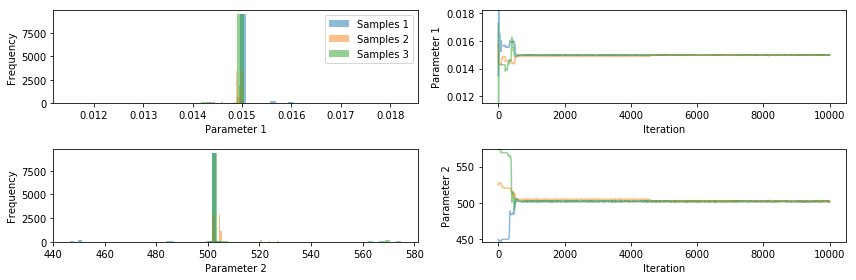

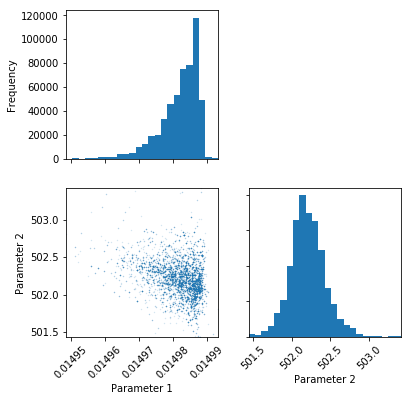

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

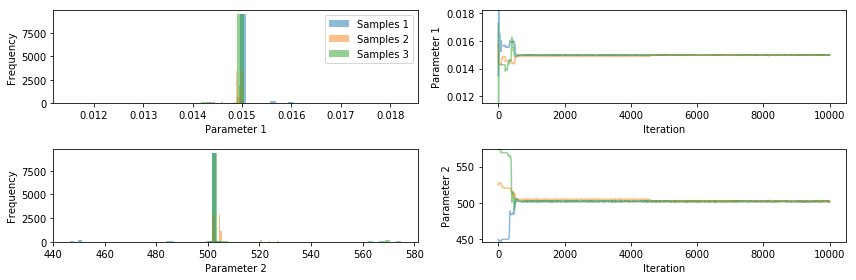

In [27]:
pints.plot.trace(chains_emu)
plt.show()

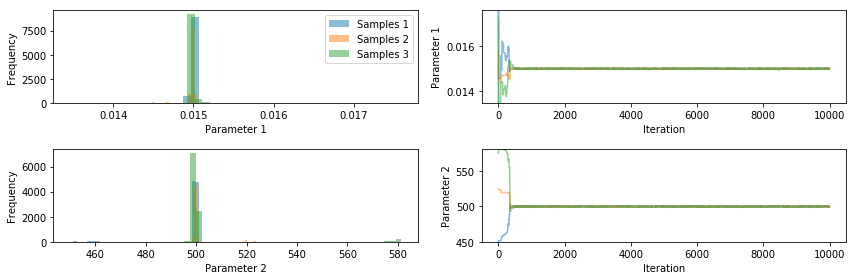

In [28]:
pints.plot.trace(chains)
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

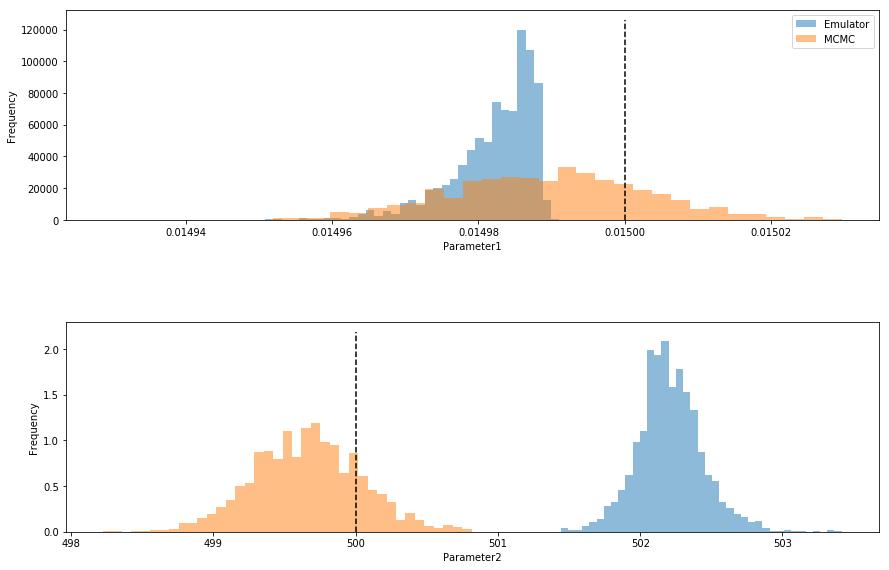

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

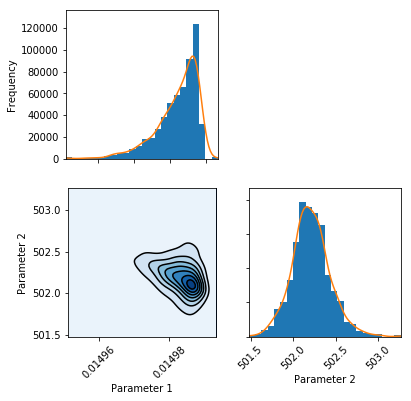

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

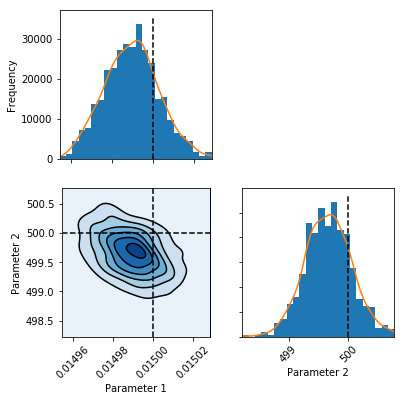

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

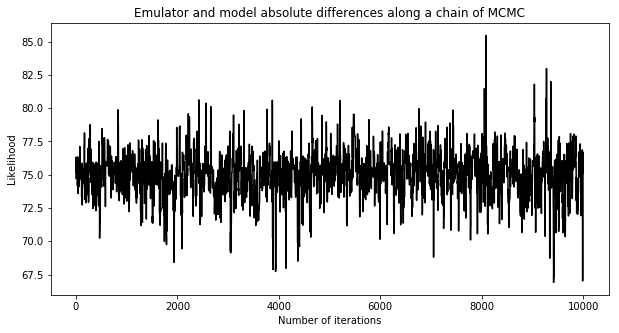

75.22126223502005

In [33]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

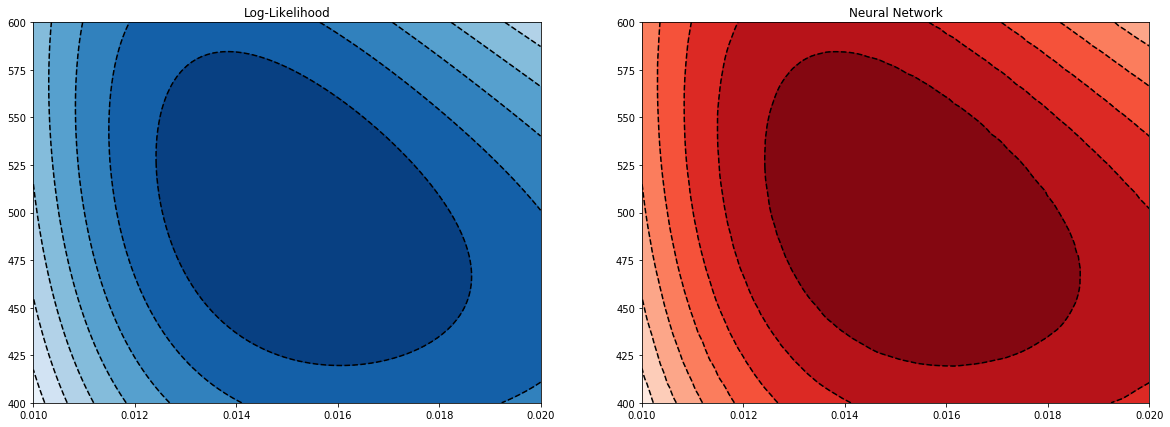

In [34]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

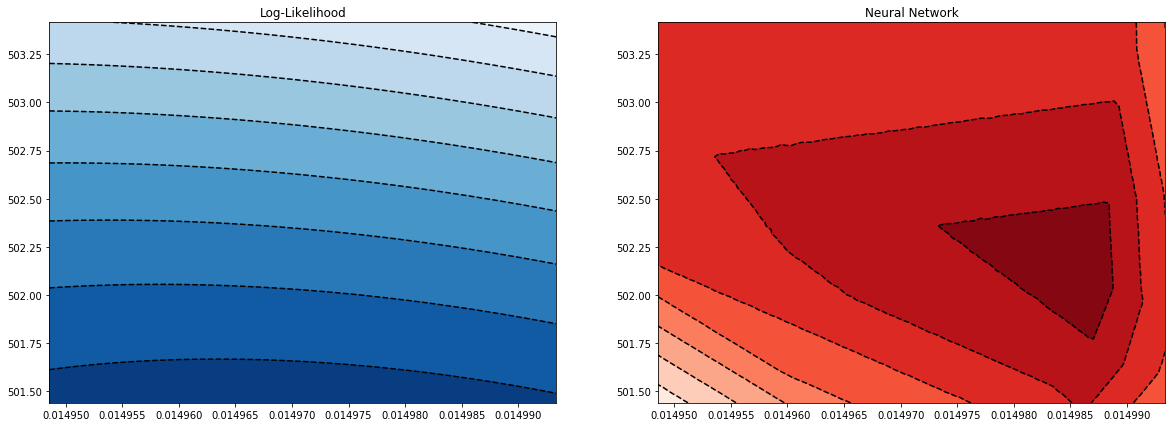

In [35]:
# Create grid
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

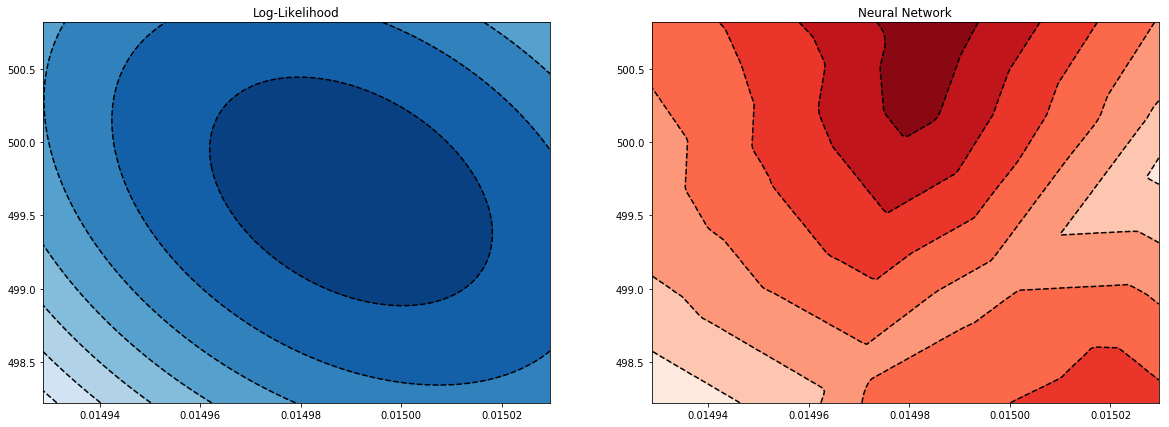

In [36]:
# Create grid
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

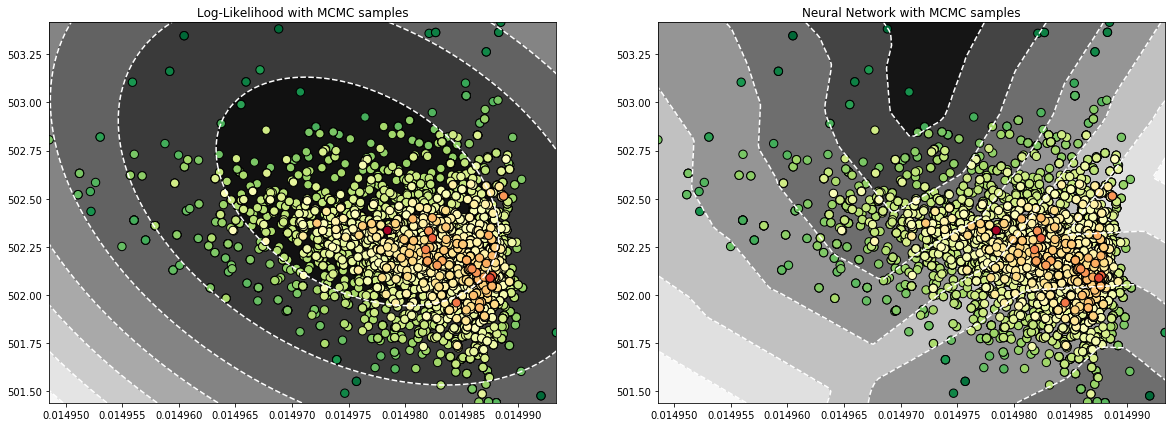

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

# Sort according to likelihood error
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

plt.show()

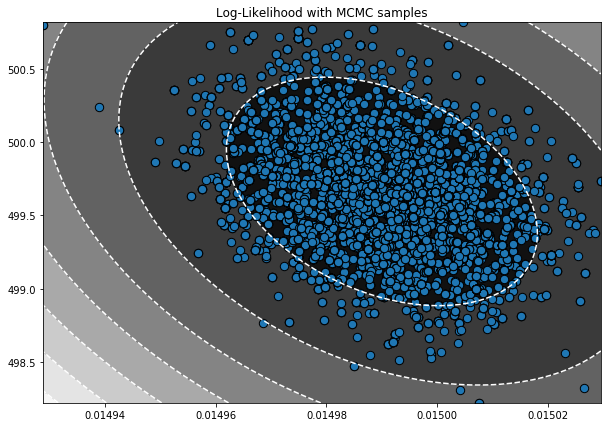

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()